# Introduction

In the Singapore context, the Government has just unveiled the Singapore Green Plan 2030 on 10 February 2021. This is a whole-of-nation campaign to advance Singapore’s national agenda on sustainable development. Singapore Green Plan 2030 stated that “Singapore will aim to halve its 2030 peak greenhouse gas emissions by 2050, and to achieve net zero emissions as soon as viable in the second half of the century”. The reason is simple and obvious: Singapore, as a low-lying island nation, is especially vulnerable when dealing with the consequences of climate change such as rising sea levels and extreme weather patterns, etc. 

One of the five pillars in Singapore Green Plan 2030 is the “Energy Reset” which aims to use cleaner energy and increase the energy efficiency to lower the carbon footprint. Thus the AI energy forecasting could definitely contribute more to the sustainable development of Singapore and revolutionize the current energy industry, with improved demand forecasting, superior asset management and operational excellence via enhanced automation, and further it would lead to greater cost-savings, better yields and improved returns on investment.

So in this project, the energy forecasting, in more detail, load forecasting is our key concern and focus.


In [1]:
# import basic libraries for data exploration

import os
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pylab as plt
from matplotlib import pyplot
from IPython.core.display import display, HTML
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, 
                                     cross_val_score)
import warnings # disable warnings for generate reports
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore') 
def action_with_warnings():
    warnings.warn("disable warnings")
with warnings.catch_warnings(record=True):
    action_with_warnings()

plt.style.use('seaborn')
sns.set(rc = {"figure.figsize" : (10, 7)})

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend


In [2]:
# Define parameters

DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
DATA_FILE = "PMT_22kV_HT_1-energy.csv"
FREQ = "1H" # frequency of the time series


In [3]:
# Load data
data = pd.read_csv(os.path.join(os.getcwd(), "data", DATA_FILE))

# Data Cleanup

## Dealing with NAN

Sometimes the devices like the power meter missing readings, or the services like weather data API, or human errors will introduce noise data or missing data problem for our algorithm. The problems are such raw data with null or NAN will affect the statistical calculations, some procedures not handle missing data gracefully, cause the final result we have is not what we expected.

There have few ways to handle the empty in the data, we can use ```isNull()``` method to find any possiable NAN values, then use ```.sum()``` to count of all NAN values per column.

To dealing with NAN values, we can remove those missing values by ```dropna()``` or filling missing values by ```fillna()```,  we will try those two methods in this exercise, to pre-process the raw data and the feature data for trainning.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9587 entries, 0 to 9586
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    9587 non-null   object 
 1   localtime               9587 non-null   object 
 2   power                   9587 non-null   float64
 3   temperature             9587 non-null   float64
 4   public_holiday          9587 non-null   int64  
 5   week_days               9587 non-null   int64  
 6   working_day             9587 non-null   int64  
 7   covid_phases            9587 non-null   int64  
 8   primary_school_holiday  9587 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 674.2+ KB


In [5]:
data.isnull().sum()

date                      0
localtime                 0
power                     0
temperature               0
public_holiday            0
week_days                 0
working_day               0
covid_phases              0
primary_school_holiday    0
dtype: int64

In [6]:
# Drop NANs

data.drop(data[data['power'] <= 0].index, inplace=True)
data["localtime"] = data["localtime"].apply(lambda dates: datetime.strptime(dates, DATE_FORMAT))
data.set_index("localtime", drop=True, inplace=True)

c_data = pd.DataFrame()

# We can how=`any` to drop any row when any column has a NAN value.
c_data = data.dropna(how='any')

print(c_data.shape)

(9582, 8)


## TimeSeries with specified frequency

As we are dealing with the time-series data for the training and for causing later, after removing NAN we may be facing another challenge to ensure the data continuity by removing some rows from the dataset. Pandas have the function ```.asfreq()``` and ```.resample()``` to help convert TimeSeries to follow specified frequency, ```.asfreq()``` also able to pad/backfill missing values, they return the original data with new index with specified frequency, the ```.resample()``` is more appropriate if need an operation, like summarization, aggregating groups.

In [7]:
# Convert TimeSeries to specified frequency

"""
 freq : DateOffset object, or string
 method : {‘backfill’/’bfill’, ‘pad’/’ffill’}, default None
 Method to use for filling holes in reindexed Series (note this does not fill NaNs that already were present):

 ‘pad’ / ‘ffill’: propagate last valid observation forward to next valid
 ‘backfill’ / ‘bfill’: use NEXT valid observation to fill
 how : {‘start’, ‘end’}, default end
 For PeriodIndex only, see PeriodIndex.asfreq

 normalize : bool, default False
 Whether to reset output index to midnight

 fill_value : scalar, optional
 Value to use for missing values, applied during upsampling (note this does not fill NaNs that already were present).

"""   
    
c_data = c_data.asfreq(FREQ,"ffill")
print(c_data.shape)

(10080, 8)


In [8]:
# Python is an object-oriented programming language. 
# Almost everything in Python is an object, with its properties and methods. 
# A Class is like an object constructor or a "blueprint" for creating objects. 

class TargetTransformer:
    """
    Perform some transformation on the time series
    data in order to make the model more performant and
    avoid non-stationary effects.
    """
        
    def __init__(self, log=False, detrend=False, diff=False):
        
        self.trf_log = log
        self.trf_detrend = detrend
        self.trend = pd.Series(dtype=np.float64)
    
    def transform(self, index, values):
        """
        Perform log transformation to the target time series

        :param index: the index for the resulting series
        :param values: the values of the initial series

        Return:
            transformed pd.Series
        """
        res = pd.Series(index=index, data=values)

        if self.trf_detrend:
            self.trend = TargetTransformer.get_trend(res) - np.mean(res.values)
            res = res.subtract(self.trend)
            
        if self.trf_log:
            res = pd.Series(index=index, data=np.log(res.values))
        
        return res
    
    def inverse(self, index, values):
        """
        Go back to the original time series values

        :param index: the index for the resulting series
        :param values: the values of series to be transformed back

        Return:
            inverse transformed pd.Series
        """        
        res = pd.Series(index=index, data=values)
        
        if self.trf_log:
            res = pd.Series(index=index, data=np.exp(values))
        try:
            if self.trf_detrend:
                assert len(res.index) == len(self.trend.index)                
                res = res + self.trend
                
        except AssertionError:
            print("Use a different transformer for each target to transform")
            
        return res
    
    @staticmethod
    def get_trend(data):
        """
        Get the linear trend on the data which makes the time
        series not stationary
        """
        n = len(data.index)
        X = np.reshape(np.arange(0, n), (n, 1))
        y = np.array(data)
        model = LinearRegression()
        model.fit(X, y)
        trend = model.predict(X)
        return pd.Series(index=data.index, data=trend)

## Exploring the data

There are multiple tools to help explore the data patterns, include statistical, relation, trend, and more meaning from the data to helps us understand the data in an easier and visualizer way, also benefits on the feature engineering to increase the accuracy of the forecasting results.

In this study, we will use multiple ways to describe and visualize the data, from the libraries include pandas, seaborn, statsmodels to understand the data, view the relations, and find the patterns.
1. Pandas Dataframe.describe
2. Pandas DataFrame.corr
3. seaborn.pairplot
4. seaborn.kdeplot
5. statsmodels ACF, PACF, seasonal, seasonal_decompose

With such tools helps, we understand the data are mostly in daily, weekly seasonality. The power data are more impacted by temperature, weekdays, working days (compare to non-working days), and COVID Phases, but less related to the primary school holiday. As experience working in Singapore, when primary school holiday period, a lot of family traveling oversea, that fewer people in office result in less energy used. But after we use this year's 2020 office energy data for the exploring, this relation impacts by the COVID pandemic, parents not able to go out of Singapore, results in the smallest relation between primary school holiday and energy usage.

In [9]:
# Use pandas describe() to view the basic statistical details like percentile, mean, std of the data.
data.describe()

power  temperature  public_holiday    week_days  working_day  \
count  9582.000000  9582.000000     9582.000000  9582.000000  9582.000000   
mean    293.938247    27.818565        0.038614     3.982885     0.715717   
std     186.375495     2.048948        0.192683     2.006076     0.451096   
min      70.835410    21.466667        0.000000     1.000000     0.000000   
25%     160.653430    26.366667        0.000000     2.000000     0.000000   
50%     190.139101    27.750000        0.000000     4.000000     1.000000   
75%     436.319541    29.166667        0.000000     6.000000     1.000000   
max     833.013384    34.740000        1.000000     7.000000     1.000000   

       covid_phases  primary_school_holiday  
count   9582.000000             9582.000000  
mean       3.408265                0.207472  
std        3.106684                0.405518  
min        0.000000                0.000000  
25%        2.000000                0.000000  
50%        2.000000                0.000000  
75%        3.000000                0.000000  
max        9.000000                1.000000

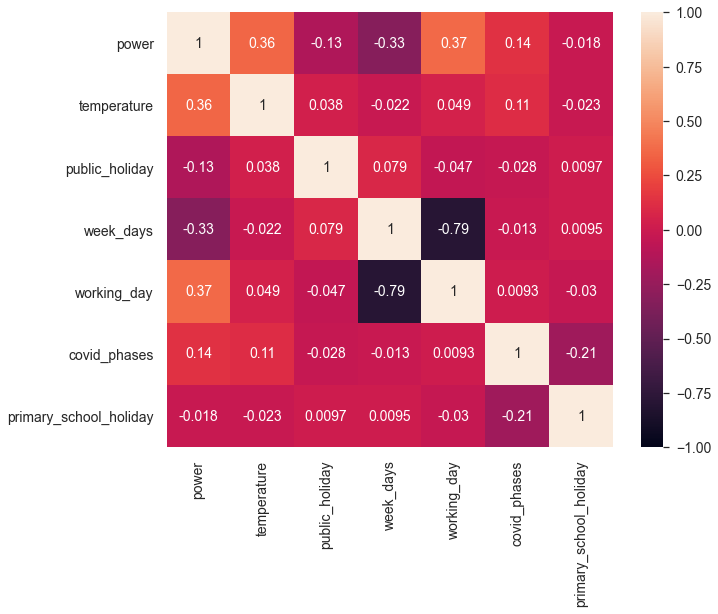

power  temperature  public_holiday  week_days  \
power                   1.000000     0.357411       -0.133980  -0.326363   
temperature             0.357411     1.000000        0.038299  -0.021639   
public_holiday         -0.133980     0.038299        1.000000   0.078936   
week_days              -0.326363    -0.021639        0.078936   1.000000   
working_day             0.372131     0.049371       -0.046610  -0.790023   
covid_phases            0.137314     0.114961       -0.028431  -0.013315   
primary_school_holiday -0.017739    -0.022982        0.009665   0.009498   

                        working_day  covid_phases  primary_school_holiday  
power                      0.372131      0.137314               -0.017739  
temperature                0.049371      0.114961               -0.022982  
public_holiday            -0.046610     -0.028431                0.009665  
week_days                 -0.790023     -0.013315                0.009498  
working_day                1.000000      0.009318               -0.030152  
covid_phases               0.009318      1.000000               -0.208084  
primary_school_holiday    -0.030152     -0.208084                1.000000

In [10]:
#correlation between the values
'''
corr() is used to find the pairwise correlation of all columns in the dataframe. 
Any na values are automatically excluded. For any non-numeric data type columns in the dataframe it is ignored
'''

corr = data.corr()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr, vmin = -1, vmax = 1, annot = True)
plt.show()
corr

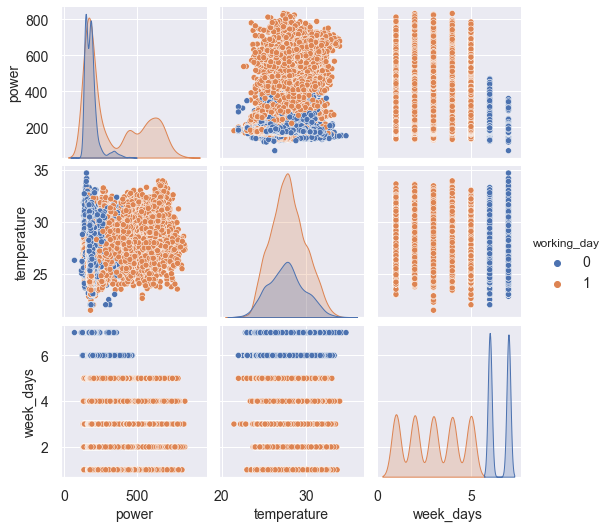

In [11]:
# Pair Plot correlation between all attributes, 
'''
Plot pairwise relationships in a dataset. 
By default, this function will create a grid of Axes 
such that each numeric variable in data will by shared across the y-axes across a single row 
and the x-axes across a single column.
'''
pairplot_data = data.loc[:,['power','temperature','week_days','working_day']]

sns.pairplot(pairplot_data, hue="working_day")


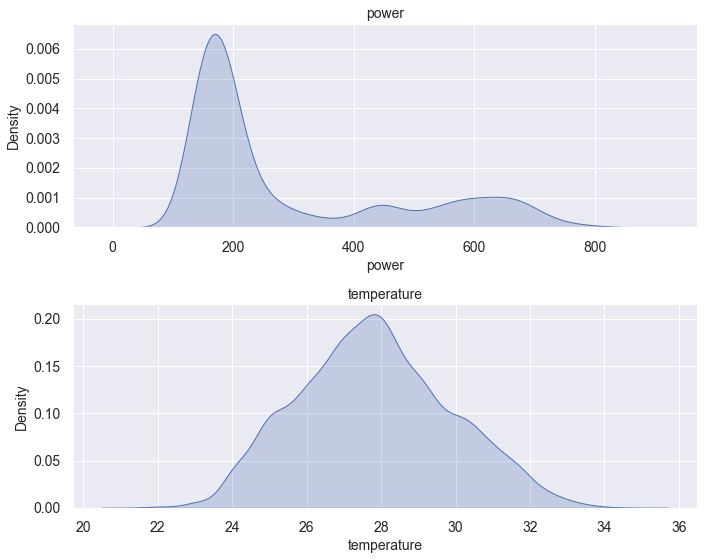

In [12]:
#plotting the data distribution

plt.figure(figsize=(10, 8))
for i in range(2):
    plt.subplot(2, 1, i+1)
    sns.kdeplot(data.iloc[:,i+1], shade=True)
    plt.title(data.columns[i+1])
plt.tight_layout()
plt.show()

In [13]:
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

In [14]:
def ts_analysis_plots(data, n_lags=100):
    def plot_cf(ax, fn, data, n_lags):
        """
        Plot autocorrelation functions for the loads
        """
        fn(data, ax=ax, lags=n_lags, color="#0504aa")
        for i in range(1, 5):
            ax.axvline(x=24 * i, ymin=0.0, ymax=1.0, color="grey", ls="--")

    # AD Fuller test and linear trend of the time series
    # 单位根检验（Unit Root Test）单位根检验是针对宏观经济数据序列、
    # 货币金融数据序列中是否具有某种统计特性而提出的一种平稳性检验的特殊方法，
    # 单位根检验的方法有很多种，包括ADF检验、PP检验、NP检验等。
    trend = TargetTransformer.get_trend(data)
    adf = adfuller(data)

    fig, axs = plt.subplots(4, 1, figsize=(15, 30))
    axs = axs.flat

    # original time series
    axs[0].plot(data, color="#0504aa")
    axs[0].plot(trend, color="red")
    axs[0].set(
        xlabel="Date",
        ylabel="KW",
        title=f"Energy consumption over time (ADF p-value: {round(adf[1], 6)})"
    ) 
    
    # histogram of value distribution
    axs[1].hist(data, bins=20, width=3, color="#0504aa", alpha=0.7)
    axs[1].set(xlabel="KW", ylabel="# data points", title="Energy values distribution") 
    """
    https://blog.csdn.net/qq_41103204/article/details/105810742
    ACF 是一个完整的自相关函数，可为我们提供具有滞后值的任何序列的自相关值。
    简单来说，它描述了该序列的当前值与其过去的值之间的相关程度。时间序列可以包含趋势，季节性，周期性和残差等成分。
    ACF在寻找相关性时会考虑所有这些成分。
    直观上来说，ACF 描述了一个观测值和另一个观测值之间的自相关，包括直接和间接的相关性信息。

    PACF 是部分自相关函数或者偏自相关函数。基本上，它不是找到像ACF这样的滞后与当前的相关性，
    而是找到残差（在去除了之前的滞后已经解释的影响之后仍然存在）与下一个滞后值的相关性。
    因此，如果残差中有任何可以由下一个滞后建模的隐藏信息，我们可能会获得良好的相关性，并且在建模时我们会将下一个滞后作为特征。
    在建模时，我们不想保留太多相互关联的特征，因为这会产生多重共线性问题。因此，我们只需要保留相关功能。

    https://blog.csdn.net/weixin_41013322/article/details/108801516

    """

    # autocorrelation function
    plot_cf(axs[2], plot_acf, data, n_lags)
    axs[2].set(xlabel="lag", ylabel="ACF value")
    
    # partial autocorrelation function
    plot_cf(axs[3], plot_pacf, data, n_lags)
    axs[3].set(xlabel="lag", ylabel="PACF value")    
      
    plt.show()

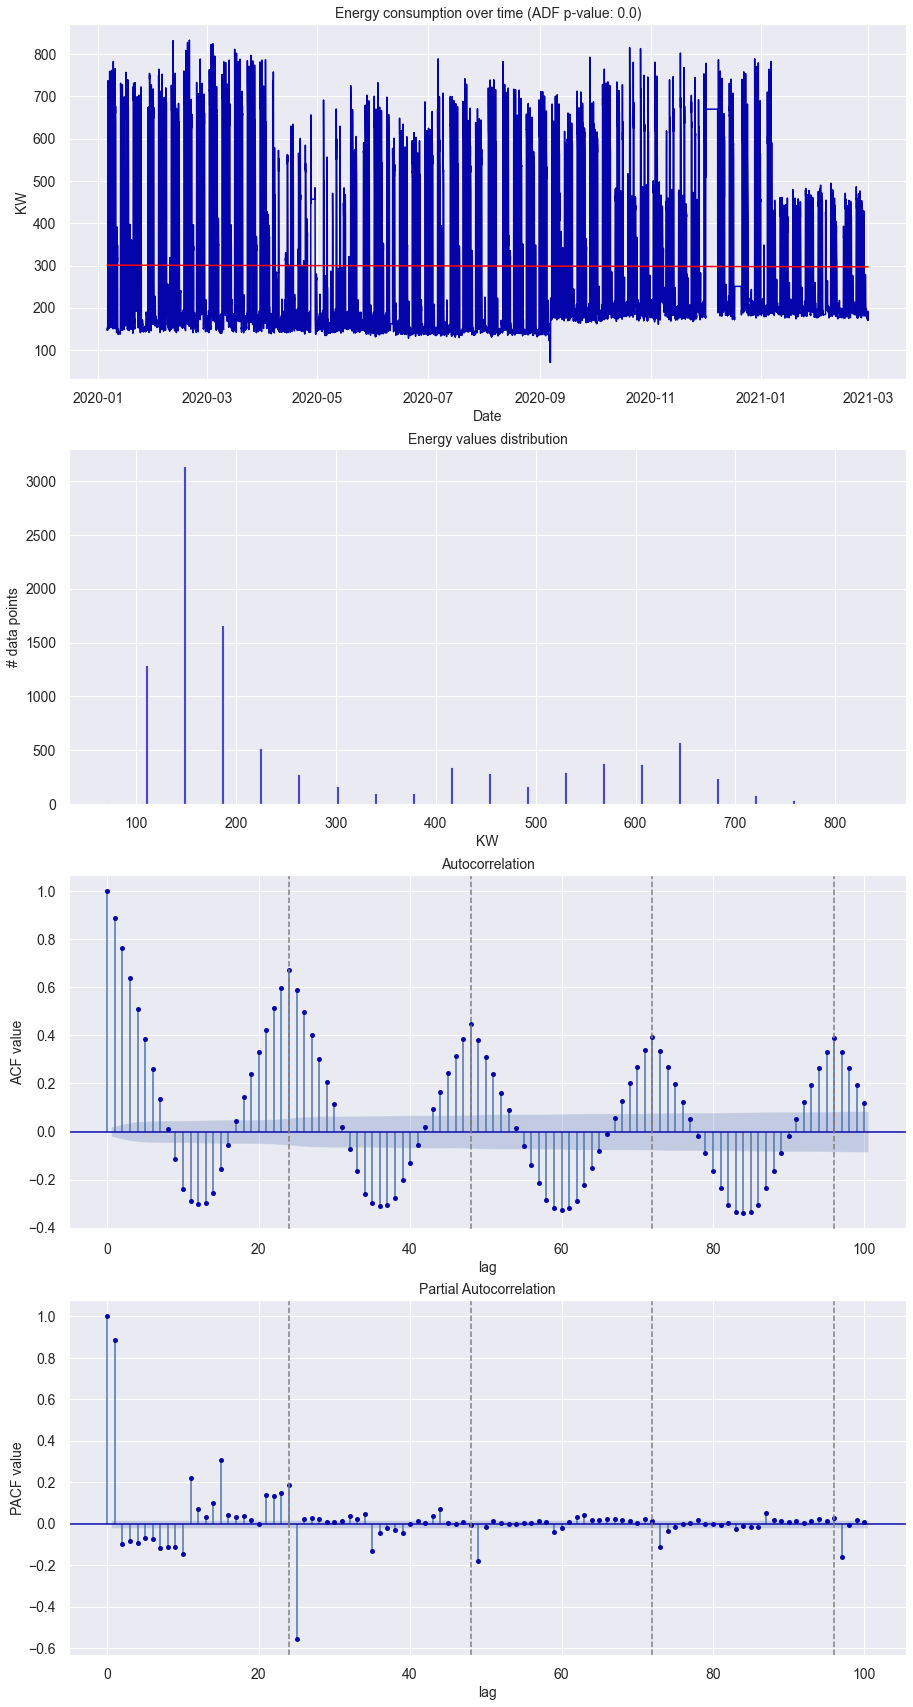

In [15]:
ts_analysis_plots(c_data["power"])

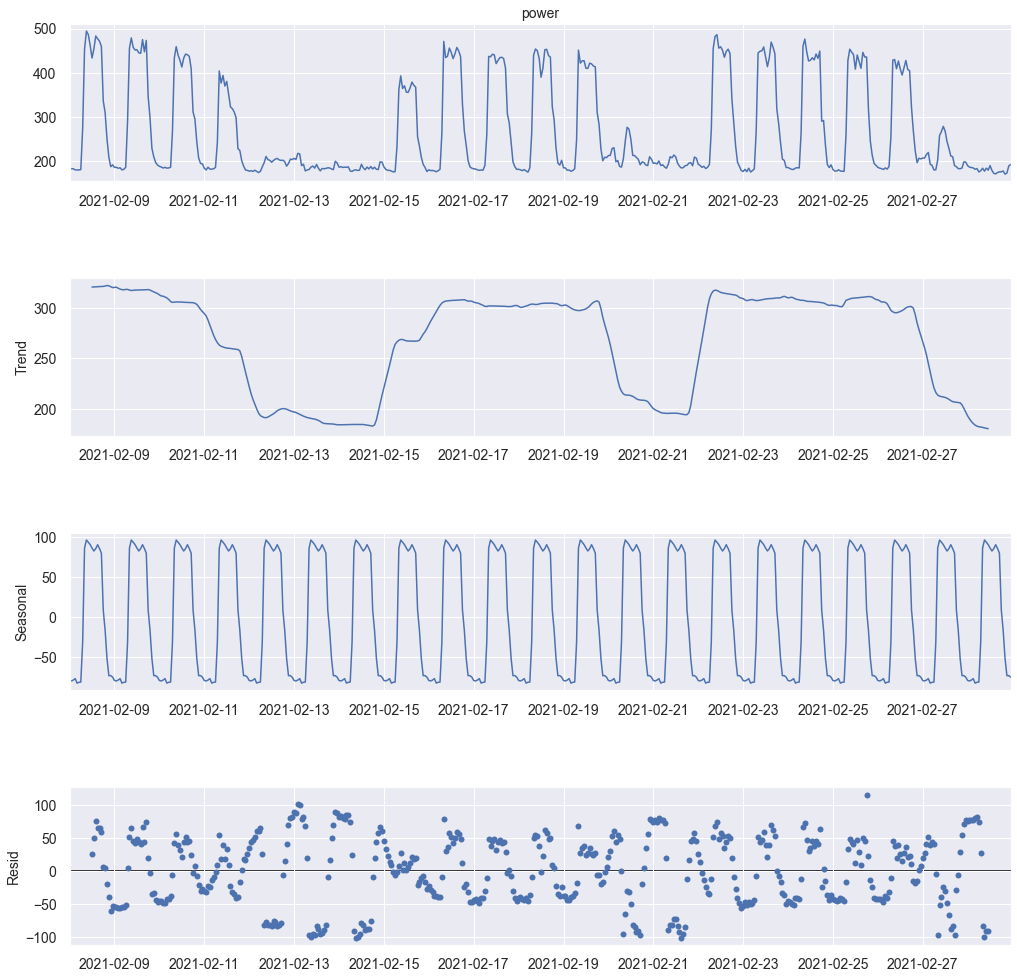

In [16]:
energy_data = c_data["power"]
date = energy_data.index[-1] - pd.Timedelta(weeks=3)
energy_data = energy_data[energy_data.index > date]
res = seasonal_decompose(energy_data, model='additive')
fig = res.plot()
fig.set_size_inches((15, 15))

# Time Series forcasting models
We will consider the following models in this study:
1. Prophet
2. SES 
3. Holt's Method
4. Holt-Winters
5. Ridge
6. XGBoost
7. Multi-step recursive forecasting
8. Multi-step direct forecasting
9. Long Short Term Memory (LSTM)
10. LSTM with multi-features vs selected features




## Use MAPE to measure
The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), measures the accuracy of a method for constructing fitted time series values in statistics.


In [17]:
from sklearn.metrics import make_scorer

# MAPE computation
def mape(actual, prediction, perc=True):
    mape = np.mean(np.abs((prediction - actual) / actual)) * 100
    return mape

mape_scorer = make_scorer(mape, greater_is_better=False)

In [18]:
# Parameter Defination

# To perform 2 days forecasting, as using hourly data, so the steps use 96
FCAST_STEPS = 96

# seasonal period inferred from the autocorrelation function (ACF)
SEASONAL_PERIOD = 24

# dictionary to keep track of all results
# TODO, add all other forecasting results
forecasting_results = {
    "prophet" : {},
    "ses": {},
    "holt": {},
    "holt_winters": {},
    "ridge": {},
    "xgb": {},
    "xgb_recursive": {},
    "xgb_direct": {},
    "lstm": {},
    "lstm_features": {},
    "lstm_features_selected": {},
    "lstm_features_weather_only": {},
    "arima": {}
}


def week_days(ds):
    date = pd.to_datetime(ds)
    return date.weekday()+1

def working_day(ds):
    date = pd.to_datetime(ds)
    if date.weekday() > 4:
        return 0
    else:
        return 1

def covid_phases(ds):
    # Assume after 28 Dec 2020 what we forecasting still in this COVID Phase 3
    return 3

In [19]:
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation as prophet_cv


# the complete time series
c_target = c_data["power"]

# data used for training
date = c_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
t_target = c_target[c_target.index <= date]
t_src_data = c_data[c_target.index <= date]

# data used for forecasting
f_target = c_target[c_target.index > date]
f_src_data = c_data[c_target.index > date]
fcast_initial_date = f_target.index[0]
fcast_range = pd.date_range(fcast_initial_date, periods=FCAST_STEPS, freq="H")

print(f"Full available time range: from {c_target.index[0]} to {c_target.index[-1]}")
print(f"Training time range: from {t_target.index[0]} to {t_target.index[-1]}")
print(f"Short forecasting time range: from {fcast_range[0]} to {fcast_range[-1]}")
print(t_target.head(5))


Importing plotly failed. Interactive plots will not work.


Full available time range: from 2020-01-06 00:00:00 to 2021-02-28 23:00:00
Training time range: from 2020-01-06 00:00:00 to 2021-02-24 23:00:00
Short forecasting time range: from 2021-02-25 00:00:00 to 2021-02-28 23:00:00
localtime
2020-01-06 00:00:00    147.260343
2020-01-06 01:00:00    146.603141
2020-01-06 02:00:00    151.596845
2020-01-06 03:00:00    152.935429
2020-01-06 04:00:00    152.300870
Freq: H, Name: power, dtype: float64


In [20]:
# start_date = t_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
start_date = t_target.index[-1]
y_train_trf = TargetTransformer()
x_train = t_src_data[t_src_data.index <= start_date]
y_train = t_target[t_target.index <= start_date]
y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer()
x_test = f_src_data[f_src_data.index > start_date]
y_test = f_target[f_target.index > start_date]
y_test_trf = y_test_trf.transform(y_test.index, y_test.values)
print(x_train.tail(5))

                           date       power  temperature  public_holiday  \
localtime                                                                  
2021-02-24 19:00:00  2021-02-24  291.797513    26.966667               0   
2021-02-24 20:00:00  2021-02-24  236.360338    26.200000               0   
2021-02-24 21:00:00  2021-02-24  192.229253    25.850000               0   
2021-02-24 22:00:00  2021-02-24  185.154016    25.400000               0   
2021-02-24 23:00:00  2021-02-24  191.265010    25.150000               0   

                     week_days  working_day  covid_phases  \
localtime                                                   
2021-02-24 19:00:00          3            1             3   
2021-02-24 20:00:00          3            1             3   
2021-02-24 21:00:00          3            1             3   
2021-02-24 22:00:00          3            1             3   
2021-02-24 23:00:00          3            1             3   

                     primary_school_hol

## Prophet

https://facebook.github.io/prophet/
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.





In [21]:
# Facebook Prophet


def fit_prophet_model(data, xdata):

    print(data.shape) # train data shape
    prophet_data = pd.DataFrame()
    prophet_data = data.copy().reset_index()

    prophet_data_merged = pd.merge(
        prophet_data,
        xdata[["working_day", "week_days", "covid_phases"]],
        on=["localtime"],
    )
    print(prophet_data_merged.tail())

    prophet_data_merged.columns = [
        "ds",
        "y",
        "working_day",
        "week_days",
        "covid_phases",
    ]

    # create Prophet model
    prophet_m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    # Add local country holidays from the library
    prophet_m.add_country_holidays(country_name="SG")

    #     With add_regressor
    prophet_m.add_regressor("working_day")
    prophet_m.add_regressor("week_days")
    prophet_m.add_regressor("covid_phases")

    print(prophet_data_merged.shape)
    prophet_m.fit(prophet_data_merged)

    # cross-validation score
    horizon = 480
    res = None
    res = prophet_cv(prophet_m, horizon=f"{horizon} hours")
    cv_score = mape(res["y"], res["yhat"])
    return prophet_m, cv_score


prophet_model_f, cv_score = fit_prophet_model(y_train, x_train)


(9984,)
               localtime       power  working_day  week_days  covid_phases
9979 2021-02-24 19:00:00  291.797513            1          3             3
9980 2021-02-24 20:00:00  236.360338            1          3             3
9981 2021-02-24 21:00:00  192.229253            1          3             3
9982 2021-02-24 22:00:00  185.154016            1          3             3
9983 2021-02-24 23:00:00  191.265010            1          3             3
(9984, 5)


INFO:fbprophet:Making 34 forecasts with cutoffs between 2020-03-11 23:00:00 and 2021-02-04 23:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

                       ds  week_days  working_day  covid_phases
10075 2021-02-28 19:00:00          7            0             3
10076 2021-02-28 20:00:00          7            0             3
10077 2021-02-28 21:00:00          7            0             3
10078 2021-02-28 22:00:00          7            0             3
10079 2021-02-28 23:00:00          7            0             3


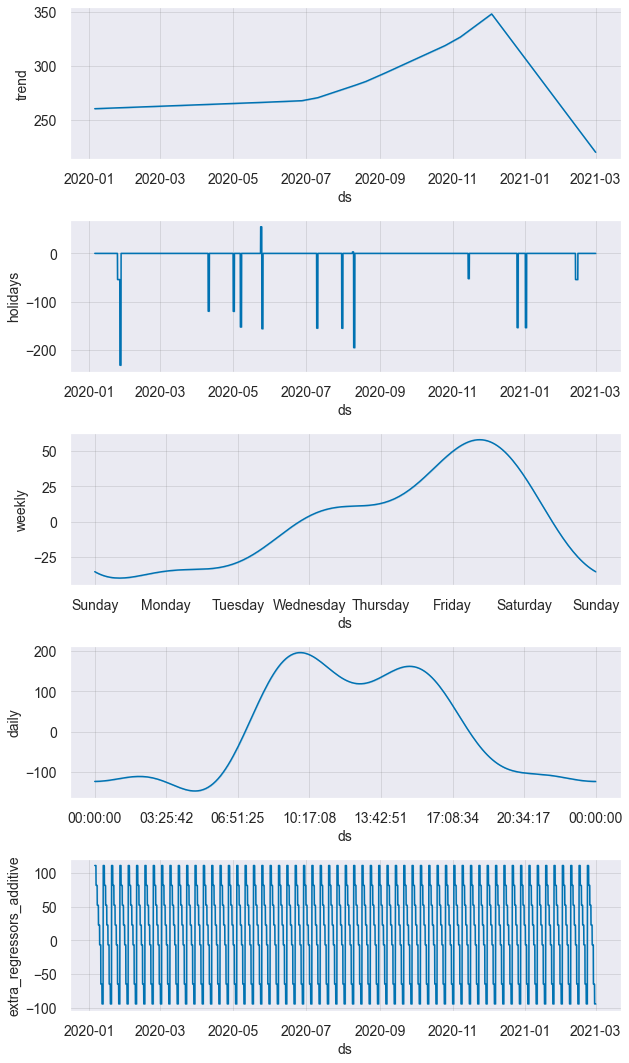

In [22]:
# Make the predict for the forecast period

prophet_future = prophet_model_f.make_future_dataframe(periods=FCAST_STEPS, freq="1H")
prophet_future['week_days'] = prophet_future['ds'].apply(week_days)
prophet_future['working_day'] = prophet_future['ds'].apply(working_day)
prophet_future['covid_phases'] = prophet_future['ds'].apply(covid_phases)

print(prophet_future.tail())

prophet_test_fcast = prophet_model_f.predict(prophet_future)
fig = prophet_model_f.plot_components(prophet_test_fcast)

In [23]:
# Calculate the model MAPE

prophet_fcast = pd.Series(
    index=prophet_test_fcast["ds"], data=np.array(prophet_test_fcast["yhat"])
)
prophet_test_fcast = np.array(prophet_test_fcast["yhat"])[-FCAST_STEPS:]
prophet_test_score = mape(y_test.values, prophet_test_fcast)
print('Prophet model MAPE is {:.2f}%'.format(prophet_test_score))

Prophet model MAPE is 38.22%


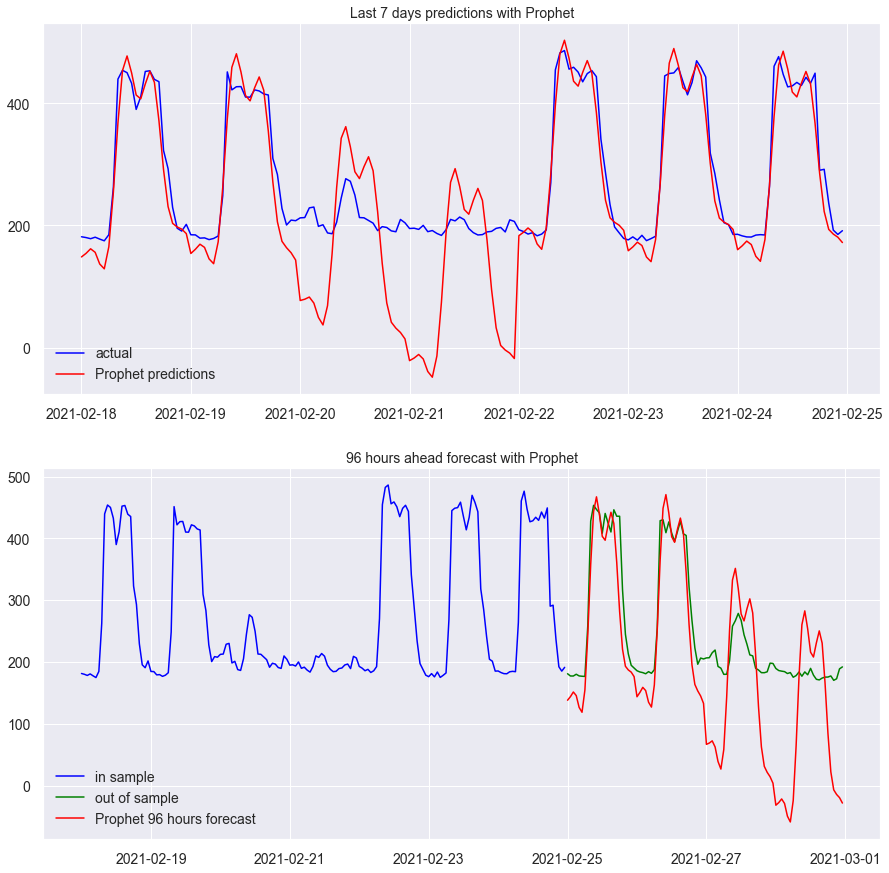

In [24]:
# Render the actual and forecast data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

start_date = t_target.index[-1] - pd.Timedelta(weeks=1)
ax1.locator_params(nbins=6)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(prophet_fcast[(prophet_fcast.index > start_date) & (prophet_fcast.index <= t_target.index[-1])], 
         color="red", label="Prophet predictions")
ax1.set_title("Last 7 days predictions with Prophet")

ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(prophet_fcast[prophet_fcast.index >= f_target.index[0]], 
         color="red", 
         label=f"Prophet {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Prophet")

ax1.legend()
ax2.legend()
plt.show()

# save results for later comparison
forecasting_results["prophet"] = {
    "fcast": prophet_fcast,
    "model": prophet_model_f,
    "mape": prophet_test_score,
    "train_mape": cv_score,
    "explained_variance_score": explained_variance_score(y_test.values, prophet_test_fcast)
}

We try another way to use the Prophet model, which reduce other features just to use the public holiday.


In [25]:
# Facebook Prophet with public holiday data only


def fit_prophet_model(data, xdata):

    prophet_data = pd.DataFrame()
    prophet_data = data.copy().reset_index()

    prophet_data.columns = ["ds", "y"]

    # create Prophet model
    prophet_m = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
    )

    prophet_m.add_country_holidays(country_name="SG")

    print(prophet_data.shape)
    prophet_m.fit(prophet_data)

    # cross-validation score
    horizon = 480
    res = None
    res = prophet_cv(prophet_m, horizon=f"{horizon} hours")
    cv_score = mape(res["y"], res["yhat"])
    return prophet_m, cv_score


prophet_model_p, cv_score = fit_prophet_model(y_train, x_train)


(9984, 2)


INFO:fbprophet:Making 34 forecasts with cutoffs between 2020-03-11 23:00:00 and 2021-02-04 23:00:00


  0%|          | 0/34 [00:00<?, ?it/s]

                       ds  week_days  working_day  covid_phases
10075 2021-02-28 19:00:00          7            0             3
10076 2021-02-28 20:00:00          7            0             3
10077 2021-02-28 21:00:00          7            0             3
10078 2021-02-28 22:00:00          7            0             3
10079 2021-02-28 23:00:00          7            0             3


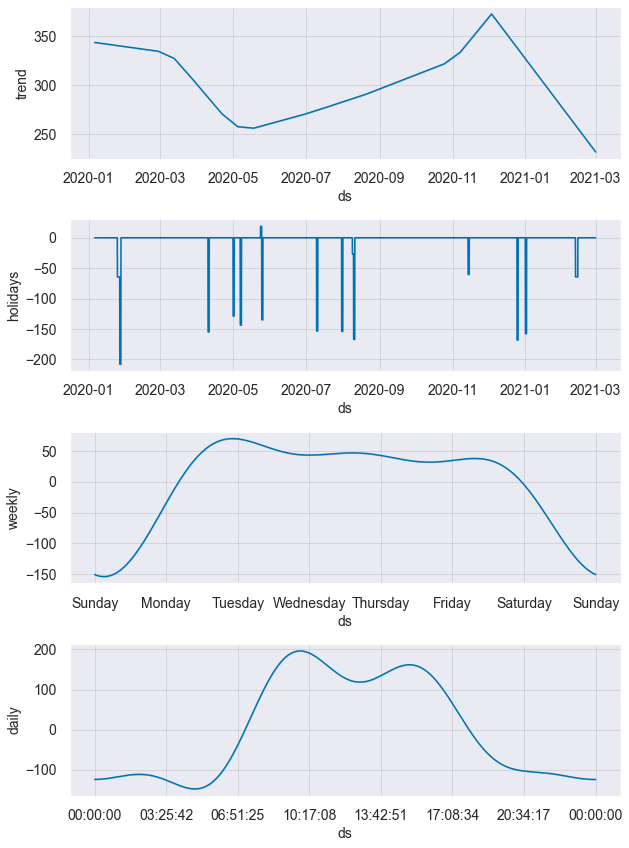

In [26]:
# Make the predict for the forecast period

prophet_future = prophet_model_p.make_future_dataframe(periods=FCAST_STEPS, freq="1H")
prophet_future['week_days'] = prophet_future['ds'].apply(week_days)
prophet_future['working_day'] = prophet_future['ds'].apply(working_day)
prophet_future['covid_phases'] = prophet_future['ds'].apply(covid_phases)

print(prophet_future.tail())

prophet_test_fcast = prophet_model_p.predict(prophet_future)
fig = prophet_model_p.plot_components(prophet_test_fcast)

In [27]:
# Calculate the model MAPE

prophet_fcast = pd.Series(
    index=prophet_test_fcast["ds"], data=np.array(prophet_test_fcast["yhat"])
)
prophet_test_fcast = np.array(prophet_test_fcast["yhat"])[-FCAST_STEPS:]
prophet_test_score = mape(y_test.values, prophet_test_fcast)
print('Prophet model MAPE is {:.2f}%'.format(prophet_test_score))

Prophet model MAPE is 37.04%


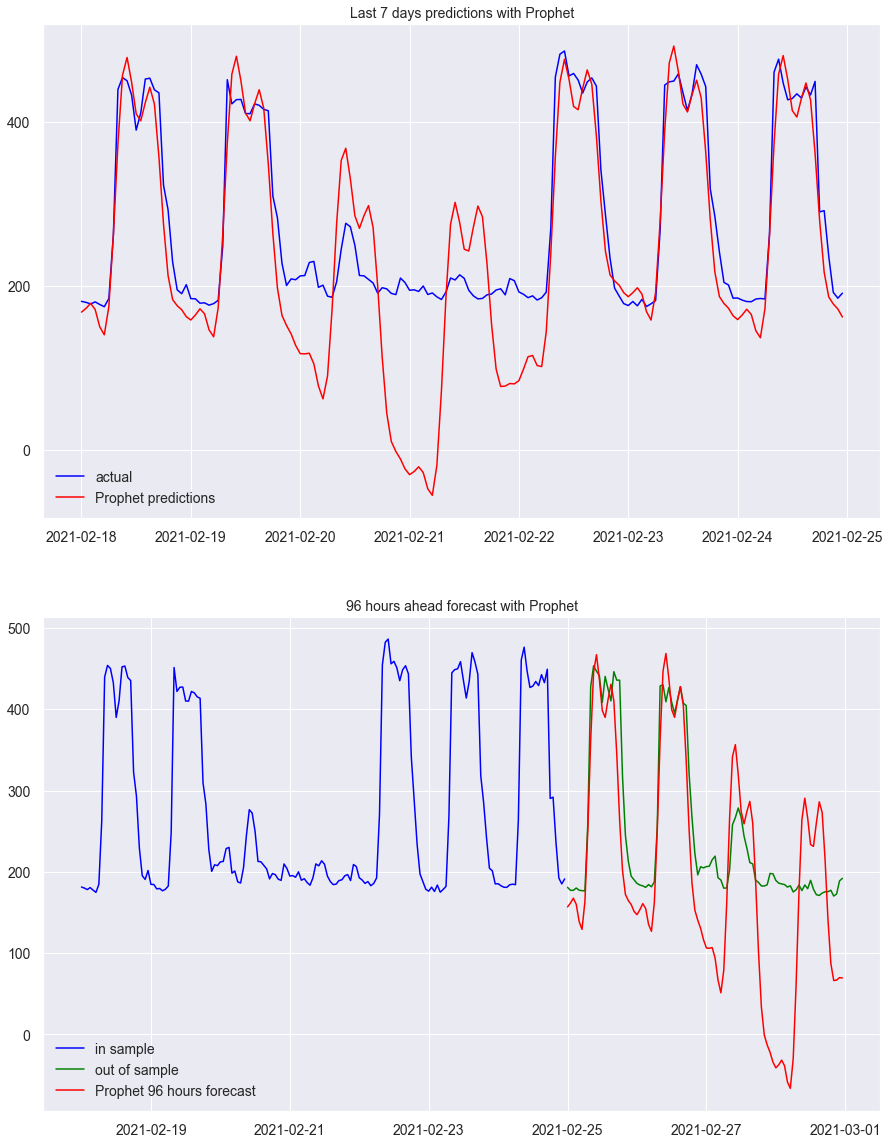

In [28]:
# Render the actual and forecast data

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

start_date = t_target.index[-1] - pd.Timedelta(weeks=1)
ax1.locator_params(nbins=6)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(prophet_fcast[(prophet_fcast.index > start_date) & (prophet_fcast.index <= t_target.index[-1])], 
         color="red", label="Prophet predictions")
ax1.set_title("Last 7 days predictions with Prophet")

ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(prophet_fcast[prophet_fcast.index >= f_target.index[0]], 
         color="red", 
         label=f"Prophet {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Prophet")

ax1.legend()
ax2.legend()
plt.show()



## Holt-Winters Forecasting



![Holt-Winters](https://i.loli.net/2019/03/26/5c99c626bea75.png)

In [29]:
# fit the classical models


def fit_classical_model(data, model, params=None):
    tscv = TimeSeriesSplit(n_splits=5)

    # train the model before-hand with automatic
    # parameter optimization
    fit = model.fit(optimized=True)
    values = data.values
    params = fit.model.params

    # compute the total average error
    err = []
    for _, test in tscv.split(values):
        predicted = model.predict(params, start=test[0], end=test[-1])
        actual = values[test]
        err.append(mape(actual, predicted))

    return model, fit, np.mean(np.array(err))


# SES
model = SimpleExpSmoothing(t_target)
res = fit_classical_model(t_target, model)
forecasting_results["ses"]["model"] = res[1]
forecasting_results["ses"]["train_mape"] = res[2]


# Holt's
model = Holt(t_target)
res = fit_classical_model(t_target, model)
forecasting_results["holt"]["model"] = res[1]
forecasting_results["holt"]["train_mape"] = res[2]


# Holt-Winters
model = ExponentialSmoothing(
    t_target,
    trend=None,
    seasonal="add",
    damped=False,
    seasonal_periods=SEASONAL_PERIOD * 7,
)
res = fit_classical_model(t_target, model)
forecasting_results["holt_winters"]["model"] = res[1]
forecasting_results["holt_winters"]["train_mape"] = res[2]
print(
    f"Holt-Winters MAPE score for train set: {forecasting_results['holt_winters']['train_mape']}"
)

# Prepare the forecasting results
ses_pred = forecasting_results["ses"]["model"].predict(
    start=t_target.index[0], end=t_target.index[-1]
)
ses_fcast = forecasting_results["ses"]["model"].forecast(FCAST_STEPS)

holt_pred = forecasting_results["holt"]["model"].predict(
    start=t_target.index[0], end=t_target.index[-1]
)
holt_fcast = forecasting_results["holt"]["model"].forecast(FCAST_STEPS)

des_pred = forecasting_results["holt_winters"]["model"].predict(
    start=t_target.index[0], end=t_target.index[-1]
)
des_fcast = forecasting_results["holt_winters"]["model"].forecast(FCAST_STEPS)


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Holt-Winters MAPE score for train set: 10.115434522598587


In [30]:
# Calculate the model MAPE

fcast_score = mape(c_target.loc[fcast_range].values, holt_fcast.values)
print("Holt model MAPE is {:.2f}%".format(fcast_score))
# save results for later comparison
forecasting_results["holt"] = {
    "fcast": holt_fcast,
    "fcast_score": fcast_score,
    "mape": fcast_score,
    "explained_variance_score": explained_variance_score(
        c_target.loc[fcast_range].values, holt_fcast.values
    ),
}


fcast_score = mape(c_target.loc[fcast_range].values, des_fcast.values)
print("Holt-Winters model MAPE is {:.2f}%".format(fcast_score))
# save results for later comparison
forecasting_results["holt_winters"] = {
    "fcast": des_fcast,
    "fcast_score": fcast_score,
    "mape": fcast_score,
    "explained_variance_score": explained_variance_score(
        c_target.loc[fcast_range].values, des_fcast.values
    ),
}

fcast_score = mape(c_target.loc[fcast_range].values, ses_fcast.values)
print("SimpleExpSmoothing model MAPE is {:.2f}%".format(fcast_score))
# save results for later comparison
forecasting_results["ses"] = {
    "fcast": ses_fcast,
    "fcast_score": fcast_score,
    "mape": fcast_score,
    "explained_variance_score": explained_variance_score(
        c_target.loc[fcast_range].values, ses_fcast.values
    ),
}


Holt model MAPE is 20.87%
Holt-Winters model MAPE is 23.02%
SimpleExpSmoothing model MAPE is 19.39%


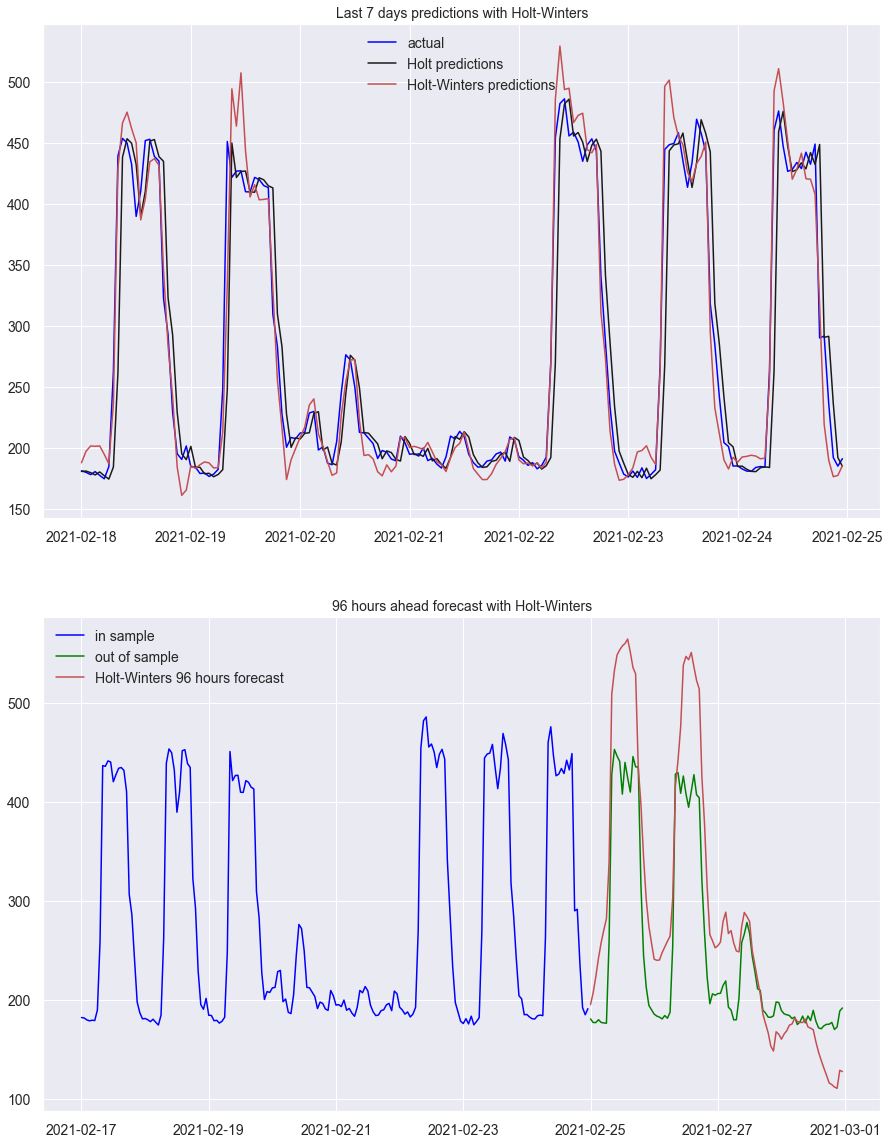

In [31]:
# Render the actual and forecast data for Holt-Winters

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

start_date = t_target.index[-1] - pd.Timedelta(days=7)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(holt_pred[(holt_pred.index > start_date) & (holt_pred.index <= t_target.index[-1])], 
         color="k", label="Holt predictions")
ax1.plot(des_pred[(des_pred.index > start_date) & (des_pred.index <= t_target.index[-1])], 
         color="r", label="Holt-Winters predictions")
ax1.set_title("Last 7 days predictions with Holt-Winters")

start_date = t_target.index[-1] - pd.Timedelta(days=8)
ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(des_fcast, color="r", 
         label=f"Holt-Winters {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Holt-Winters")

ax1.legend()
ax2.legend()
plt.show()

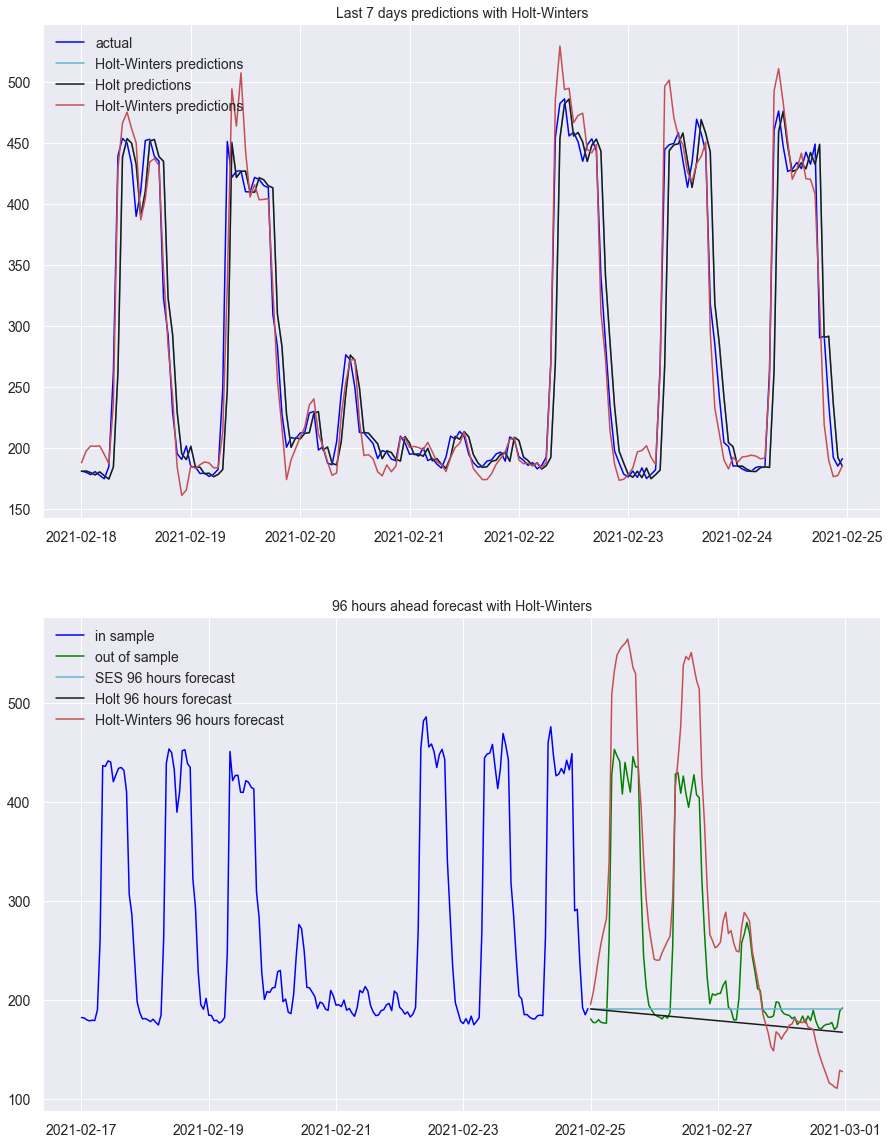

In [32]:
# Render the actual and forecast data for SES, Holt and Holt-Winters

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

start_date = t_target.index[-1] - pd.Timedelta(days=7)
ax1.plot(t_target[t_target.index > start_date], color="blue", label="actual")
ax1.plot(ses_pred[(ses_pred.index > start_date) & (ses_pred.index <= t_target.index[-1])], 
         color="c", label="Holt-Winters predictions")
ax1.plot(holt_pred[(holt_pred.index > start_date) & (holt_pred.index <= t_target.index[-1])], 
         color="k", label="Holt predictions")
ax1.plot(des_pred[(des_pred.index > start_date) & (des_pred.index <= t_target.index[-1])], 
         color="r", label="Holt-Winters predictions")
ax1.set_title("Last 7 days predictions with Holt-Winters")

start_date = t_target.index[-1] - pd.Timedelta(days=8)
ax2.plot(t_target[t_target.index > start_date], color="blue", label="in sample")
ax2.plot(f_target, color="green", label="out of sample")
ax2.plot(ses_fcast, color="c", 
         label=f"SES {FCAST_STEPS} hours forecast")
ax2.plot(holt_fcast, color="k", 
         label=f"Holt {FCAST_STEPS} hours forecast")
ax2.plot(des_fcast, color="r", 
         label=f"Holt-Winters {FCAST_STEPS} hours forecast")
ax2.set_title(f"{FCAST_STEPS} hours ahead forecast with Holt-Winters")

ax1.legend()
ax2.legend()
plt.show()

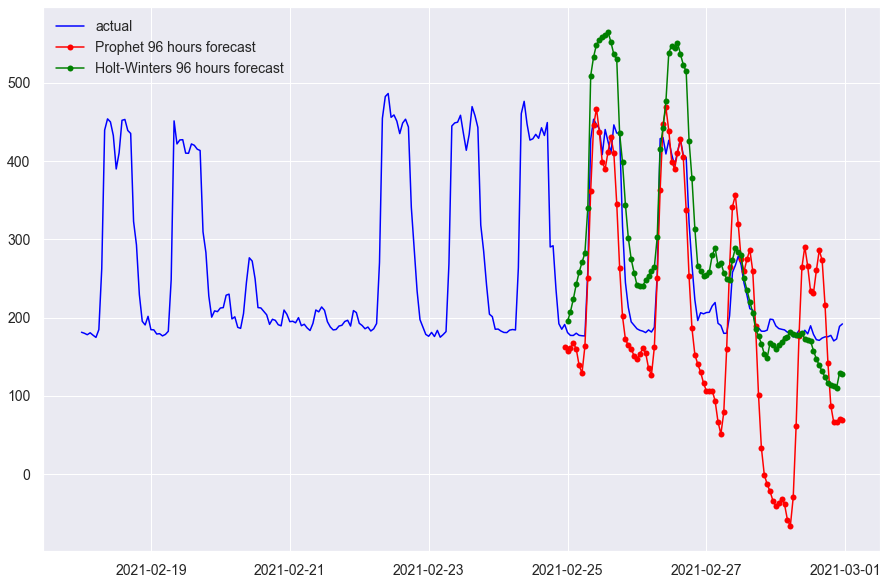

In [33]:
# Render the actual and forecast data for Prophet vs Holt-Winters

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

start_date = t_target.index[-1] - pd.Timedelta(days=7)
ax.plot(c_target[c_target.index > start_date], color="blue", label="actual")
ax.plot(
    prophet_fcast[prophet_fcast.index >= t_target.index[-1]],
    color="red",
    label=f"Prophet {FCAST_STEPS} hours forecast",
    marker="o",
)
ax.plot(
    des_fcast[des_fcast.index >= t_target.index[-1]],
    color="green",
    label=f"Holt-Winters {FCAST_STEPS} hours forecast",
    marker="o",
)

ax.legend()
plt.show()

### Predicting with machine learning: XGBoost model

We are going now to apply standard machine learning technique for forecasting future values of the energy consumption measurements. We choose the XGBoost algorithm which solves multiple decision tree problems using the Gradient Boosting technique. 
XGBoost is fast and accurate compared to other tree-based methods for time series problems.

In [34]:
from functools import partial
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, scale
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, STATUS_FAIL
import xgboost as xgb
from statsmodels.tsa.stattools import pacf, acf

##### Feature Engineering and Transformation

In order to transform a time series forecasting task into a supervised machine learning problem, we create a feature set in which the actual time series values are instead used as labels for the ML model. 
We consider below 3 categories:

* **lag features**: use the original time series itself as feature with a certain shift usually called lag.
* **standard time series features**: standard time series features such as hour, weekend, season and so on.
* **endogoneous features**: endogenous features.


In [35]:
# Define the methods to perfor feature engineering and transformation

def create_lag_features(target, lags=None, thres=0.2):
    scaler = StandardScaler()
    features = pd.DataFrame()
    if lags is None:
        partial = pd.Series(data=pacf(target, nlags=192))
        lags = list(partial[np.abs(partial) >= thres].index)

    df = pd.DataFrame()
    if 0 in lags:
        lags.remove(0)  # do not consider itself as lag feature
    for l in lags:
        df[f"lag_{l}"] = target.shift(l)
    features = pd.DataFrame(scaler.fit_transform(df[df.columns]), columns=df.columns)
    features = df
    features.index = target.index
    return features


def create_ts_features(data):
    def get_shift(row):
        """
        Factory working shift in office:
        working hours 8 ~ 17
        lunch time 11 ~ 13
        turn on hour 07 ~ 08
        turn off hour 18 ~ 20
        non-working hour 20 ~ 07
        """
        if 8 <= row.hour < 17:
            return 1
        elif 11 <= row.hour < 13:
            return 2
        elif 7 <= row.hour < 8:
            return 3
        elif 18 <= row.hour < 20:
            return 4
        else:
            return 5
    features = pd.DataFrame()
    features["hour"] = data.index.hour
    features["weekday"] = data.index.weekday
    features["dayofyear"] = data.index.dayofyear
    features["is_weekend"] = data.index.weekday.isin([5, 6]).astype(np.int32)
    features["weekofyear"] = data.index.weekofyear
    features["month"] = data.index.month
    features["season"] = (data.index.month%12 + 3)//3
    features["shift"] = pd.Series(data.index.map(get_shift))
    features.index = data.index
    return features


def create_endog_features(data):
    scaler = StandardScaler()
    features = pd.DataFrame()
    features["temperature"] = data["temperature"].dropna()
    features["public_holiday"] = data["public_holiday"].dropna()
    features["covid_phases"] = data["covid_phases"].dropna()
    features["primary_school_holiday"] = data["primary_school_holiday"].dropna()
    features["week_days"] = data["week_days"].dropna()
    features["working_day"] = data["working_day"].dropna()
    features.index = data.index
    return features


lags = create_lag_features(c_target, thres=0.2)
ts = create_ts_features(c_target)
orgft = create_endog_features(data)
print(ts.shape)
print(lags.shape)
c_features = ts.join(lags, how="outer").dropna()
c_features = c_features.join(orgft).fillna(method="bfill")
date = c_target.index[-1] - pd.Timedelta(hours=FCAST_STEPS)
features = c_features[c_features.index <= date] # the train and test data with features
f_features = c_features[c_features.index > date] # the FCAST_STEPS period data with features
print(features.shape)
target = t_target[t_target.index >= features.index[0]]
f_target = c_target[c_target.index > date]
print(f_features.shape)


(10080, 8)
(10080, 6)
(9815, 20)
(96, 20)


In order to make the time series easier to digest to the ML model we also apply some standard transformation techniques on the target used for the supervised learning problem.

* **differencing**: take the different with 24 hours lagged time series values. 

* **log transformation**: take the logarithm of the time series to allievate any residual seasonal effect.

* **detrending**: remove linear trend from the time series

The following categories apply these transformations to the general time series provided as input, and implement the inverse transformation to return to the original data after forecasting. The inverse transformation must always be applied in reverse order.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, shuffle=False
)

y_train_trf = TargetTransformer(log=False, detrend=False)
y_train = y_train_trf.transform(y_train.index, y_train.values)

y_test_trf = TargetTransformer(log=False, detrend=False)
y_test = y_test_trf.transform(y_test.index, y_test.values)


In [37]:
# target.tail

## Ridge

Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity. 

Linear Regression MAPE is 18.63%


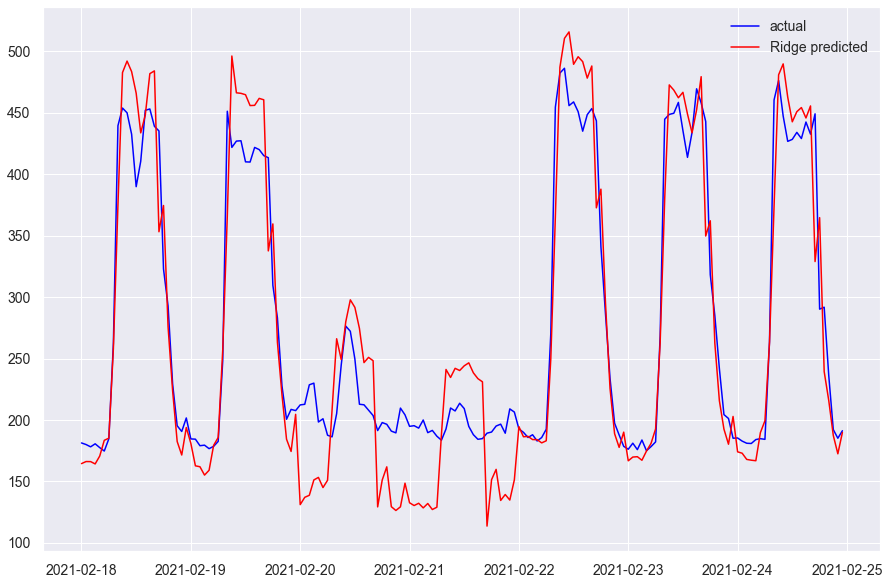

In [38]:
# testing of simple linear regression model for time series analysis


from sklearn.linear_model import Ridge

# machine learning in two lines
lr_model = Ridge(alpha=5)
lr_model.fit(X_train, y_train)

# cross validate using the right iterator for time series
cv_space = TimeSeriesSplit(n_splits=4)
cv_score = cross_val_score(lr_model, X_train, y_train, cv=cv_space, scoring=mape_scorer)

cv_score = np.mean(np.abs(cv_score))
# evaluate the model on the test set
predictions = lr_model.predict(X_test.values)
test_score = mean_squared_error(y_test.values, predictions, squared=False)
print("Linear Regression MAPE is {:.2f}%".format(mape(y_test.values, predictions)))

# plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

y = y_test_trf.inverse(y_test.index, y_test.values)
p = y_test_trf.inverse(y_test.index, predictions)

start_date = y.index[-1] - pd.Timedelta(days=7)
ax.plot(y[y.index > start_date], label="actual", color="blue")
ax.plot(p[p.index > start_date], label="Ridge predicted", color="red")
ax.legend()
plt.show()

# save results for later comparison
forecasting_results["ridge"] = {
    "fcast": p,
    "model": lr_model,
    "mape": mape(y_test.values, predictions), 
    "explained_variance_score": explained_variance_score(y_test.values, predictions),
    "train_mape": cv_score
}


In [39]:
# y.tail

## XGBoost

We use a standard pipeline for training and testing the XGBoost model. The hyperparameters are optimized using Bayesan optimization technique as implemented by the `hyperopt` library. Cross-validation with rolling time window is used as metric for the optimization procedure.

In [40]:
# run XGBoost algorithm with hyperparameters optimization
# this model outperforms the linear regression


def train_xgb(params, X_train, y_train):
    """
    Train XGBoost regressor using the parameters given as input. The model
    is validated using standard cross validation technique adapted for time series
    data. This function returns a friendly output for the hyperopt parameter optimization
    module.

    Parameters
    ----------
    params: dict with the parameters of the XGBoost regressor. For complete list see:
            https://xgboost.readthedocs.io/en/latest/parameter.html
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets

    Returns
    -------
    dict with keys 'model' for the trained model, 'status' containing the hyperopt
    status string and 'loss' with the RMSE obtained from cross-validation
    """

    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])

    try:
        model = xgb.XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=params["learning_rate"],
            subsample=params["subsample"],
        )

        result = model.fit(
            X_train,
            y_train.values.ravel(),
            eval_set=[(X_train, y_train.values.ravel())],
            early_stopping_rounds=50,
            verbose=False,
        )

        # cross validate using the right iterator for time series
        cv_space = TimeSeriesSplit(n_splits=5)
        cv_score = cross_val_score(
            model, X_train, y_train.values.ravel(), cv=cv_space, scoring=mape_scorer
        )

        rmse = np.abs(np.mean(np.array(cv_score)))
        return {"loss": rmse, "status": STATUS_OK, "model": model}

    except ValueError as ex:
        return {"error": ex, "status": STATUS_FAIL}


def optimize_xgb(X_train, y_train, max_evals=10):
    """
    Run Bayesan optimization to find the optimal XGBoost algorithm
    hyperparameters.

    Parameters
    ----------
    X_train: pd.DataFrame with the training set features
    y_train: pd.Series with the training set targets
    max_evals: the maximum number of iterations in the Bayesian optimization method

    Returns
    -------
    best: dict with the best parameters obtained
    trials: a list of hyperopt Trials objects with the history of the optimization
    """

    space = {
        "n_estimators": hp.quniform("n_estimators", 100, 1000, 10),
        "max_depth": hp.quniform("max_depth", 1, 8, 1),
        "learning_rate": hp.loguniform("learning_rate", -5, 1),
        "subsample": hp.uniform("subsample", 0.8, 1),
        "gamma": hp.quniform("gamma", 0, 100, 1),
    }

    objective_fn = partial(train_xgb, X_train=X_train, y_train=y_train)

    trials = Trials()
    best = fmin(
        fn=objective_fn,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials,
    )

    # evaluate the best model on the test set
    print(
        f"""
    Best parameters:
        learning_rate: {best["learning_rate"]} 
        n_estimators: {best["n_estimators"]}
        max_depth: {best["max_depth"]}
        sub_sample: {best["subsample"]}
        gamma: {best["gamma"]}
    """
    )
    return best, trials


# best, trials = optimize_xgb(X_train, y_train, max_evals=50)
best, trials = optimize_xgb(X_train, y_train, max_evals=20)


  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


  5%|██▍                                              | 1/20 [00:07<02:22,  7.49s/trial, best loss: 24.252128694188134]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.252129


 10%|█████                                             | 2/20 [00:19<03:01, 10.09s/trial, best loss: 14.70120676093848]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 14.701207


 15%|███████▌                                          | 3/20 [00:26<02:30,  8.83s/trial, best loss: 12.48308459578195]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 12.483085


 20%|██████████                                        | 4/20 [00:33<02:08,  8.02s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 11.431845


 25%|████████████▌                                     | 5/20 [00:35<01:28,  5.90s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 11.431845


 30%|███████████████                                   | 6/20 [00:51<02:08,  9.16s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 11.431845


 35%|█████████████████▌                                | 7/20 [01:03<02:12, 10.22s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 11.431845


 40%|████████████████████                              | 8/20 [01:17<02:15, 11.30s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 11.431845


 45%|██████████████████████▌                           | 9/20 [01:31<02:15, 12.35s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 11.431845


 50%|████████████████████████▌                        | 10/20 [01:43<02:00, 12.09s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 11.431845


 55%|██████████████████████████▉                      | 11/20 [01:59<02:00, 13.39s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 11.431845


 60%|█████████████████████████████▍                   | 12/20 [02:17<01:58, 14.85s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 11.431845


 65%|███████████████████████████████▊                 | 13/20 [02:22<01:23, 11.88s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 11.431845


 70%|██████████████████████████████████▎              | 14/20 [02:30<01:03, 10.63s/trial, best loss: 11.43184504899491]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 11.431845


 75%|████████████████████████████████████            | 15/20 [03:13<01:41, 20.36s/trial, best loss: 11.017536732583379]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 11.017537


 80%|██████████████████████████████████████▍         | 16/20 [03:34<01:22, 20.59s/trial, best loss: 11.017536732583379]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss 11.017537


 85%|█████████████████████████████████████████▋       | 17/20 [03:47<00:54, 18.30s/trial, best loss: 10.79570699509924]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss 10.795707


 90%|███████████████████████████████████████████▏    | 18/20 [03:57<00:31, 15.82s/trial, best loss: 10.770691095406168]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss 10.770691


 95%|█████████████████████████████████████████████▌  | 19/20 [04:02<00:12, 12.39s/trial, best loss: 10.770691095406168]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss 10.770691


100%|████████████████████████████████████████████████| 20/20 [04:21<00:00, 13.06s/trial, best loss: 10.770691095406168]

    Best parameters:
        learning_rate: 0.01551106417446488 
        n_estimators: 340.0
        max_depth: 7.0
        sub_sample: 0.9441694386766339
        gamma: 80.0
    


In [41]:
# y_train.tail(10)

In [42]:
# evaluate the best model on the test set

res = train_xgb(best, X_test, y_test)
xgb_model = res["model"]
predictions = xgb_model.predict(X_test)
cv_score = min([f["loss"] for f in trials.results if f["status"] == STATUS_OK])
test_score = mape(y_test.values, predictions)
print("XGBoost model MAPE for test is {:.2f}%".format(test_score))

XGBoost model MAPE for test is 2.03%


In [43]:
# evaluate the best model on the future data set

f_predictions = xgb_model.predict(f_features)
test_score = mape(f_target.values, f_predictions)
print("XGBoost model MAPE for forecast is {:.2f}%".format(test_score))

XGBoost model MAPE for forecast is 3.17%


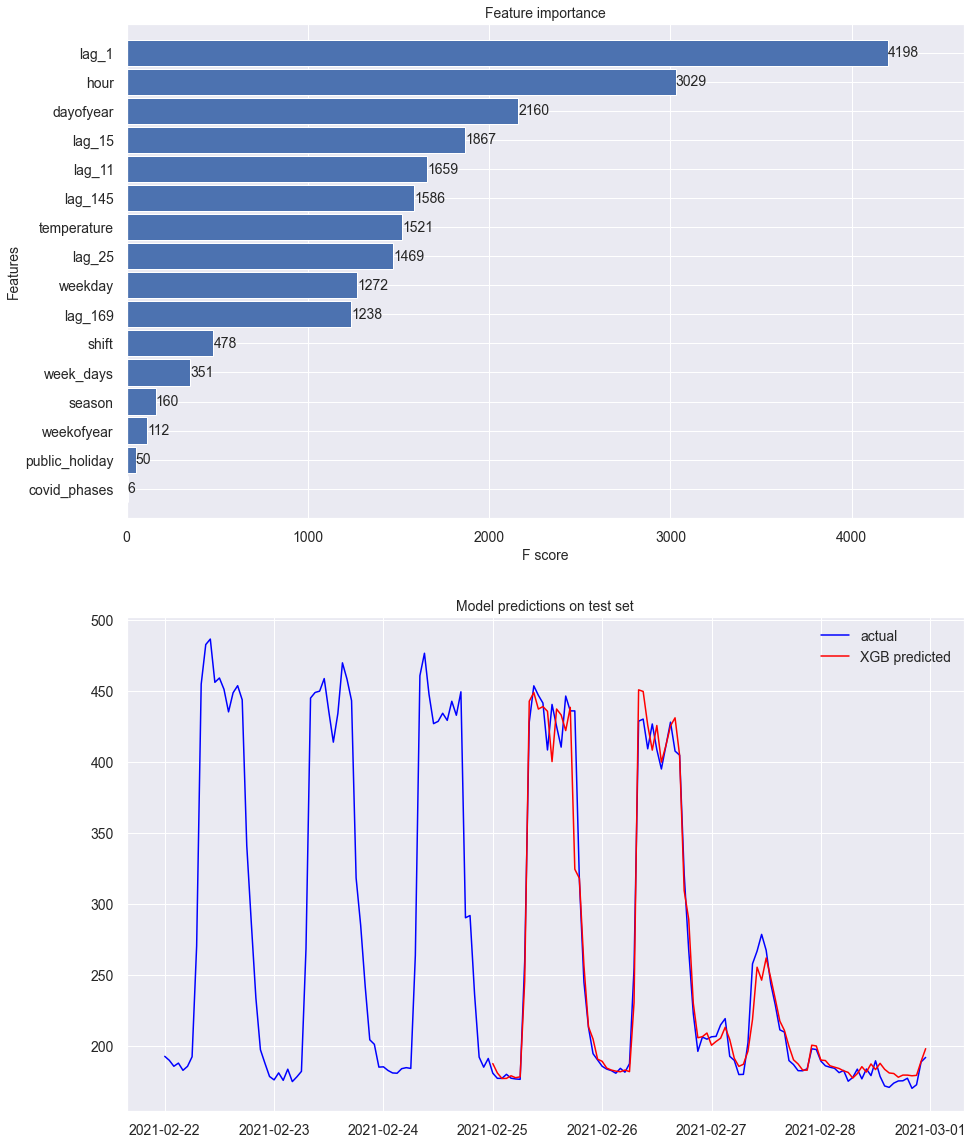

In [44]:

actual = y_test
xgb_predictions = pd.Series(data=f_predictions, index=f_target.index)

# plot predictions on the test set
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,20))
_ = xgb.plot_importance(xgb_model, height=0.9, ax=ax1)

start_date = c_target.index[-1] - pd.Timedelta(days=7)
ax2.plot(c_target[c_target.index > start_date], label="actual", color="blue")
ax2.plot(xgb_predictions[xgb_predictions.index > start_date], label="XGB predicted", color="red")
ax2.set_title("Model predictions on test set")
ax2.legend()
plt.show()

# save results for later comparison
forecasting_results["xgb"] = {
    "fcast": xgb_predictions,
    "model": xgb_model,
    "explained_variance_score": explained_variance_score(y_test.values, predictions),
    "mape": test_score,
    "train_mape": cv_score
}

## Multi-step ahead forecasting

Multi-step Forecasting: is to apply a predictive model step-by-step and use the predicted value of the current time step to determine its value in the next time step, there have various approaches.

* Recursive Strategy
* Direct Strategy
* Hybrid or DirRec Strategy
* Multiple Output Strategies

### Recursive Strategy

In [45]:
# lags used in building the features for the one-step ahead model
feature_lags = [int(f.split("_")[1]) for f in features if "lag" in f]

# target series used for forecasting
fcast_trf = TargetTransformer(log=False, detrend=False)
y = fcast_trf.transform(target.index, target.values)


In [46]:
def forecast_multi_recursive(y, model, lags, n_steps=FCAST_STEPS, step="1H"):

    """Multi-step recursive forecasting using the input time
    series data and a pre-trained machine learning model

    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    model: an already trained machine learning model implementing the scikit-learn interface
    lags: list of lags used for training the model
    n_steps: number of time periods in the forecasting horizon
    step: forecasting time period given as Pandas time series frequencies

    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates
    """

    # get the dates to forecast
    last_date = y.index[-1] + pd.Timedelta(hours=1)
    fcast_range = pd.date_range(last_date, periods=n_steps, freq=step)

    fcasted_values = []
    target = y.copy()

    for date in fcast_range:

        new_point = fcasted_values[-1] if len(fcasted_values) > 0 else 0.0
        target = target.append(pd.Series(index=[date], data=new_point))

        # forecast
        ts_features = create_ts_features(target)
        if len(lags) > 0:
            lags_features = create_lag_features(target, lags=lags)
            features = ts_features.join(lags_features, how="outer").dropna()
        else:
            features = ts_features

        features = features.join(orgft).fillna(method="bfill")
        predictions = model.predict(features)
        fcasted_values.append(predictions[-1])

    return pd.Series(index=fcast_range, data=fcasted_values)


rec_fcast = forecast_multi_recursive(y, xgb_model, feature_lags)



### Direct strategy

The direct forecasting strategy uses a different ML model for each forecasting horizon. More specifically, each model is trained using as target the time series shifted of the desired number of time periods into the future. 

In [47]:
features.tail(10)

hour  weekday  dayofyear  is_weekend  weekofyear  month  \
localtime                                                                      
2021-02-24 14:00:00    14        2         55           0           8      2   
2021-02-24 15:00:00    15        2         55           0           8      2   
2021-02-24 16:00:00    16        2         55           0           8      2   
2021-02-24 17:00:00    17        2         55           0           8      2   
2021-02-24 18:00:00    18        2         55           0           8      2   
2021-02-24 19:00:00    19        2         55           0           8      2   
2021-02-24 20:00:00    20        2         55           0           8      2   
2021-02-24 21:00:00    21        2         55           0           8      2   
2021-02-24 22:00:00    22        2         55           0           8      2   
2021-02-24 23:00:00    23        2         55           0           8      2   

                     season  shift       lag_1      lag_11      lag_15  \
localtime                                                                
2021-02-24 14:00:00       1      1  434.080893  180.886381  185.181746   
2021-02-24 15:00:00       1      1  429.064697  184.080362  185.388831   
2021-02-24 16:00:00       1      1  442.496539  184.805822  182.825772   
2021-02-24 17:00:00       1      5  432.655314  184.261629  181.085531   
2021-02-24 18:00:00       1      4  449.173723  263.757336  180.886381   
2021-02-24 19:00:00       1      4  290.215469  460.467895  184.080362   
2021-02-24 20:00:00       1      5  291.797513  476.273258  184.805822   
2021-02-24 21:00:00       1      5  236.360338  447.363884  184.261629   
2021-02-24 22:00:00       1      5  192.229253  426.768575  263.757336   
2021-02-24 23:00:00       1      5  185.154016  428.381805  460.467895   

                         lag_25     lag_145     lag_169  temperature  \
localtime                                                              
2021-02-24 14:00:00  413.748159  410.595856  427.907898    29.416667   
2021-02-24 15:00:00  434.025490  452.038681  434.310413    29.033333   
2021-02-24 16:00:00  469.539419  453.118084  435.076378    26.600000   
2021-02-24 17:00:00  458.057251  439.036102  432.193824    27.716667   
2021-02-24 18:00:00  442.935608  435.232071  410.732705    27.883333   
2021-02-24 19:00:00  318.260766  322.853390  306.929089    26.966667   
2021-02-24 20:00:00  284.963400  292.848067  286.267615    26.200000   
2021-02-24 21:00:00  241.725279  229.347218  241.060182    25.850000   
2021-02-24 22:00:00  204.394905  195.319234  197.961756    25.400000   
2021-02-24 23:00:00  201.233602  190.649958  187.176655    25.150000   

                     public_holiday  covid_phases  primary_school_holiday  \
localtime                                                                   
2021-02-24 14:00:00             0.0           3.0                     0.0   
2021-02-24 15:00:00             0.0           3.0                     0.0   
2021-02-24 16:00:00             0.0           3.0                     0.0   
2021-02-24 17:00:00             0.0           3.0                     0.0   
2021-02-24 18:00:00             0.0           3.0                     0.0   
2021-02-24 19:00:00             0.0           3.0                     0.0   
2021-02-24 20:00:00             0.0           3.0                     0.0   
2021-02-24 21:00:00             0.0           3.0                     0.0   
2021-02-24 22:00:00             0.0           3.0                     0.0   
2021-02-24 23:00:00             0.0           3.0                     0.0   

                     week_days  working_day  
localtime                                    
2021-02-24 14:00:00        3.0          1.0  
2021-02-24 15:00:00        3.0          1.0  
2021-02-24 16:00:00        3.0          1.0  
2021-02-24 17:00:00        3.0          1.0  
2021-02-24 18:00:00        3.0          1.0  
2021-02-24 19:00:00        3.0          1.0  
2021-02-24 20

In [48]:
def forecast_multi_direct(y, lags, n_steps=FCAST_STEPS, step="1H", pretrained_m=None, n_evals=25):
    
    """Multi-step direct forecasting using a XGBoost based machine learning model
    to forecast each time period ahead
    
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    lags: list of lags used for training the model
    n_steps: how many steps forecast into the future
    step: the period of forecasting
    pretrained_m: a pretrained one-step ahead model to be used for the first step
                  it must implement the scikit-learn model interface
    n_evals: the number of evaluation in model optimization at each step
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values indexed by forecast horizon dates    
    """
    
    def one_step_features(date, step):

        # features must be obtained using data lagged 
        # by the desired number of steps (the for loop index)
        tmp = y[y.index <= date]       
        lags_features = create_lag_features(tmp, lags=lags)
        ts_features = create_ts_features(tmp)
        features = ts_features.join(lags_features, how="outer").dropna()
        
        features = features.join(orgft).fillna(method='bfill')
        
        # build target to be ahead of the features built 
        # by the desired number of steps (the for loop index)
        target = y[y.index >= features.index[0] + pd.Timedelta(hours=step)]
        assert len(features.index) == len(target.index)
        
        print("one_step_features for date ",date, " and step ",step)
        
        return features, target
        
    fcast_values = []
    fcast_range = pd.date_range(y.index[-1] + pd.Timedelta(hours=1), 
                                periods=n_steps, freq=step)
    fcast_features, _ = one_step_features(y.index[-1], 0)
            
    for s in range(1, n_steps+1):
        
        last_date = y.index[-1] - pd.Timedelta(hours=s)
        features, target = one_step_features(last_date, s)
        
        # train XGBoost model for the current forecasting step
        X_train, X_test, y_train, y_test = train_test_split(features, 
                                                            target, 
                                                            test_size=0.2,
                                                            shuffle=False) 

        y_train_trf = TargetTransformer(log=False, detrend=False)
        y_train = y_train_trf.transform(y_train.index, y_train.values)

        y_test_trf = TargetTransformer(log=False, detrend=False)
        y_test = y_test_trf.transform(y_test.index, y_test.values)        
        
        # use the pretrained model to save one model training
        if s == 1 and pretrained_m is not None:
            model = pretrained_m
        else:
            best, trials = optimize_xgb(X_train, y_train, max_evals=n_evals)
            res = train_xgb(best, X_test, y_test)
            model = res["model"]
            print("forecast_multi_direct completed for step", s, "and the loss is ", res["loss"], " , data last date ", last_date)
        
        # use the model to predict s steps ahead
        predictions = model.predict(fcast_features)        
        fcast_values.append(predictions[-1])
                
    return pd.Series(index=fcast_range, data=fcast_values)

# Chose the number of evaluation in model optimization at each step
# dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=50)
dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=10)
# dir_fcast = forecast_multi_direct(y, feature_lags, n_evals=2)

one_step_features for date  2021-02-24 23:00:00  and step  0
one_step_features for date  2021-02-24 22:00:00  and step  1
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:07<01:10,  7.79s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 14.133821


 20%|█████████▊                                       | 2/10 [00:15<01:01,  7.68s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 14.133821


 30%|██████████████▋                                  | 3/10 [00:29<01:13, 10.45s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003031 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 14.133821


 40%|███████████████████▌                             | 4/10 [00:33<00:48,  8.07s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 14.133821


 50%|████████████████████████▌                        | 5/10 [00:50<00:56, 11.26s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 14.133821


 60%|█████████████████████████████▍                   | 6/10 [00:51<00:31,  7.82s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 14.133821


 70%|██████████████████████████████████▎              | 7/10 [00:58<00:22,  7.50s/trial, best loss: 14.133821262310272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 14.133821


 80%|███████████████████████████████████████▏         | 8/10 [01:22<00:25, 12.68s/trial, best loss: 11.546122117788016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 11.546122


 90%|████████████████████████████████████████████     | 9/10 [01:46<00:16, 16.41s/trial, best loss: 11.546122117788016]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 11.546122


100%|████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.09s/trial, best loss: 11.546122117788016]

    Best parameters:
        learning_rate: 0.01737232393944087 
        n_estimators: 650.0
        max_depth: 8.0
        sub_sample: 0.8121406147414114
        gamma: 68.0
    
forecast_multi_direct completed for step 1 and the loss is  9.598486054482526  , data last date  2021-02-24 22:00:00
one_step_features for date  2021-02-24 21:00:00  and step  2
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:02<00:22,  2.52s/trial, best loss: 36.25542506956192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 36.255425


 20%|█████████▊                                       | 2/10 [00:12<00:55,  6.93s/trial, best loss: 17.830991932990123]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 17.830992


 30%|██████████████▋                                  | 3/10 [00:14<00:31,  4.55s/trial, best loss: 17.830991932990123]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 17.830992


 40%|███████████████████▌                             | 4/10 [00:29<00:52,  8.68s/trial, best loss: 17.830991932990123]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 17.830992


 50%|████████████████████████▌                        | 5/10 [01:13<01:47, 21.51s/trial, best loss: 15.009449985890253]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 15.009450


 60%|█████████████████████████████▍                   | 6/10 [01:21<01:07, 16.89s/trial, best loss: 15.009449985890253]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/6 trials with best loss 15.009450


 70%|██████████████████████████████████▎              | 7/10 [01:36<00:49, 16.36s/trial, best loss: 15.009449985890253]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 5/7 trials with best loss 15.009450


 80%|███████████████████████████████████████▏         | 8/10 [01:39<00:24, 12.15s/trial, best loss: 15.009449985890253]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 15.009450


 90%|████████████████████████████████████████████     | 9/10 [01:44<00:09,  9.76s/trial, best loss: 15.009449985890253]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 15.009450


100%|████████████████████████████████████████████████| 10/10 [01:50<00:00, 11.00s/trial, best loss: 13.436741021016124]

    Best parameters:
        learning_rate: 0.03703685141545267 
        n_estimators: 160.0
        max_depth: 7.0
        sub_sample: 0.9499897569109695
        gamma: 42.0
    
forecast_multi_direct completed for step 2 and the loss is  12.212218885634675  , data last date  2021-02-24 21:00:00
one_step_features for date  2021-02-24 20:00:00  and step  3
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:20<03:03, 20.33s/trial, best loss: 19.93488712532761]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 19.934887


 20%|██████████                                        | 2/10 [00:27<01:41, 12.72s/trial, best loss: 19.93488712532761]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 19.934887


 30%|██████████████▋                                  | 3/10 [00:51<02:03, 17.67s/trial, best loss: 17.416144372552143]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 17.416144


 40%|███████████████████▌                             | 4/10 [00:56<01:17, 12.88s/trial, best loss: 17.122619799970852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002509 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 17.122620


 50%|█████████████████████████                         | 5/10 [01:14<01:13, 14.69s/trial, best loss: 16.23149589787173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 16.231496


 60%|██████████████████████████████                    | 6/10 [01:20<00:46, 11.74s/trial, best loss: 16.23149589787173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 16.231496


 70%|███████████████████████████████████               | 7/10 [01:30<00:33, 11.11s/trial, best loss: 16.23149589787173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 16.231496


 80%|████████████████████████████████████████          | 8/10 [01:36<00:19,  9.52s/trial, best loss: 16.23149589787173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 16.231496


 90%|█████████████████████████████████████████████     | 9/10 [01:39<00:07,  7.28s/trial, best loss: 16.23149589787173]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 16.231496


100%|█████████████████████████████████████████████████| 10/10 [01:40<00:00, 10.04s/trial, best loss: 16.23149589787173]

    Best parameters:
        learning_rate: 0.09230931729450408 
        n_estimators: 570.0
        max_depth: 7.0
        sub_sample: 0.895081559116771
        gamma: 86.0
    
forecast_multi_direct completed for step 3 and the loss is  11.839153661821594  , data last date  2021-02-24 20:00:00
one_step_features for date  2021-02-24 19:00:00  and step  4
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:05<00:46,  5.20s/trial, best loss: 22.661824686640692]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.661825


 20%|█████████▊                                       | 2/10 [00:09<00:39,  4.93s/trial, best loss: 18.967561428118604]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 18.967561


 30%|██████████████▋                                  | 3/10 [00:25<01:10, 10.00s/trial, best loss: 18.967561428118604]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 18.967561


 40%|███████████████████▌                             | 4/10 [00:34<00:55,  9.27s/trial, best loss: 18.967561428118604]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.967561


 50%|████████████████████████▌                        | 5/10 [00:42<00:45,  9.06s/trial, best loss: 15.459252443318892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 15.459252


 60%|█████████████████████████████▍                   | 6/10 [00:56<00:43, 10.80s/trial, best loss: 15.459252443318892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 15.459252


 70%|██████████████████████████████████▎              | 7/10 [01:12<00:37, 12.40s/trial, best loss: 15.459252443318892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 15.459252


 80%|███████████████████████████████████████▏         | 8/10 [01:21<00:22, 11.37s/trial, best loss: 15.459252443318892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 15.459252


 90%|████████████████████████████████████████████     | 9/10 [01:30<00:10, 10.52s/trial, best loss: 15.459252443318892]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 15.459252


100%|████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.35s/trial, best loss: 15.459252443318892]

    Best parameters:
        learning_rate: 0.02464105861538817 
        n_estimators: 270.0
        max_depth: 7.0
        sub_sample: 0.861213248592802
        gamma: 3.0
    
forecast_multi_direct completed for step 4 and the loss is  12.270118932379967  , data last date  2021-02-24 19:00:00
one_step_features for date  2021-02-24 18:00:00  and step  5
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:07<01:07,  7.45s/trial, best loss: 42.455297256009885]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 42.455297


 20%|█████████▊                                       | 2/10 [00:20<01:28, 11.04s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 15.613436


 30%|██████████████▋                                  | 3/10 [00:23<00:50,  7.17s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 15.613436


 40%|███████████████████▌                             | 4/10 [00:38<01:01, 10.28s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 15.613436


 50%|████████████████████████▌                        | 5/10 [00:40<00:36,  7.32s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 15.613436


 60%|█████████████████████████████▍                   | 6/10 [00:48<00:29,  7.41s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 15.613436


 70%|██████████████████████████████████▎              | 7/10 [01:05<00:31, 10.53s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 15.613436


 80%|███████████████████████████████████████▏         | 8/10 [01:15<00:21, 10.53s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 15.613436


 90%|████████████████████████████████████████████     | 9/10 [01:28<00:11, 11.35s/trial, best loss: 15.613436019551804]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 15.613436


100%|████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.96s/trial, best loss: 15.613436019551804]

    Best parameters:
        learning_rate: 0.0092861401625881 
        n_estimators: 420.0
        max_depth: 7.0
        sub_sample: 0.9873409323434407
        gamma: 59.0
    
forecast_multi_direct completed for step 5 and the loss is  17.023235043023327  , data last date  2021-02-24 18:00:00
one_step_features for date  2021-02-24 17:00:00  and step  6
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001971 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:11<01:40, 11.12s/trial, best loss: 24.016444908904013]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.016445


 20%|█████████▊                                       | 2/10 [00:15<00:57,  7.15s/trial, best loss: 24.016444908904013]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.016445


 30%|██████████████▋                                  | 3/10 [00:25<01:00,  8.61s/trial, best loss: 23.439009624409167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 23.439010


 40%|███████████████████▌                             | 4/10 [00:37<00:58,  9.69s/trial, best loss: 23.439009624409167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.439010


 50%|████████████████████████▌                        | 5/10 [00:45<00:46,  9.31s/trial, best loss: 23.439009624409167]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.439010


 60%|██████████████████████████████▌                    | 6/10 [00:54<00:37,  9.25s/trial, best loss: 15.9957815811705]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 15.995782


 70%|███████████████████████████████████▋               | 7/10 [01:09<00:33, 11.11s/trial, best loss: 15.9957815811705]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 15.995782


 80%|████████████████████████████████████████▊          | 8/10 [01:24<00:24, 12.22s/trial, best loss: 15.9957815811705]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 15.995782


 90%|█████████████████████████████████████████████▉     | 9/10 [01:46<00:15, 15.29s/trial, best loss: 15.9957815811705]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 15.995782


100%|██████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.78s/trial, best loss: 15.9957815811705]

    Best parameters:
        learning_rate: 0.0277630677260124 
        n_estimators: 280.0
        max_depth: 7.0
        sub_sample: 0.8527142897829945
        gamma: 66.0
    
forecast_multi_direct completed for step 6 and the loss is  16.14263091610358  , data last date  2021-02-24 17:00:00
one_step_features for date  2021-02-24 16:00:00  and step  7
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:03<00:32,  3.59s/trial, best loss: 22.76610512377301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.766105


 20%|██████████                                        | 2/10 [00:13<00:58,  7.28s/trial, best loss: 22.76610512377301]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.766105


 30%|██████████████▋                                  | 3/10 [00:41<01:57, 16.77s/trial, best loss: 15.601757055908848]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 15.601757


 40%|███████████████████▌                             | 4/10 [00:47<01:14, 12.37s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 15.405904


 50%|████████████████████████▌                        | 5/10 [00:52<00:48,  9.77s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 15.405904


 60%|█████████████████████████████▍                   | 6/10 [01:01<00:38,  9.70s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 15.405904


 70%|██████████████████████████████████▎              | 7/10 [01:09<00:26,  8.92s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 15.405904


 80%|███████████████████████████████████████▏         | 8/10 [01:25<00:22, 11.26s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 15.405904


 90%|████████████████████████████████████████████     | 9/10 [01:33<00:10, 10.22s/trial, best loss: 15.405903874110404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 15.405904


100%|████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.54s/trial, best loss: 15.405903874110404]

    Best parameters:
        learning_rate: 0.029844758817357334 
        n_estimators: 180.0
        max_depth: 7.0
        sub_sample: 0.8196166513890937
        gamma: 30.0
    
forecast_multi_direct completed for step 7 and the loss is  13.071236037973978  , data last date  2021-02-24 16:00:00
one_step_features for date  2021-02-24 15:00:00  and step  8
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:09<01:24,  9.41s/trial, best loss: 21.162621788265902]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.162622


 20%|██████████                                        | 2/10 [00:28<02:01, 15.23s/trial, best loss: 18.94137886569918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 18.941379


 30%|███████████████                                   | 3/10 [00:36<01:22, 11.73s/trial, best loss: 18.94137886569918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 18.941379


 40%|████████████████████                              | 4/10 [00:40<00:53,  8.91s/trial, best loss: 18.94137886569918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.941379


 50%|█████████████████████████                         | 5/10 [00:45<00:37,  7.49s/trial, best loss: 18.94137886569918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 18.941379


 60%|██████████████████████████████                    | 6/10 [00:54<00:32,  8.04s/trial, best loss: 18.94137886569918]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 18.941379


 70%|██████████████████████████████████▎              | 7/10 [01:55<01:15, 25.06s/trial, best loss: 16.002882454436783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 16.002882


 80%|███████████████████████████████████████▏         | 8/10 [02:15<00:47, 23.63s/trial, best loss: 16.002882454436783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 16.002882


 90%|████████████████████████████████████████████     | 9/10 [02:18<00:17, 17.30s/trial, best loss: 16.002882454436783]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007005 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 16.002882


100%|████████████████████████████████████████████████| 10/10 [02:58<00:00, 17.90s/trial, best loss: 16.002882454436783]

    Best parameters:
        learning_rate: 0.17170897162447507 
        n_estimators: 730.0
        max_depth: 7.0
        sub_sample: 0.9957757987346821
        gamma: 94.0
    
forecast_multi_direct completed for step 8 and the loss is  13.409352268952858  , data last date  2021-02-24 15:00:00
one_step_features for date  2021-02-24 14:00:00  and step  9
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [01:09<10:24, 69.35s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 16.085006


 20%|█████████▊                                       | 2/10 [01:38<06:03, 45.43s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 16.085006


 30%|██████████████▋                                  | 3/10 [01:46<03:19, 28.51s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 16.085006


 40%|███████████████████▌                             | 4/10 [01:51<01:56, 19.35s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 16.085006


 50%|████████████████████████▌                        | 5/10 [02:10<01:35, 19.14s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 16.085006


 60%|█████████████████████████████▍                   | 6/10 [02:33<01:22, 20.53s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 16.085006


 70%|██████████████████████████████████▎              | 7/10 [03:04<01:11, 23.96s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 16.085006


 80%|███████████████████████████████████████▏         | 8/10 [03:14<00:38, 19.38s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008001 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 16.085006


 90%|████████████████████████████████████████████     | 9/10 [03:19<00:15, 15.03s/trial, best loss: 16.085005500164847]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 16.085006


100%|████████████████████████████████████████████████| 10/10 [03:39<00:00, 21.95s/trial, best loss: 16.085005500164847]

    Best parameters:
        learning_rate: 0.0095505956039078 
        n_estimators: 920.0
        max_depth: 7.0
        sub_sample: 0.9483101790283104
        gamma: 64.0
    
forecast_multi_direct completed for step 9 and the loss is  15.63349636533034  , data last date  2021-02-24 14:00:00
one_step_features for date  2021-02-24 13:00:00  and step  10
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:47<07:09, 47.72s/trial, best loss: 42.59076794409064]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003995 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 42.590768


 20%|█████████▊                                       | 2/10 [00:56<03:17, 24.68s/trial, best loss: 33.382794326554205]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 33.382794


 30%|██████████████▋                                  | 3/10 [01:06<02:07, 18.17s/trial, best loss: 24.696465209107863]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.696465


 40%|███████████████████▌                             | 4/10 [01:29<01:59, 19.96s/trial, best loss: 19.396972122059125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 19.396972


 50%|████████████████████████▌                        | 5/10 [01:36<01:16, 15.39s/trial, best loss: 19.396972122059125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006004 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 19.396972


 60%|█████████████████████████████▍                   | 6/10 [01:50<00:59, 14.77s/trial, best loss: 19.396972122059125]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 4/6 trials with best loss 19.396972


 70%|███████████████████████████████████               | 7/10 [02:22<01:01, 20.64s/trial, best loss: 16.73635923627375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 5/7 trials with best loss 16.736359


 80%|████████████████████████████████████████          | 8/10 [02:30<00:32, 16.47s/trial, best loss: 16.73635923627375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007998 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 16.736359


 90%|█████████████████████████████████████████████     | 9/10 [02:39<00:14, 14.27s/trial, best loss: 16.73635923627375]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 16.736359


100%|█████████████████████████████████████████████████| 10/10 [03:00<00:00, 18.01s/trial, best loss: 16.73635923627375]

    Best parameters:
        learning_rate: 0.010900580289220403 
        n_estimators: 480.0
        max_depth: 7.0
        sub_sample: 0.8085594557962047
        gamma: 6.0
    
forecast_multi_direct completed for step 10 and the loss is  12.751583092760589  , data last date  2021-02-24 13:00:00
one_step_features for date  2021-02-24 12:00:00  and step  11
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003005 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:31<04:40, 31.14s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 17.618492


 20%|█████████▊                                       | 2/10 [01:28<06:10, 46.29s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 17.618492


 30%|██████████████▋                                  | 3/10 [01:59<04:37, 39.63s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 17.618492


 40%|███████████████████▌                             | 4/10 [02:13<02:57, 29.55s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 17.618492


 50%|████████████████████████▌                        | 5/10 [02:32<02:08, 25.76s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 17.618492


 60%|█████████████████████████████▍                   | 6/10 [03:26<02:21, 35.36s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003520 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 17.618492


 70%|██████████████████████████████████▎              | 7/10 [03:43<01:27, 29.24s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 17.618492


 80%|███████████████████████████████████████▏         | 8/10 [04:15<01:00, 30.08s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 17.618492


 90%|████████████████████████████████████████████     | 9/10 [04:47<00:30, 30.67s/trial, best loss: 17.618492255217063]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 17.618492


100%|████████████████████████████████████████████████| 10/10 [04:52<00:00, 29.21s/trial, best loss: 17.618492255217063]

    Best parameters:
        learning_rate: 0.009134532742261852 
        n_estimators: 440.0
        max_depth: 7.0
        sub_sample: 0.948399594944797
        gamma: 65.0
    
forecast_multi_direct completed for step 11 and the loss is  13.958972175561694  , data last date  2021-02-24 12:00:00
one_step_features for date  2021-02-24 11:00:00  and step  12
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:46<06:57, 46.40s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 19.477004


 20%|█████████▊                                       | 2/10 [00:55<03:17, 24.72s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 19.477004


 30%|██████████████▋                                  | 3/10 [01:04<02:02, 17.48s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 19.477004


 40%|███████████████████▌                             | 4/10 [01:33<02:10, 21.80s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 19.477004


 50%|████████████████████████▌                        | 5/10 [01:53<01:46, 21.27s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 19.477004


 60%|█████████████████████████████▍                   | 6/10 [02:07<01:15, 18.87s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005995 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 19.477004


 70%|██████████████████████████████████▎              | 7/10 [02:19<00:49, 16.55s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 19.477004


 80%|███████████████████████████████████████▏         | 8/10 [02:33<00:31, 15.80s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 19.477004


 90%|████████████████████████████████████████████     | 9/10 [03:32<00:29, 29.23s/trial, best loss: 19.477004227655666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 19.477004


100%|█████████████████████████████████████████████████| 10/10 [03:38<00:00, 21.88s/trial, best loss: 19.42663281473926]

    Best parameters:
        learning_rate: 0.03729515873316734 
        n_estimators: 150.0
        max_depth: 4.0
        sub_sample: 0.8787737923949215
        gamma: 21.0
    
forecast_multi_direct completed for step 12 and the loss is  16.761474275526098  , data last date  2021-02-24 11:00:00
one_step_features for date  2021-02-24 10:00:00  and step  13
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003006 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|██████▋                                                            | 1/10 [00:13<02:05, 13.90s/trial, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██████████                                        | 2/10 [00:43<03:05, 23.21s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 16.438075


 30%|███████████████                                   | 3/10 [01:03<02:30, 21.53s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 16.438075


 40%|████████████████████                              | 4/10 [01:06<01:25, 14.23s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 16.438075


 50%|█████████████████████████                         | 5/10 [01:46<01:57, 23.51s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 16.438075


 60%|██████████████████████████████                    | 6/10 [02:11<01:36, 24.17s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 16.438075


 70%|███████████████████████████████████               | 7/10 [02:16<00:53, 17.85s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 5/7 trials with best loss 16.438075


 80%|████████████████████████████████████████          | 8/10 [02:36<00:36, 18.41s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 16.438075


 90%|█████████████████████████████████████████████     | 9/10 [03:05<00:21, 21.92s/trial, best loss: 16.43807504978887]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 16.438075


100%|█████████████████████████████████████████████████| 10/10 [03:57<00:00, 23.80s/trial, best loss: 16.43807504978887]

    Best parameters:
        learning_rate: 0.046192044595281125 
        n_estimators: 370.0
        max_depth: 8.0
        sub_sample: 0.9615251669143543
        gamma: 54.0
    
forecast_multi_direct completed for step 13 and the loss is  14.374533158843656  , data last date  2021-02-24 10:00:00
one_step_features for date  2021-02-24 09:00:00  and step  14
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005041 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:35<05:23, 35.97s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 17.178450


 20%|██████████                                        | 2/10 [01:19<05:22, 40.29s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 17.178450


 30%|███████████████                                   | 3/10 [01:30<03:07, 26.80s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 17.178450


 40%|████████████████████                              | 4/10 [01:59<02:48, 28.05s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 17.178450


 50%|█████████████████████████                         | 5/10 [02:08<01:45, 21.12s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 17.178450


 60%|██████████████████████████████                    | 6/10 [02:17<01:07, 16.86s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 17.178450


 70%|███████████████████████████████████               | 7/10 [03:03<01:19, 26.54s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 17.178450


 80%|████████████████████████████████████████          | 8/10 [03:22<00:48, 24.11s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 17.178450


 90%|█████████████████████████████████████████████     | 9/10 [03:25<00:17, 17.53s/trial, best loss: 17.17845008036779]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 17.178450


100%|█████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.05s/trial, best loss: 17.17845008036779]

    Best parameters:
        learning_rate: 0.009019864792061629 
        n_estimators: 500.0
        max_depth: 7.0
        sub_sample: 0.8167422561034401
        gamma: 16.0
    
forecast_multi_direct completed for step 14 and the loss is  13.409692249426158  , data last date  2021-02-24 09:00:00
one_step_features for date  2021-02-24 08:00:00  and step  15
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002995 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:22<03:20, 22.24s/trial, best loss: 556.0178836213613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 556.017884


 20%|█████████▊                                       | 2/10 [00:42<02:49, 21.21s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 17.350906


 30%|██████████████▋                                  | 3/10 [00:51<01:49, 15.60s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 17.350906


 40%|███████████████████▌                             | 4/10 [00:56<01:07, 11.25s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 17.350906


 50%|████████████████████████▌                        | 5/10 [01:02<00:47,  9.40s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006593 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 17.350906


 60%|█████████████████████████████▍                   | 6/10 [01:06<00:30,  7.58s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 17.350906


 70%|██████████████████████████████████▎              | 7/10 [01:23<00:32, 10.81s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 17.350906


 80%|███████████████████████████████████████▏         | 8/10 [01:29<00:18,  9.01s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007006 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 17.350906


 90%|████████████████████████████████████████████     | 9/10 [01:48<00:12, 12.33s/trial, best loss: 17.350906325396192]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 17.350906


100%|████████████████████████████████████████████████| 10/10 [02:17<00:00, 13.71s/trial, best loss: 17.350906325396192]

    Best parameters:
        learning_rate: 0.012333386874618992 
        n_estimators: 350.0
        max_depth: 6.0
        sub_sample: 0.8631509342569544
        gamma: 60.0
    
forecast_multi_direct completed for step 15 and the loss is  12.688993494698627  , data last date  2021-02-24 08:00:00
one_step_features for date  2021-02-24 07:00:00  and step  16
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004995 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:50<07:31, 50.16s/trial, best loss: 20.59065511475159]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 20.590655


 20%|██████████                                        | 2/10 [01:12<04:29, 33.68s/trial, best loss: 20.59065511475159]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.590655


 30%|██████████████▋                                  | 3/10 [01:56<04:29, 38.57s/trial, best loss: 20.534532169650237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.534532


 40%|███████████████████▌                             | 4/10 [02:04<02:38, 26.43s/trial, best loss: 20.534532169650237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.534532


 50%|█████████████████████████                         | 5/10 [02:12<01:39, 19.86s/trial, best loss: 18.42087775739113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 18.420878


 60%|██████████████████████████████                    | 6/10 [02:56<01:52, 28.02s/trial, best loss: 18.42087775739113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 18.420878


 70%|███████████████████████████████████               | 7/10 [03:07<01:07, 22.36s/trial, best loss: 18.42087775739113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 18.420878


 80%|████████████████████████████████████████          | 8/10 [03:39<00:51, 25.59s/trial, best loss: 18.42087775739113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 18.420878


 90%|█████████████████████████████████████████████     | 9/10 [03:57<00:23, 23.11s/trial, best loss: 18.42087775739113]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 18.420878


100%|█████████████████████████████████████████████████| 10/10 [04:35<00:00, 27.52s/trial, best loss: 18.42087775739113]

    Best parameters:
        learning_rate: 0.0579875871698102 
        n_estimators: 260.0
        max_depth: 6.0
        sub_sample: 0.9811368227330766
        gamma: 59.0
    
forecast_multi_direct completed for step 16 and the loss is  13.615236826744981  , data last date  2021-02-24 07:00:00
one_step_features for date  2021-02-24 06:00:00  and step  17
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002945 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:31<04:44, 31.66s/trial, best loss: 18.870473327079775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 18.870473


 20%|█████████▊                                       | 2/10 [00:43<02:38, 19.81s/trial, best loss: 18.870473327079775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 18.870473


 30%|██████████████▋                                  | 3/10 [01:13<02:53, 24.81s/trial, best loss: 18.870473327079775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 18.870473


 40%|███████████████████▌                             | 4/10 [01:25<01:58, 19.73s/trial, best loss: 18.870473327079775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.870473


 50%|████████████████████████▌                        | 5/10 [01:37<01:23, 16.66s/trial, best loss: 18.870473327079775]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 18.870473


 60%|██████████████████████████████                    | 6/10 [01:47<00:57, 14.43s/trial, best loss: 18.79183926258093]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 18.791839


 70%|██████████████████████████████████▎              | 7/10 [02:26<01:07, 22.51s/trial, best loss: 17.839452304705052]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 17.839452


 80%|███████████████████████████████████████▏         | 8/10 [02:38<00:38, 19.13s/trial, best loss: 17.784042908055127]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 17.784043


 90%|████████████████████████████████████████████     | 9/10 [02:42<00:14, 14.55s/trial, best loss: 17.784042908055127]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 17.784043


100%|████████████████████████████████████████████████| 10/10 [02:55<00:00, 17.57s/trial, best loss: 17.784042908055127]

    Best parameters:
        learning_rate: 0.010298671112779469 
        n_estimators: 350.0
        max_depth: 7.0
        sub_sample: 0.929397422448934
        gamma: 2.0
    
forecast_multi_direct completed for step 17 and the loss is  21.600536932875233  , data last date  2021-02-24 06:00:00
one_step_features for date  2021-02-24 05:00:00  and step  18
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003993 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:56<08:31, 56.88s/trial, best loss: 19.206395919774298]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 19.206396


 20%|█████████▊                                       | 2/10 [01:23<05:12, 39.07s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 18.897239


 30%|██████████████▋                                  | 3/10 [01:41<03:26, 29.53s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 18.897239


 40%|███████████████████▌                             | 4/10 [01:59<02:28, 24.73s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.897239


 50%|████████████████████████▌                        | 5/10 [02:14<01:47, 21.46s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 18.897239


 60%|█████████████████████████████▍                   | 6/10 [02:22<01:07, 16.83s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 18.897239


 70%|██████████████████████████████████▎              | 7/10 [02:53<01:04, 21.51s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 18.897239


 80%|███████████████████████████████████████▏         | 8/10 [03:14<00:42, 21.18s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005995 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 18.897239


 90%|████████████████████████████████████████████     | 9/10 [03:43<00:23, 23.79s/trial, best loss: 18.897239329088585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 18.897239


100%|████████████████████████████████████████████████| 10/10 [03:49<00:00, 22.99s/trial, best loss: 18.897239329088585]

    Best parameters:
        learning_rate: 0.07969710079086229 
        n_estimators: 480.0
        max_depth: 6.0
        sub_sample: 0.84323020327568
        gamma: 88.0
    
forecast_multi_direct completed for step 18 and the loss is  33.8491014564612  , data last date  2021-02-24 05:00:00
one_step_features for date  2021-02-24 04:00:00  and step  19
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:36<05:30, 36.77s/trial, best loss: 20.495188342368444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 20.495188


 20%|█████████▊                                       | 2/10 [00:50<03:03, 22.99s/trial, best loss: 20.495188342368444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.495188


 30%|██████████████▋                                  | 3/10 [00:57<01:51, 15.91s/trial, best loss: 20.495188342368444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.495188


 40%|███████████████████▌                             | 4/10 [01:18<01:46, 17.71s/trial, best loss: 20.495188342368444]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.495188


 50%|█████████████████████████                         | 5/10 [02:01<02:14, 26.86s/trial, best loss: 19.50219996117156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.502200


 60%|██████████████████████████████                    | 6/10 [02:22<01:39, 24.99s/trial, best loss: 19.50219996117156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006524 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.502200


 70%|███████████████████████████████████               | 7/10 [03:08<01:35, 31.85s/trial, best loss: 19.50219996117156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.502200


 80%|████████████████████████████████████████          | 8/10 [03:15<00:47, 23.85s/trial, best loss: 19.50219996117156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 19.502200


 90%|█████████████████████████████████████████████     | 9/10 [03:45<00:25, 25.95s/trial, best loss: 19.50219996117156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 19.502200


100%|█████████████████████████████████████████████████| 10/10 [04:19<00:00, 25.94s/trial, best loss: 19.50219996117156]

    Best parameters:
        learning_rate: 0.006885148505892231 
        n_estimators: 860.0
        max_depth: 5.0
        sub_sample: 0.8922232501283612
        gamma: 20.0
    
forecast_multi_direct completed for step 19 and the loss is  33.54766063062509  , data last date  2021-02-24 04:00:00
one_step_features for date  2021-02-24 03:00:00  and step  20
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002993 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:39<05:57, 39.75s/trial, best loss: 34.200557864450836]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.200558


 20%|█████████▊                                       | 2/10 [01:35<06:33, 49.17s/trial, best loss: 21.391550968608353]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.391551


 30%|██████████████▋                                  | 3/10 [01:57<04:17, 36.72s/trial, best loss: 21.391550968608353]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.391551


 40%|████████████████████                              | 4/10 [03:10<05:05, 50.93s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.940516


 50%|█████████████████████████                         | 5/10 [03:22<03:05, 37.04s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006994 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 18.940516


 60%|██████████████████████████████                    | 6/10 [04:01<02:30, 37.72s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 18.940516


 70%|███████████████████████████████████               | 7/10 [04:13<01:28, 29.39s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 18.940516


 80%|████████████████████████████████████████          | 8/10 [04:59<01:09, 34.55s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 18.940516


 90%|█████████████████████████████████████████████     | 9/10 [05:09<00:26, 26.91s/trial, best loss: 18.94051570029078]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 18.940516


100%|█████████████████████████████████████████████████| 10/10 [05:30<00:00, 33.09s/trial, best loss: 18.94051570029078]

    Best parameters:
        learning_rate: 0.023354610587132542 
        n_estimators: 900.0
        max_depth: 8.0
        sub_sample: 0.860904627850644
        gamma: 37.0
    
forecast_multi_direct completed for step 20 and the loss is  30.14491383098511  , data last date  2021-02-24 03:00:00
one_step_features for date  2021-02-24 02:00:00  and step  21
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:31<04:40, 31.15s/trial, best loss: 22.65233174544762]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.652332


 20%|██████████                                        | 2/10 [01:03<04:13, 31.69s/trial, best loss: 22.65233174544762]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.652332


 30%|███████████████                                   | 3/10 [01:17<02:45, 23.66s/trial, best loss: 22.65233174544762]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.652332


 40%|████████████████████                              | 4/10 [01:29<01:55, 19.32s/trial, best loss: 22.65233174544762]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.652332


 50%|█████████████████████████                         | 5/10 [02:02<02:00, 24.08s/trial, best loss: 22.65233174544762]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.652332


 60%|██████████████████████████████                    | 6/10 [02:26<01:35, 24.00s/trial, best loss: 21.69245141541768]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.692451


 70%|███████████████████████████████████               | 7/10 [02:59<01:20, 26.86s/trial, best loss: 21.69245141541768]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005003 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.692451


 80%|████████████████████████████████████████          | 8/10 [03:40<01:02, 31.34s/trial, best loss: 21.69245141541768]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.692451


 90%|█████████████████████████████████████████████     | 9/10 [03:42<00:22, 22.45s/trial, best loss: 21.69245141541768]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.692451


100%|█████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.29s/trial, best loss: 21.69245141541768]

    Best parameters:
        learning_rate: 0.10231201600889789 
        n_estimators: 350.0
        max_depth: 7.0
        sub_sample: 0.8789855985693492
        gamma: 80.0
    
forecast_multi_direct completed for step 21 and the loss is  13.801000859137265  , data last date  2021-02-24 02:00:00
one_step_features for date  2021-02-24 01:00:00  and step  22
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▌                                        | 1/10 [00:10<01:30, 10.00s/trial, best loss: 1.5108749638339643e+22]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 15108749638339643047936.000000


 20%|██████████                                        | 2/10 [00:51<03:50, 28.81s/trial, best loss: 25.92388014265514]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.923880


 30%|██████████████▋                                  | 3/10 [00:56<02:04, 17.83s/trial, best loss: 24.153627833867187]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.153628


 40%|███████████████████▌                             | 4/10 [01:53<03:20, 33.38s/trial, best loss: 20.514429380129044]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.514429


 50%|████████████████████████▌                        | 5/10 [02:02<02:02, 24.46s/trial, best loss: 20.514429380129044]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.514429


 60%|█████████████████████████████▍                   | 6/10 [02:29<01:40, 25.20s/trial, best loss: 20.293449257090366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.293449


 70%|██████████████████████████████████▎              | 7/10 [02:38<01:00, 20.07s/trial, best loss: 20.293449257090366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005992 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.293449


 80%|███████████████████████████████████████▏         | 8/10 [02:45<00:31, 15.76s/trial, best loss: 20.293449257090366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.293449


 90%|████████████████████████████████████████████     | 9/10 [03:00<00:15, 15.47s/trial, best loss: 20.293449257090366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.293449


100%|████████████████████████████████████████████████| 10/10 [03:09<00:00, 18.91s/trial, best loss: 20.293449257090366]

    Best parameters:
        learning_rate: 0.02191191481980695 
        n_estimators: 370.0
        max_depth: 7.0
        sub_sample: 0.9043007947172393
        gamma: 21.0
    
forecast_multi_direct completed for step 22 and the loss is  13.068916766833832  , data last date  2021-02-24 01:00:00
one_step_features for date  2021-02-24 00:00:00  and step  23
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:14<02:06, 14.05s/trial, best loss: 22.05925725597153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.059257


 20%|██████████                                        | 2/10 [00:35<02:28, 18.62s/trial, best loss: 22.05925725597153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.059257


 30%|███████████████                                   | 3/10 [00:44<01:39, 14.21s/trial, best loss: 22.05925725597153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.059257


 40%|████████████████████                              | 4/10 [01:09<01:50, 18.44s/trial, best loss: 22.05925725597153]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.059257


 50%|█████████████████████████                         | 5/10 [02:22<03:10, 38.12s/trial, best loss: 21.82253172101543]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.822532


 60%|██████████████████████████████                    | 6/10 [02:54<02:24, 36.06s/trial, best loss: 21.82253172101543]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.822532


 70%|██████████████████████████████████▎              | 7/10 [03:14<01:32, 30.82s/trial, best loss: 21.168503136808518]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.168503


 80%|███████████████████████████████████████▏         | 8/10 [03:32<00:53, 26.60s/trial, best loss: 19.823958861469812]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007007 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.823959


 90%|████████████████████████████████████████████     | 9/10 [03:39<00:20, 20.46s/trial, best loss: 19.823958861469812]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.823959


100%|████████████████████████████████████████████████| 10/10 [04:09<00:00, 24.93s/trial, best loss: 19.823958861469812]

    Best parameters:
        learning_rate: 0.011997639903079917 
        n_estimators: 290.0
        max_depth: 6.0
        sub_sample: 0.8206428889423588
        gamma: 21.0
    
forecast_multi_direct completed for step 23 and the loss is  12.40038022241175  , data last date  2021-02-24 00:00:00
one_step_features for date  2021-02-23 23:00:00  and step  24
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:50<07:31, 50.22s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 20.096941


 20%|█████████▊                                       | 2/10 [01:40<06:43, 50.40s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.096941


 30%|██████████████▋                                  | 3/10 [02:24<05:32, 47.49s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.096941


 40%|███████████████████▌                             | 4/10 [02:37<03:23, 33.84s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 20.096941


 50%|████████████████████████▌                        | 5/10 [03:24<03:12, 38.60s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 20.096941


 60%|█████████████████████████████▍                   | 6/10 [03:31<01:50, 27.65s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 20.096941


 70%|██████████████████████████████████▎              | 7/10 [04:19<01:43, 34.39s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 20.096941


 80%|███████████████████████████████████████▏         | 8/10 [04:52<01:07, 33.86s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.096941


 90%|████████████████████████████████████████████     | 9/10 [05:29<00:34, 34.88s/trial, best loss: 20.096940679013493]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.096941


100%|████████████████████████████████████████████████| 10/10 [05:35<00:00, 33.51s/trial, best loss: 20.096940679013493]

    Best parameters:
        learning_rate: 0.019185984825648813 
        n_estimators: 730.0
        max_depth: 7.0
        sub_sample: 0.9416210269851215
        gamma: 40.0
    
forecast_multi_direct completed for step 24 and the loss is  13.008228112836793  , data last date  2021-02-23 23:00:00
one_step_features for date  2021-02-23 22:00:00  and step  25
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:13<01:57, 13.06s/trial, best loss: 42.717058187850895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 42.717058


 20%|██████████                                        | 2/10 [00:27<01:49, 13.69s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.491733


 30%|███████████████                                   | 3/10 [00:44<01:48, 15.49s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.491733


 40%|████████████████████                              | 4/10 [01:01<01:36, 16.03s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.491733


 50%|█████████████████████████                         | 5/10 [01:16<01:17, 15.42s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.491733


 60%|██████████████████████████████                    | 6/10 [01:31<01:01, 15.49s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.491733


 70%|███████████████████████████████████               | 7/10 [01:59<00:58, 19.62s/trial, best loss: 21.49173257565721]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.491733


 80%|███████████████████████████████████████▏         | 8/10 [02:36<00:50, 25.18s/trial, best loss: 20.450128208199573]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.450128


 90%|█████████████████████████████████████████████▉     | 9/10 [03:35<00:35, 35.50s/trial, best loss: 19.4671005069189]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.467101


100%|██████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.08s/trial, best loss: 19.4671005069189]

    Best parameters:
        learning_rate: 0.03375187576823721 
        n_estimators: 840.0
        max_depth: 7.0
        sub_sample: 0.9398775160678773
        gamma: 64.0
    
forecast_multi_direct completed for step 25 and the loss is  29.521382844261176  , data last date  2021-02-23 22:00:00
one_step_features for date  2021-02-23 21:00:00  and step  26
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:02<00:20,  2.27s/trial, best loss: 29.018325023680983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006993 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 29.018325


 20%|█████████▊                                       | 2/10 [00:23<01:48, 13.55s/trial, best loss: 29.018325023680983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 29.018325


 30%|██████████████▋                                  | 3/10 [00:53<02:26, 20.97s/trial, best loss: 29.018325023680983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.018325


 40%|███████████████████▌                             | 4/10 [01:02<01:37, 16.29s/trial, best loss: 29.018325023680983]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 29.018325


 50%|████████████████████████▌                        | 5/10 [01:25<01:33, 18.66s/trial, best loss: 19.225964684450304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.225965


 60%|█████████████████████████████▍                   | 6/10 [01:46<01:18, 19.55s/trial, best loss: 19.225964684450304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.225965


 70%|██████████████████████████████████▎              | 7/10 [01:48<00:41, 13.85s/trial, best loss: 19.225964684450304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.225965


 80%|███████████████████████████████████████▏         | 8/10 [01:58<00:25, 12.60s/trial, best loss: 19.225964684450304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.225965


 90%|████████████████████████████████████████████     | 9/10 [02:58<00:27, 27.44s/trial, best loss: 19.225964684450304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.225965


100%|████████████████████████████████████████████████| 10/10 [03:03<00:00, 18.36s/trial, best loss: 19.225964684450304]

    Best parameters:
        learning_rate: 0.015488885810119667 
        n_estimators: 300.0
        max_depth: 7.0
        sub_sample: 0.9563674782682324
        gamma: 10.0
    
forecast_multi_direct completed for step 26 and the loss is  14.261296876362028  , data last date  2021-02-23 21:00:00
one_step_features for date  2021-02-23 20:00:00  and step  27
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002994 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:15<02:15, 15.04s/trial, best loss: 51.094756403471706]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 51.094756


 20%|█████████▊                                       | 2/10 [00:38<02:40, 20.02s/trial, best loss: 30.301600080706084]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.301600


 30%|███████████████                                   | 3/10 [01:05<02:43, 23.33s/trial, best loss: 29.00645338197121]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006005 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.006453


 40%|████████████████████                              | 4/10 [01:49<03:07, 31.28s/trial, best loss: 20.91648699476578]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.916487


 50%|█████████████████████████                         | 5/10 [02:43<03:17, 39.46s/trial, best loss: 20.00902350060551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003996 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.009024


 60%|██████████████████████████████                    | 6/10 [02:58<02:04, 31.13s/trial, best loss: 20.00902350060551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.009024


 70%|███████████████████████████████████               | 7/10 [03:06<01:10, 23.62s/trial, best loss: 20.00902350060551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.009024


 80%|████████████████████████████████████████          | 8/10 [03:17<00:39, 19.80s/trial, best loss: 20.00902350060551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.009024


 90%|█████████████████████████████████████████████     | 9/10 [03:57<00:25, 25.89s/trial, best loss: 20.00902350060551]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.009024


100%|█████████████████████████████████████████████████| 10/10 [04:06<00:00, 24.68s/trial, best loss: 20.00902350060551]

    Best parameters:
        learning_rate: 0.026624219225276913 
        n_estimators: 780.0
        max_depth: 7.0
        sub_sample: 0.9617373412846504
        gamma: 70.0
    
forecast_multi_direct completed for step 27 and the loss is  14.55760404970668  , data last date  2021-02-23 20:00:00
one_step_features for date  2021-02-23 19:00:00  and step  28
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002984 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:47<07:04, 47.16s/trial, best loss: 21.843862561973076]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.843863


 20%|█████████▊                                       | 2/10 [01:02<03:49, 28.66s/trial, best loss: 21.843862561973076]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.843863


 30%|██████████████▋                                  | 3/10 [01:52<04:28, 38.33s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005004 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 19.667932


 40%|███████████████████▌                             | 4/10 [02:15<03:13, 32.28s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 19.667932


 50%|████████████████████████▌                        | 5/10 [02:23<01:57, 23.57s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.667932


 60%|█████████████████████████████▍                   | 6/10 [02:41<01:26, 21.51s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004923 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.667932


 70%|██████████████████████████████████▎              | 7/10 [02:47<00:49, 16.50s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.667932


 80%|███████████████████████████████████████▏         | 8/10 [03:23<00:45, 22.55s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.667932


 90%|████████████████████████████████████████████     | 9/10 [04:00<00:27, 27.36s/trial, best loss: 19.667931856717363]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.667932


100%|████████████████████████████████████████████████| 10/10 [04:19<00:00, 25.99s/trial, best loss: 19.667931856717363]

    Best parameters:
        learning_rate: 0.01479272174082454 
        n_estimators: 860.0
        max_depth: 6.0
        sub_sample: 0.8752872416172777
        gamma: 86.0
    
forecast_multi_direct completed for step 28 and the loss is  23.904079406812123  , data last date  2021-02-23 19:00:00
one_step_features for date  2021-02-23 18:00:00  and step  29
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002959 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:46<07:01, 46.81s/trial, best loss: 21.162111695458638]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.162112


 20%|█████████▊                                       | 2/10 [00:58<03:29, 26.15s/trial, best loss: 21.162111695458638]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.162112


 30%|██████████████▋                                  | 3/10 [01:37<03:44, 32.03s/trial, best loss: 21.162111695458638]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.162112


 40%|███████████████████▌                             | 4/10 [01:44<02:12, 22.04s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.794967


 50%|████████████████████████▌                        | 5/10 [01:50<01:21, 16.30s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 18.794967


 60%|█████████████████████████████▍                   | 6/10 [02:25<01:31, 22.75s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 18.794967


 70%|██████████████████████████████████▎              | 7/10 [03:04<01:23, 27.89s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 18.794967


 80%|███████████████████████████████████████▏         | 8/10 [03:21<00:48, 24.39s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 18.794967


 90%|████████████████████████████████████████████     | 9/10 [04:09<00:31, 31.92s/trial, best loss: 18.794967050354337]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 18.794967


100%|████████████████████████████████████████████████| 10/10 [04:16<00:00, 25.65s/trial, best loss: 18.794967050354337]

    Best parameters:
        learning_rate: 0.040158704345751674 
        n_estimators: 100.0
        max_depth: 7.0
        sub_sample: 0.9517221402290963
        gamma: 2.0
    
forecast_multi_direct completed for step 29 and the loss is  33.02288455434356  , data last date  2021-02-23 18:00:00
one_step_features for date  2021-02-23 17:00:00  and step  30
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003009 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:38<05:48, 38.72s/trial, best loss: 21.235179850651313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.235180


 20%|█████████▊                                       | 2/10 [01:23<05:36, 42.08s/trial, best loss: 21.235179850651313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.235180


 30%|██████████████▋                                  | 3/10 [01:39<03:32, 30.41s/trial, best loss: 21.235179850651313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.235180


 40%|███████████████████▌                             | 4/10 [01:59<02:37, 26.32s/trial, best loss: 21.235179850651313]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.235180


 50%|█████████████████████████                         | 5/10 [02:10<01:43, 20.63s/trial, best loss: 19.55421168650597]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.554212


 60%|██████████████████████████████                    | 6/10 [02:19<01:06, 16.59s/trial, best loss: 19.55421168650597]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.554212


 70%|███████████████████████████████████               | 7/10 [02:29<00:43, 14.55s/trial, best loss: 19.55421168650597]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 19.554212


 80%|████████████████████████████████████████          | 8/10 [03:04<00:42, 21.04s/trial, best loss: 19.55421168650597]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005004 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 19.554212


 90%|█████████████████████████████████████████████     | 9/10 [03:18<00:18, 18.84s/trial, best loss: 19.55421168650597]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 19.554212


100%|█████████████████████████████████████████████████| 10/10 [03:42<00:00, 22.22s/trial, best loss: 19.55421168650597]

    Best parameters:
        learning_rate: 0.10560605812580752 
        n_estimators: 150.0
        max_depth: 7.0
        sub_sample: 0.8267917194645737
        gamma: 43.0
    
forecast_multi_direct completed for step 30 and the loss is  33.90573540053997  , data last date  2021-02-23 17:00:00
one_step_features for date  2021-02-23 16:00:00  and step  31
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002007 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:58<08:43, 58.21s/trial, best loss: 18.841130222927205]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 18.841130


 20%|█████████▊                                       | 2/10 [01:04<03:40, 27.62s/trial, best loss: 18.841130222927205]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 18.841130


 30%|██████████████▋                                  | 3/10 [01:17<02:26, 20.88s/trial, best loss: 18.841130222927205]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 18.841130


 40%|████████████████████                              | 4/10 [02:10<03:22, 33.80s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 18.077378


 50%|█████████████████████████                         | 5/10 [02:29<02:21, 28.21s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 18.077378


 60%|██████████████████████████████                    | 6/10 [02:35<01:23, 20.91s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 18.077378


 70%|███████████████████████████████████               | 7/10 [03:32<01:37, 32.61s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004004 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 18.077378


 80%|████████████████████████████████████████          | 8/10 [03:36<00:46, 23.45s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 18.077378


 90%|█████████████████████████████████████████████     | 9/10 [03:48<00:19, 19.87s/trial, best loss: 18.07737769476036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 18.077378


100%|█████████████████████████████████████████████████| 10/10 [04:38<00:00, 27.89s/trial, best loss: 18.07737769476036]

    Best parameters:
        learning_rate: 0.010269050875176352 
        n_estimators: 790.0
        max_depth: 7.0
        sub_sample: 0.9613441011126155
        gamma: 81.0
    
forecast_multi_direct completed for step 31 and the loss is  36.168336235610944  , data last date  2021-02-23 16:00:00
one_step_features for date  2021-02-23 15:00:00  and step  32
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003015 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|██████▋                                                            | 1/10 [00:13<01:59, 13.31s/trial, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██████████                                        | 2/10 [00:32<02:16, 17.03s/trial, best loss: 27.41940972281809]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 27.419410


 30%|███████████████                                   | 3/10 [01:00<02:32, 21.74s/trial, best loss: 27.41940972281809]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 27.419410


 40%|███████████████████▌                             | 4/10 [01:44<03:03, 30.59s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 20.051120


 50%|████████████████████████▌                        | 5/10 [01:53<01:54, 23.00s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 20.051120


 60%|█████████████████████████████▍                   | 6/10 [02:16<01:31, 22.84s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 20.051120


 70%|██████████████████████████████████▎              | 7/10 [02:43<01:12, 24.21s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 20.051120


 80%|███████████████████████████████████████▏         | 8/10 [02:48<00:36, 18.20s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.051120


 90%|████████████████████████████████████████████     | 9/10 [02:52<00:13, 13.63s/trial, best loss: 20.051120112419614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.051120


100%|████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.63s/trial, best loss: 19.941610204440714]

    Best parameters:
        learning_rate: 0.014238602461784832 
        n_estimators: 940.0
        max_depth: 6.0
        sub_sample: 0.996350577719205
        gamma: 68.0
    
forecast_multi_direct completed for step 32 and the loss is  37.747439447272974  , data last date  2021-02-23 15:00:00
one_step_features for date  2021-02-23 14:00:00  and step  33
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003991 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:32<04:50, 32.24s/trial, best loss: 21.99018997307585]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.990190


 20%|█████████▊                                       | 2/10 [00:45<02:47, 20.97s/trial, best loss: 21.261472217330997]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.261472


 30%|██████████████▋                                  | 3/10 [00:59<02:03, 17.67s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.264684


 40%|███████████████████▌                             | 4/10 [01:10<01:31, 15.19s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.264684


 50%|████████████████████████▌                        | 5/10 [01:27<01:19, 15.80s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.264684


 60%|█████████████████████████████▍                   | 6/10 [01:44<01:05, 16.38s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.264684


 70%|██████████████████████████████████▎              | 7/10 [01:57<00:45, 15.23s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.264684


 80%|███████████████████████████████████████▏         | 8/10 [02:04<00:25, 12.56s/trial, best loss: 20.264684497325582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.264684


 90%|████████████████████████████████████████████     | 9/10 [02:36<00:18, 18.68s/trial, best loss: 19.254405043769914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.254405


100%|████████████████████████████████████████████████| 10/10 [02:50<00:00, 17.05s/trial, best loss: 19.254405043769914]

    Best parameters:
        learning_rate: 0.23675498815569468 
        n_estimators: 400.0
        max_depth: 8.0
        sub_sample: 0.8467341430380622
        gamma: 89.0
    
forecast_multi_direct completed for step 33 and the loss is  27.76398841036642  , data last date  2021-02-23 14:00:00
one_step_features for date  2021-02-23 13:00:00  and step  34
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:16<02:31, 16.79s/trial, best loss: 19.825220942280005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007005 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 19.825221


 20%|█████████▊                                       | 2/10 [00:34<02:17, 17.17s/trial, best loss: 19.825220942280005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 19.825221


 30%|██████████████▋                                  | 3/10 [00:40<01:24, 12.08s/trial, best loss: 19.825220942280005]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 19.825221


 40%|███████████████████▌                             | 4/10 [01:41<03:08, 31.43s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003996 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 19.345330


 50%|████████████████████████▌                        | 5/10 [01:46<01:49, 21.83s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.345330


 60%|█████████████████████████████▍                   | 6/10 [01:56<01:11, 17.89s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 19.345330


 70%|██████████████████████████████████▎              | 7/10 [02:05<00:44, 14.93s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 19.345330


 80%|███████████████████████████████████████▏         | 8/10 [02:37<00:41, 20.51s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 19.345330


 90%|████████████████████████████████████████████     | 9/10 [03:40<00:33, 33.66s/trial, best loss: 19.345329940221877]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 19.345330


100%|████████████████████████████████████████████████| 10/10 [03:52<00:00, 23.21s/trial, best loss: 19.345329940221877]

    Best parameters:
        learning_rate: 0.01021337958301957 
        n_estimators: 840.0
        max_depth: 7.0
        sub_sample: 0.9907619125087874
        gamma: 7.0
    
forecast_multi_direct completed for step 34 and the loss is  17.462673716274434  , data last date  2021-02-23 13:00:00
one_step_features for date  2021-02-23 12:00:00  and step  35
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002959 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:14<02:07, 14.20s/trial, best loss: 27.099553129403795]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 27.099553


 20%|██████████                                        | 2/10 [00:31<02:10, 16.30s/trial, best loss: 26.16246394514302]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.162464


 30%|███████████████                                   | 3/10 [01:41<04:44, 40.65s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.245199


 40%|████████████████████                              | 4/10 [02:00<03:12, 32.01s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007005 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.245199


 50%|█████████████████████████                         | 5/10 [02:39<02:52, 34.43s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.245199


 60%|██████████████████████████████                    | 6/10 [02:47<01:42, 25.73s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.245199


 70%|███████████████████████████████████               | 7/10 [02:57<01:01, 20.40s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.245199


 80%|████████████████████████████████████████          | 8/10 [03:08<00:35, 17.61s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.245199


 90%|█████████████████████████████████████████████     | 9/10 [03:36<00:20, 20.56s/trial, best loss: 22.24519919057156]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.245199


100%|█████████████████████████████████████████████████| 10/10 [04:07<00:00, 24.76s/trial, best loss: 22.24519919057156]

    Best parameters:
        learning_rate: 0.009919865384261971 
        n_estimators: 780.0
        max_depth: 8.0
        sub_sample: 0.9980882005515537
        gamma: 60.0
    
forecast_multi_direct completed for step 35 and the loss is  33.03020139930022  , data last date  2021-02-23 12:00:00
one_step_features for date  2021-02-23 11:00:00  and step  36
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002990 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:29<04:26, 29.57s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.790002


 20%|█████████▊                                       | 2/10 [00:49<03:11, 23.97s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.790002


 30%|██████████████▋                                  | 3/10 [01:12<02:43, 23.35s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.790002


 40%|███████████████████▌                             | 4/10 [01:19<01:40, 16.81s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.790002


 50%|████████████████████████▌                        | 5/10 [01:39<01:30, 18.03s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.790002


 60%|█████████████████████████████▍                   | 6/10 [02:05<01:23, 20.90s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.790002


 70%|██████████████████████████████████▎              | 7/10 [02:37<01:13, 24.52s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.790002


 80%|███████████████████████████████████████▏         | 8/10 [02:48<00:40, 20.33s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.790002


 90%|████████████████████████████████████████████     | 9/10 [03:20<00:23, 23.95s/trial, best loss: 21.790001975854086]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.790002


100%|████████████████████████████████████████████████| 10/10 [03:52<00:00, 23.27s/trial, best loss: 21.790001975854086]

    Best parameters:
        learning_rate: 0.37457211324475 
        n_estimators: 370.0
        max_depth: 8.0
        sub_sample: 0.9275251181972356
        gamma: 72.0
    
forecast_multi_direct completed for step 36 and the loss is  38.309015201400314  , data last date  2021-02-23 11:00:00
one_step_features for date  2021-02-23 10:00:00  and step  37
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002990 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:11<01:42, 11.35s/trial, best loss: 40.66642314684769]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 40.666423


 20%|█████████▊                                       | 2/10 [00:34<02:26, 18.35s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.399731


 30%|██████████████▋                                  | 3/10 [00:54<02:14, 19.24s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.399731


 40%|███████████████████▌                             | 4/10 [01:01<01:25, 14.21s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.399731


 50%|████████████████████████▌                        | 5/10 [01:45<02:04, 24.97s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.399731


 60%|█████████████████████████████▍                   | 6/10 [02:03<01:30, 22.65s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007007 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.399731


 70%|██████████████████████████████████▎              | 7/10 [02:33<01:14, 24.88s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.399731


 80%|███████████████████████████████████████▏         | 8/10 [03:16<01:01, 30.71s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.399731


 90%|████████████████████████████████████████████     | 9/10 [03:37<00:27, 27.77s/trial, best loss: 21.399731029639238]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.399731


100%|████████████████████████████████████████████████| 10/10 [03:51<00:00, 23.14s/trial, best loss: 21.399731029639238]

    Best parameters:
        learning_rate: 0.027608919105747715 
        n_estimators: 320.0
        max_depth: 7.0
        sub_sample: 0.8409222090601849
        gamma: 41.0
    
forecast_multi_direct completed for step 37 and the loss is  27.472491536327635  , data last date  2021-02-23 10:00:00
one_step_features for date  2021-02-23 09:00:00  and step  38
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002964 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▌                                         | 1/10 [00:21<03:14, 21.64s/trial, best loss: 4.090139966752083e+19]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005003 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 40901399667520831488.000000


 20%|█████████▊                                       | 2/10 [00:45<03:02, 22.83s/trial, best loss: 22.339016865664295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.339017


 30%|██████████████▋                                  | 3/10 [01:09<02:42, 23.28s/trial, best loss: 22.339016865664295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.339017


 40%|████████████████████                              | 4/10 [01:33<02:21, 23.63s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010001 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.956807


 50%|█████████████████████████                         | 5/10 [01:58<02:01, 24.23s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.956807


 60%|██████████████████████████████                    | 6/10 [02:14<01:25, 21.48s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.956807


 70%|███████████████████████████████████               | 7/10 [02:42<01:10, 23.51s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.956807


 80%|████████████████████████████████████████          | 8/10 [02:54<00:39, 19.99s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.956807


 90%|█████████████████████████████████████████████     | 9/10 [03:07<00:17, 17.66s/trial, best loss: 20.95680678891273]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.956807


100%|█████████████████████████████████████████████████| 10/10 [03:14<00:00, 19.47s/trial, best loss: 20.95680678891273]

    Best parameters:
        learning_rate: 0.015930283912734034 
        n_estimators: 310.0
        max_depth: 7.0
        sub_sample: 0.9892675904617272
        gamma: 65.0
    
forecast_multi_direct completed for step 38 and the loss is  34.57765635304227  , data last date  2021-02-23 09:00:00
one_step_features for date  2021-02-23 08:00:00  and step  39
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003005 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:28<04:19, 28.79s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.227293


 20%|██████████                                        | 2/10 [00:49<03:11, 23.90s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004995 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.227293


 30%|███████████████                                   | 3/10 [01:06<02:26, 20.92s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.227293


 40%|████████████████████                              | 4/10 [01:17<01:40, 16.83s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.227293


 50%|█████████████████████████                         | 5/10 [01:48<01:49, 21.91s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.227293


 60%|██████████████████████████████                    | 6/10 [02:12<01:30, 22.72s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.227293


 70%|███████████████████████████████████               | 7/10 [03:13<01:45, 35.32s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.227293


 80%|████████████████████████████████████████          | 8/10 [03:48<01:10, 35.23s/trial, best loss: 22.22729266138709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007997 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.227293


 90%|█████████████████████████████████████████████     | 9/10 [04:00<00:27, 27.84s/trial, best loss: 22.20815991942309]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008003 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.208160


100%|█████████████████████████████████████████████████| 10/10 [04:14<00:00, 25.48s/trial, best loss: 22.20815991942309]

    Best parameters:
        learning_rate: 0.05138177151188579 
        n_estimators: 150.0
        max_depth: 6.0
        sub_sample: 0.974469731851305
        gamma: 34.0
    
forecast_multi_direct completed for step 39 and the loss is  35.823128580301  , data last date  2021-02-23 08:00:00
one_step_features for date  2021-02-23 07:00:00  and step  40
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:27<04:03, 27.01s/trial, best loss: 21.668290323284243]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008012 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.668290


 20%|█████████▊                                       | 2/10 [00:34<02:03, 15.42s/trial, best loss: 21.668290323284243]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008003 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.668290


 30%|██████████████▋                                  | 3/10 [00:45<01:35, 13.68s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.037379


 40%|███████████████████▌                             | 4/10 [01:29<02:31, 25.32s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.037379


 50%|████████████████████████▌                        | 5/10 [02:12<02:39, 31.86s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.037379


 60%|█████████████████████████████▍                   | 6/10 [02:54<02:20, 35.22s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.037379


 70%|██████████████████████████████████▎              | 7/10 [03:28<01:45, 35.03s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.037379


 80%|███████████████████████████████████████▏         | 8/10 [04:25<01:23, 41.93s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.037379


 90%|████████████████████████████████████████████     | 9/10 [04:38<00:32, 32.91s/trial, best loss: 21.037378636354497]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.037379


100%|████████████████████████████████████████████████| 10/10 [05:02<00:00, 30.25s/trial, best loss: 21.037378636354497]

    Best parameters:
        learning_rate: 0.036055144685225866 
        n_estimators: 190.0
        max_depth: 5.0
        sub_sample: 0.8664589439329001
        gamma: 29.0
    
forecast_multi_direct completed for step 40 and the loss is  34.64177075228967  , data last date  2021-02-23 07:00:00
one_step_features for date  2021-02-23 06:00:00  and step  41
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003950 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:06<00:58,  6.50s/trial, best loss: 54.08640599256654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006993 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 54.086406


 20%|█████████▊                                       | 2/10 [00:25<01:50, 13.79s/trial, best loss: 35.131900327462795]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008004 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.131900


 30%|███████████████                                   | 3/10 [00:59<02:41, 23.01s/trial, best loss: 27.70714817186872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 27.707148


 40%|████████████████████▍                              | 4/10 [01:14<01:59, 19.95s/trial, best loss: 20.8111816650463]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.811182


 50%|█████████████████████████▌                         | 5/10 [01:48<02:05, 25.12s/trial, best loss: 20.8111816650463]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006995 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.811182


 60%|██████████████████████████████                    | 6/10 [02:07<01:31, 22.99s/trial, best loss: 20.31368493898726]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.313685


 70%|███████████████████████████████████               | 7/10 [02:35<01:13, 24.53s/trial, best loss: 20.31368493898726]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.313685


 80%|████████████████████████████████████████          | 8/10 [02:50<00:43, 21.54s/trial, best loss: 20.31368493898726]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.313685


 90%|█████████████████████████████████████████████     | 9/10 [03:09<00:20, 20.75s/trial, best loss: 20.31368493898726]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.313685


100%|█████████████████████████████████████████████████| 10/10 [03:32<00:00, 21.21s/trial, best loss: 20.31368493898726]

    Best parameters:
        learning_rate: 0.042745425613974604 
        n_estimators: 190.0
        max_depth: 8.0
        sub_sample: 0.998158894963707
        gamma: 62.0
    
forecast_multi_direct completed for step 41 and the loss is  39.50819839641303  , data last date  2021-02-23 06:00:00
one_step_features for date  2021-02-23 05:00:00  and step  42
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:44<06:44, 44.96s/trial, best loss: 22.222354251053236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.222354


 20%|█████████▊                                       | 2/10 [01:09<04:22, 32.80s/trial, best loss: 22.222354251053236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.222354


 30%|██████████████▋                                  | 3/10 [01:56<04:35, 39.39s/trial, best loss: 22.222354251053236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.222354


 40%|███████████████████▌                             | 4/10 [02:02<02:37, 26.25s/trial, best loss: 22.222354251053236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.222354


 50%|█████████████████████████                         | 5/10 [02:53<02:55, 35.10s/trial, best loss: 20.77797902551236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.777979


 60%|██████████████████████████████                    | 6/10 [03:24<02:14, 33.75s/trial, best loss: 20.77797902551236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.777979


 70%|███████████████████████████████████               | 7/10 [03:49<01:32, 30.92s/trial, best loss: 20.77797902551236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.777979


 80%|████████████████████████████████████████          | 8/10 [03:53<00:44, 22.33s/trial, best loss: 20.77797902551236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.777979


 90%|█████████████████████████████████████████████     | 9/10 [04:07<00:19, 19.79s/trial, best loss: 20.77797902551236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.777979


100%|█████████████████████████████████████████████████| 10/10 [04:24<00:00, 26.45s/trial, best loss: 20.77797902551236]

    Best parameters:
        learning_rate: 0.008145779232252534 
        n_estimators: 710.0
        max_depth: 6.0
        sub_sample: 0.9994616561828293
        gamma: 30.0
    
forecast_multi_direct completed for step 42 and the loss is  40.79748454562597  , data last date  2021-02-23 05:00:00
one_step_features for date  2021-02-23 04:00:00  and step  43
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:07<01:05,  7.31s/trial, best loss: 34.17776725571994]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 34.177767


 20%|██████████                                        | 2/10 [00:18<01:18,  9.77s/trial, best loss: 34.17776725571994]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 34.177767


 30%|███████████████                                   | 3/10 [00:23<00:52,  7.54s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.229401


 40%|████████████████████                              | 4/10 [00:40<01:07, 11.30s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.229401


 50%|█████████████████████████                         | 5/10 [00:44<00:43,  8.62s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.229401


 60%|██████████████████████████████                    | 6/10 [00:52<00:32,  8.24s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.229401


 70%|███████████████████████████████████               | 7/10 [01:03<00:28,  9.42s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.229401


 80%|████████████████████████████████████████          | 8/10 [01:10<00:17,  8.53s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.229401


 90%|█████████████████████████████████████████████     | 9/10 [01:31<00:12, 12.32s/trial, best loss: 21.22940120811495]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.229401


100%|██████████████████████████████████████████████████| 10/10 [01:48<00:00, 10.89s/trial, best loss: 20.4307541541988]

    Best parameters:
        learning_rate: 0.007547892085525835 
        n_estimators: 660.0
        max_depth: 6.0
        sub_sample: 0.9794098632670498
        gamma: 70.0
    
forecast_multi_direct completed for step 43 and the loss is  39.685840705714114  , data last date  2021-02-23 04:00:00
one_step_features for date  2021-02-23 03:00:00  and step  44
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:14<02:11, 14.56s/trial, best loss: 21.688302488836634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.688302


 20%|█████████▊                                       | 2/10 [00:29<01:58, 14.78s/trial, best loss: 21.688302488836634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.688302


 30%|██████████████▋                                  | 3/10 [00:37<01:23, 11.88s/trial, best loss: 21.688302488836634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.688302


 40%|████████████████████                              | 4/10 [00:42<00:54,  9.03s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 19.924782


 50%|█████████████████████████                         | 5/10 [01:01<01:02, 12.44s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.924782


 60%|██████████████████████████████                    | 6/10 [01:11<00:46, 11.71s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.924782


 70%|███████████████████████████████████               | 7/10 [01:21<00:33, 11.16s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.924782


 80%|████████████████████████████████████████          | 8/10 [01:32<00:22, 11.11s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.924782


 90%|█████████████████████████████████████████████     | 9/10 [01:39<00:10, 10.00s/trial, best loss: 19.92478191528018]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.924782


100%|█████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.18s/trial, best loss: 19.92478191528018]

    Best parameters:
        learning_rate: 0.06527280242931965 
        n_estimators: 120.0
        max_depth: 8.0
        sub_sample: 0.8322067908587141
        gamma: 86.0
    
forecast_multi_direct completed for step 44 and the loss is  39.04093748833009  , data last date  2021-02-23 03:00:00
one_step_features for date  2021-02-23 02:00:00  and step  45
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:08<01:14,  8.31s/trial, best loss: 108.68080080250009]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 108.680801


 20%|██████████                                        | 2/10 [00:31<02:18, 17.27s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.111922


 30%|███████████████                                   | 3/10 [00:47<01:56, 16.61s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.111922


 40%|████████████████████                              | 4/10 [00:50<01:05, 10.97s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.111922


 50%|█████████████████████████                         | 5/10 [00:54<00:42,  8.58s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.111922


 60%|██████████████████████████████                    | 6/10 [01:04<00:37,  9.26s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.111922


 70%|███████████████████████████████████               | 7/10 [01:17<00:31, 10.35s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.111922


 80%|████████████████████████████████████████          | 8/10 [01:38<00:27, 13.82s/trial, best loss: 21.11192193845914]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.111922


 90%|████████████████████████████████████████████     | 9/10 [01:58<00:15, 15.67s/trial, best loss: 20.861263044508842]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.861263


100%|████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.99s/trial, best loss: 20.861263044508842]

    Best parameters:
        learning_rate: 0.013899175858188825 
        n_estimators: 670.0
        max_depth: 7.0
        sub_sample: 0.9997611754095352
        gamma: 97.0
    
forecast_multi_direct completed for step 45 and the loss is  37.30985343089452  , data last date  2021-02-23 02:00:00
one_step_features for date  2021-02-23 01:00:00  and step  46
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:21<03:10, 21.21s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.419585


 20%|█████████▊                                       | 2/10 [00:32<02:04, 15.59s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.419585


 30%|██████████████▋                                  | 3/10 [00:54<02:09, 18.53s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.419585


 40%|███████████████████▌                             | 4/10 [01:05<01:33, 15.59s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.419585


 50%|████████████████████████▌                        | 5/10 [01:12<01:01, 12.30s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.419585


 60%|█████████████████████████████▍                   | 6/10 [01:16<00:37,  9.44s/trial, best loss: 21.419585199355204]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.419585


 70%|██████████████████████████████████▎              | 7/10 [01:52<00:54, 18.07s/trial, best loss: 20.728501513063286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.728502


 80%|███████████████████████████████████████▏         | 8/10 [01:57<00:28, 14.10s/trial, best loss: 20.728501513063286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.728502


 90%|████████████████████████████████████████████     | 9/10 [02:05<00:11, 11.97s/trial, best loss: 20.728501513063286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.728502


100%|████████████████████████████████████████████████| 10/10 [02:16<00:00, 13.70s/trial, best loss: 20.728501513063286]

    Best parameters:
        learning_rate: 0.013323621329679748 
        n_estimators: 970.0
        max_depth: 8.0
        sub_sample: 0.8795223980240912
        gamma: 1.0
    
forecast_multi_direct completed for step 46 and the loss is  34.466785425451775  , data last date  2021-02-23 01:00:00
one_step_features for date  2021-02-23 00:00:00  and step  47
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002035 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:06<00:55,  6.12s/trial, best loss: 39.80121380729955]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 39.801214


 20%|█████████▊                                       | 2/10 [00:09<00:37,  4.68s/trial, best loss: 22.631897044356368]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.631897


 30%|██████████████▋                                  | 3/10 [00:16<00:38,  5.56s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.325317


 40%|███████████████████▌                             | 4/10 [00:19<00:27,  4.67s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.325317


 50%|████████████████████████▌                        | 5/10 [00:23<00:22,  4.50s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.325317


 60%|█████████████████████████████▍                   | 6/10 [00:26<00:14,  3.74s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.325317


 70%|██████████████████████████████████▎              | 7/10 [00:29<00:11,  3.67s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.325317


 80%|███████████████████████████████████████▏         | 8/10 [00:45<00:15,  7.54s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.325317


 90%|████████████████████████████████████████████     | 9/10 [00:52<00:07,  7.43s/trial, best loss: 21.325316767341995]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 21.325317


100%|████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.51s/trial, best loss: 21.325316767341995]

    Best parameters:
        learning_rate: 0.03368651440298012 
        n_estimators: 180.0
        max_depth: 8.0
        sub_sample: 0.807053161554381
        gamma: 54.0
    
forecast_multi_direct completed for step 47 and the loss is  24.73473089325109  , data last date  2021-02-23 00:00:00
one_step_features for date  2021-02-22 23:00:00  and step  48
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:11<01:40, 11.14s/trial, best loss: 29.346543931183522]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 29.346544


 20%|█████████▊                                       | 2/10 [00:24<01:38, 12.34s/trial, best loss: 29.346543931183522]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 29.346544


 30%|██████████████▋                                  | 3/10 [00:32<01:12, 10.37s/trial, best loss: 29.346543931183522]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.346544


 40%|███████████████████▌                             | 4/10 [00:35<00:45,  7.64s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.532247


 50%|████████████████████████▌                        | 5/10 [00:45<00:41,  8.30s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.532247


 60%|█████████████████████████████▍                   | 6/10 [00:47<00:25,  6.33s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.532247


 70%|██████████████████████████████████▎              | 7/10 [00:59<00:24,  8.19s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.532247


 80%|███████████████████████████████████████▏         | 8/10 [01:07<00:16,  8.02s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.532247


 90%|████████████████████████████████████████████     | 9/10 [01:30<00:12, 12.58s/trial, best loss: 21.532246923752304]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.532247


100%|████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.30s/trial, best loss: 21.532246923752304]

    Best parameters:
        learning_rate: 0.21728333442141926 
        n_estimators: 100.0
        max_depth: 7.0
        sub_sample: 0.8746265463354991
        gamma: 16.0
    
forecast_multi_direct completed for step 48 and the loss is  37.05712272794613  , data last date  2021-02-22 23:00:00
one_step_features for date  2021-02-22 22:00:00  and step  49
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001983 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:10<01:32, 10.30s/trial, best loss: 24.370864938620763]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.370865


 20%|█████████▊                                       | 2/10 [00:12<00:46,  5.76s/trial, best loss: 24.370864938620763]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.370865


 30%|██████████████▋                                  | 3/10 [00:16<00:34,  4.94s/trial, best loss: 24.370864938620763]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.370865


 40%|███████████████████▌                             | 4/10 [00:38<01:08, 11.48s/trial, best loss: 20.723735891647124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.723736


 50%|█████████████████████████                         | 5/10 [00:51<00:59, 11.90s/trial, best loss: 20.32563616679065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.325636


 60%|██████████████████████████████                    | 6/10 [00:57<00:39,  9.92s/trial, best loss: 20.32563616679065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.325636


 70%|███████████████████████████████████               | 7/10 [01:10<00:33, 11.06s/trial, best loss: 20.32563616679065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.325636


 80%|████████████████████████████████████████          | 8/10 [01:24<00:24, 12.00s/trial, best loss: 20.32563616679065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.325636


 90%|█████████████████████████████████████████████     | 9/10 [01:34<00:11, 11.52s/trial, best loss: 20.32563616679065]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.325636


100%|█████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.11s/trial, best loss: 20.32563616679065]

    Best parameters:
        learning_rate: 0.010929324347520522 
        n_estimators: 520.0
        max_depth: 6.0
        sub_sample: 0.8475796488997458
        gamma: 15.0
    
forecast_multi_direct completed for step 49 and the loss is  31.59657023527894  , data last date  2021-02-22 22:00:00
one_step_features for date  2021-02-22 21:00:00  and step  50
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:17<02:39, 17.71s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.163052


 20%|██████████                                        | 2/10 [00:25<01:34, 11.79s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.163052


 30%|███████████████                                   | 3/10 [00:32<01:06,  9.55s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 21.163052


 40%|████████████████████                              | 4/10 [00:37<00:46,  7.77s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 21.163052


 50%|█████████████████████████                         | 5/10 [00:47<00:43,  8.80s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 21.163052


 60%|██████████████████████████████                    | 6/10 [00:50<00:27,  6.80s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 21.163052


 70%|███████████████████████████████████               | 7/10 [01:05<00:28,  9.38s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 21.163052


 80%|████████████████████████████████████████          | 8/10 [01:29<00:28, 14.10s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 21.163052


 90%|█████████████████████████████████████████████     | 9/10 [01:52<00:16, 16.67s/trial, best loss: 21.16305188692835]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 21.163052


100%|█████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.76s/trial, best loss: 21.16305188692835]

    Best parameters:
        learning_rate: 0.0806332006410425 
        n_estimators: 490.0
        max_depth: 8.0
        sub_sample: 0.9203030764183436
        gamma: 74.0
    
forecast_multi_direct completed for step 50 and the loss is  39.76737868316165  , data last date  2021-02-22 21:00:00
one_step_features for date  2021-02-22 20:00:00  and step  51
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:03<00:33,  3.70s/trial, best loss: 33.33790739730481]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 33.337907


 20%|█████████▊                                       | 2/10 [00:23<01:45, 13.17s/trial, best loss: 26.305130062322245]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.305130


 30%|██████████████▋                                  | 3/10 [00:36<01:30, 12.98s/trial, best loss: 24.755464877720602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.755465


 40%|███████████████████▌                             | 4/10 [00:55<01:31, 15.33s/trial, best loss: 23.099657617631813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.099658


 50%|█████████████████████████                         | 5/10 [01:10<01:17, 15.50s/trial, best loss: 22.20945064048072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.209451


 60%|██████████████████████████████                    | 6/10 [01:19<00:52, 13.08s/trial, best loss: 22.20945064048072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.209451


 70%|███████████████████████████████████               | 7/10 [01:26<00:33, 11.20s/trial, best loss: 22.20945064048072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.209451


 80%|████████████████████████████████████████          | 8/10 [01:42<00:25, 12.77s/trial, best loss: 22.20945064048072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.209451


 90%|█████████████████████████████████████████████     | 9/10 [01:55<00:12, 12.86s/trial, best loss: 22.20945064048072]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.209451


100%|█████████████████████████████████████████████████| 10/10 [02:06<00:00, 12.64s/trial, best loss: 22.20945064048072]

    Best parameters:
        learning_rate: 0.02842096315171717 
        n_estimators: 510.0
        max_depth: 7.0
        sub_sample: 0.8398304999688623
        gamma: 6.0
    
forecast_multi_direct completed for step 51 and the loss is  34.97521954517729  , data last date  2021-02-22 20:00:00
one_step_features for date  2021-02-22 19:00:00  and step  52
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|██████▋                                                            | 1/10 [00:01<00:13,  1.55s/trial, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|█████████▊                                       | 2/10 [00:09<00:42,  5.29s/trial, best loss: 37.080008748377324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 37.080009


 30%|██████████████▋                                  | 3/10 [00:34<01:39, 14.21s/trial, best loss: 22.041552412046247]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001508 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 22.041552


 40%|███████████████████▌                             | 4/10 [00:42<01:11, 11.85s/trial, best loss: 22.041552412046247]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 22.041552


 50%|████████████████████████▌                        | 5/10 [00:48<00:47,  9.56s/trial, best loss: 22.041552412046247]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 22.041552


 60%|█████████████████████████████▍                   | 6/10 [01:17<01:05, 16.39s/trial, best loss: 21.591427483113268]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 21.591427


 70%|██████████████████████████████████▎              | 7/10 [01:20<00:35, 11.93s/trial, best loss: 21.591427483113268]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 21.591427


 80%|███████████████████████████████████████▏         | 8/10 [01:23<00:18,  9.12s/trial, best loss: 21.591427483113268]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/8 trials with best loss 21.591427


 90%|████████████████████████████████████████████     | 9/10 [01:26<00:07,  7.09s/trial, best loss: 21.591427483113268]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004002 seconds
INFO:hyperopt.tpe:TPE using 7/9 trials with best loss 21.591427


100%|████████████████████████████████████████████████| 10/10 [01:29<00:00,  8.94s/trial, best loss: 21.591427483113268]

    Best parameters:
        learning_rate: 0.15046219380385245 
        n_estimators: 900.0
        max_depth: 8.0
        sub_sample: 0.8943620705677187
        gamma: 92.0
    
forecast_multi_direct completed for step 52 and the loss is  32.66896936795065  , data last date  2021-02-22 19:00:00
one_step_features for date  2021-02-22 18:00:00  and step  53
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000992 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:04<00:39,  4.36s/trial, best loss: 24.139661285266662]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.139661


 20%|█████████▊                                       | 2/10 [00:09<00:39,  4.93s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.896829


 30%|██████████████▋                                  | 3/10 [00:24<01:07,  9.63s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.896829


 40%|███████████████████▌                             | 4/10 [00:36<01:01, 10.26s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.896829


 50%|████████████████████████▌                        | 5/10 [00:54<01:06, 13.27s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.896829


 60%|█████████████████████████████▍                   | 6/10 [01:01<00:43, 10.90s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.896829


 70%|██████████████████████████████████▎              | 7/10 [01:06<00:27,  9.26s/trial, best loss: 20.896829448438826]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.896829


 80%|███████████████████████████████████████▏         | 8/10 [01:12<00:15,  7.95s/trial, best loss: 20.756439265251863]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.756439


 90%|████████████████████████████████████████████     | 9/10 [01:29<00:10, 10.77s/trial, best loss: 20.756439265251863]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.756439


100%|████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.08s/trial, best loss: 20.756439265251863]

    Best parameters:
        learning_rate: 0.08145071840181582 
        n_estimators: 160.0
        max_depth: 7.0
        sub_sample: 0.8241849336327692
        gamma: 9.0
    
forecast_multi_direct completed for step 53 and the loss is  34.07180099423433  , data last date  2021-02-22 18:00:00
one_step_features for date  2021-02-22 17:00:00  and step  54
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|██████▋                                                            | 1/10 [00:03<00:27,  3.10s/trial, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██████████                                        | 2/10 [00:17<01:15,  9.49s/trial, best loss: 28.46987742480652]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 28.469877


 30%|███████████████                                   | 3/10 [00:33<01:28, 12.66s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 21.092343


 40%|████████████████████                              | 4/10 [00:48<01:21, 13.58s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 21.092343


 50%|█████████████████████████                         | 5/10 [01:02<01:08, 13.70s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 21.092343


 60%|██████████████████████████████                    | 6/10 [01:04<00:39,  9.87s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 21.092343


 70%|███████████████████████████████████               | 7/10 [01:14<00:29,  9.76s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 21.092343


 80%|████████████████████████████████████████          | 8/10 [01:21<00:17,  8.80s/trial, best loss: 21.09234258296184]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 21.092343


 90%|█████████████████████████████████████████████     | 9/10 [01:49<00:14, 14.95s/trial, best loss: 20.03020159201485]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.030202


100%|█████████████████████████████████████████████████| 10/10 [02:00<00:00, 12.05s/trial, best loss: 20.03020159201485]

    Best parameters:
        learning_rate: 0.008308403872982787 
        n_estimators: 800.0
        max_depth: 8.0
        sub_sample: 0.905005967106235
        gamma: 71.0
    
forecast_multi_direct completed for step 54 and the loss is  33.73429563752927  , data last date  2021-02-22 17:00:00
one_step_features for date  2021-02-22 16:00:00  and step  55
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001963 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:09<01:22,  9.19s/trial, best loss: 57.168459102824045]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 57.168459


 20%|█████████▊                                       | 2/10 [00:17<01:08,  8.61s/trial, best loss: 27.236270120351822]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 27.236270


 30%|██████████████▋                                  | 3/10 [00:21<00:47,  6.74s/trial, best loss: 27.236270120351822]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 27.236270


 40%|███████████████████▌                             | 4/10 [00:33<00:52,  8.73s/trial, best loss: 21.973634851139774]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.973635


 50%|████████████████████████▌                        | 5/10 [00:38<00:37,  7.40s/trial, best loss: 20.034770938960893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.034771


 60%|█████████████████████████████▍                   | 6/10 [00:45<00:29,  7.26s/trial, best loss: 20.034770938960893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.034771


 70%|██████████████████████████████████▎              | 7/10 [00:59<00:28,  9.35s/trial, best loss: 20.034770938960893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.034771


 80%|███████████████████████████████████████▏         | 8/10 [01:13<00:21, 10.84s/trial, best loss: 20.034770938960893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.034771


 90%|████████████████████████████████████████████     | 9/10 [01:16<00:08,  8.53s/trial, best loss: 20.034770938960893]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.034771


100%|████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.30s/trial, best loss: 20.034770938960893]

    Best parameters:
        learning_rate: 0.016827814015731204 
        n_estimators: 200.0
        max_depth: 6.0
        sub_sample: 0.9138448835089217
        gamma: 95.0
    
forecast_multi_direct completed for step 55 and the loss is  32.37431567177212  , data last date  2021-02-22 16:00:00
one_step_features for date  2021-02-22 15:00:00  and step  56
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:11<01:47, 12.00s/trial, best loss: 29.150903455518506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 29.150903


 20%|█████████▊                                       | 2/10 [00:16<01:01,  7.74s/trial, best loss: 29.150903455518506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 29.150903


 30%|██████████████▋                                  | 3/10 [00:20<00:40,  5.72s/trial, best loss: 29.150903455518506]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.150903


 40%|███████████████████▌                             | 4/10 [00:27<00:38,  6.44s/trial, best loss: 25.299151916960685]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 25.299152


 50%|█████████████████████████                         | 5/10 [00:33<00:31,  6.22s/trial, best loss: 21.77474433545792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.774744


 60%|██████████████████████████████                    | 6/10 [00:42<00:28,  7.05s/trial, best loss: 21.77474433545792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.774744


 70%|███████████████████████████████████               | 7/10 [01:02<00:34, 11.39s/trial, best loss: 21.77474433545792]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.774744


 80%|████████████████████████████████████████▊          | 8/10 [01:06<00:18,  9.10s/trial, best loss: 20.5296438222155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002259 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.529644


 90%|█████████████████████████████████████████████▉     | 9/10 [01:18<00:09,  9.93s/trial, best loss: 20.5296438222155]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.529644


100%|██████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.03s/trial, best loss: 20.5296438222155]

    Best parameters:
        learning_rate: 0.11155938293340846 
        n_estimators: 160.0
        max_depth: 6.0
        sub_sample: 0.8856337688963273
        gamma: 37.0
    
forecast_multi_direct completed for step 56 and the loss is  36.966813931535086  , data last date  2021-02-22 15:00:00
one_step_features for date  2021-02-22 14:00:00  and step  57
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:05<00:52,  5.78s/trial, best loss: 26.79595724203508]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.795957


 20%|█████████▊                                       | 2/10 [00:19<01:25, 10.74s/trial, best loss: 20.651514021226642]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.651514


 30%|███████████████▎                                   | 3/10 [00:25<00:57,  8.19s/trial, best loss: 20.5074855721215]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.507486


 40%|████████████████████▍                              | 4/10 [00:30<00:41,  6.91s/trial, best loss: 20.5074855721215]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.507486


 50%|████████████████████████▌                        | 5/10 [00:42<00:44,  8.82s/trial, best loss: 19.950303328867424]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 19.950303


 60%|█████████████████████████████▍                   | 6/10 [00:54<00:39,  9.90s/trial, best loss: 19.950303328867424]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.950303


 70%|██████████████████████████████████▎              | 7/10 [00:58<00:24,  8.10s/trial, best loss: 19.950303328867424]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.950303


 80%|███████████████████████████████████████▏         | 8/10 [01:01<00:12,  6.40s/trial, best loss: 19.950303328867424]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.950303


 90%|████████████████████████████████████████████     | 9/10 [01:05<00:05,  5.66s/trial, best loss: 19.950303328867424]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.950303


100%|████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.65s/trial, best loss: 19.950303328867424]

    Best parameters:
        learning_rate: 0.03724090909763182 
        n_estimators: 350.0
        max_depth: 8.0
        sub_sample: 0.896749177095154
        gamma: 97.0
    
forecast_multi_direct completed for step 57 and the loss is  36.86362226577  , data last date  2021-02-22 14:00:00
one_step_features for date  2021-02-22 13:00:00  and step  58
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:03<00:33,  3.73s/trial, best loss: 31.79740129911899]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 31.797401


 20%|█████████▊                                       | 2/10 [00:15<01:08,  8.52s/trial, best loss: 21.500353906005454]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.500354


 30%|██████████████▋                                  | 3/10 [00:25<01:04,  9.19s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.400884


 40%|███████████████████▌                             | 4/10 [00:28<00:40,  6.72s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.400884


 50%|████████████████████████▌                        | 5/10 [00:35<00:33,  6.79s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.400884


 60%|█████████████████████████████▍                   | 6/10 [00:39<00:23,  5.79s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.400884


 70%|██████████████████████████████████▎              | 7/10 [00:44<00:16,  5.45s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.400884


 80%|███████████████████████████████████████▏         | 8/10 [00:48<00:10,  5.06s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.400884


 90%|████████████████████████████████████████████     | 9/10 [01:13<00:11, 11.33s/trial, best loss: 21.400883876755326]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.400884


100%|████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.63s/trial, best loss: 21.400883876755326]

    Best parameters:
        learning_rate: 0.1605093707030235 
        n_estimators: 400.0
        max_depth: 6.0
        sub_sample: 0.9881451451248304
        gamma: 53.0
    
forecast_multi_direct completed for step 58 and the loss is  38.196867968059685  , data last date  2021-02-22 13:00:00
one_step_features for date  2021-02-22 12:00:00  and step  59
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:20<03:04, 20.45s/trial, best loss: 45.558265968656215]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 45.558266


 20%|█████████▊                                       | 2/10 [00:26<01:35, 11.99s/trial, best loss: 30.574794521407323]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.574795


 30%|██████████████▋                                  | 3/10 [00:35<01:12, 10.40s/trial, best loss: 22.072746191192834]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.072746


 40%|███████████████████▌                             | 4/10 [00:39<00:48,  8.14s/trial, best loss: 22.072746191192834]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.072746


 50%|████████████████████████▌                        | 5/10 [01:01<01:05, 13.11s/trial, best loss: 21.341063372774613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.341063


 60%|█████████████████████████████▍                   | 6/10 [01:19<00:59, 14.86s/trial, best loss: 21.341063372774613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.341063


 70%|██████████████████████████████████▎              | 7/10 [01:32<00:42, 14.27s/trial, best loss: 21.341063372774613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.341063


 80%|███████████████████████████████████████▏         | 8/10 [01:41<00:24, 12.39s/trial, best loss: 21.293131026332496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.293131


 90%|████████████████████████████████████████████     | 9/10 [01:48<00:10, 10.71s/trial, best loss: 21.293131026332496]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.293131


100%|████████████████████████████████████████████████| 10/10 [01:56<00:00, 11.64s/trial, best loss: 21.293131026332496]

    Best parameters:
        learning_rate: 0.06994575333924012 
        n_estimators: 260.0
        max_depth: 7.0
        sub_sample: 0.8537253076377893
        gamma: 86.0
    
forecast_multi_direct completed for step 59 and the loss is  38.66885714382827  , data last date  2021-02-22 12:00:00
one_step_features for date  2021-02-22 11:00:00  and step  60
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:08<01:17,  8.61s/trial, best loss: 77.29517577518139]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 77.295176


 20%|█████████▊                                       | 2/10 [00:18<01:16,  9.55s/trial, best loss: 45.743498489041045]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 45.743498


 30%|██████████████▋                                  | 3/10 [00:31<01:15, 10.85s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.027122


 40%|███████████████████▌                             | 4/10 [00:34<00:47,  7.93s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.027122


 50%|████████████████████████▌                        | 5/10 [00:45<00:45,  9.13s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.027122


 60%|█████████████████████████████▍                   | 6/10 [00:59<00:43, 10.76s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.027122


 70%|██████████████████████████████████▎              | 7/10 [01:19<00:41, 13.80s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.027122


 80%|███████████████████████████████████████▏         | 8/10 [01:26<00:22, 11.46s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.027122


 90%|████████████████████████████████████████████     | 9/10 [01:34<00:10, 10.27s/trial, best loss: 22.027122442822478]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.027122


100%|████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.59s/trial, best loss: 22.027122442822478]

    Best parameters:
        learning_rate: 0.2596662510281772 
        n_estimators: 630.0
        max_depth: 5.0
        sub_sample: 0.828752868046747
        gamma: 53.0
    
forecast_multi_direct completed for step 60 and the loss is  41.658939411758155  , data last date  2021-02-22 11:00:00
one_step_features for date  2021-02-22 10:00:00  and step  61
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:05<00:52,  5.80s/trial, best loss: 25.686919320025027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 25.686919


 20%|█████████▊                                       | 2/10 [00:13<00:56,  7.01s/trial, best loss: 25.686919320025027]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.686919


 30%|██████████████▋                                  | 3/10 [00:34<01:33, 13.33s/trial, best loss: 21.851717625312737]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.851718


 40%|███████████████████▌                             | 4/10 [00:39<01:00, 10.16s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.686584


 50%|████████████████████████▌                        | 5/10 [00:57<01:04, 12.81s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.686584


 60%|█████████████████████████████▍                   | 6/10 [01:00<00:38,  9.59s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.686584


 70%|██████████████████████████████████▎              | 7/10 [01:05<00:23,  7.96s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.686584


 80%|███████████████████████████████████████▏         | 8/10 [01:08<00:12,  6.39s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.686584


 90%|████████████████████████████████████████████     | 9/10 [01:24<00:09,  9.53s/trial, best loss: 20.686584056787602]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.686584


100%|████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.75s/trial, best loss: 20.686584056787602]

    Best parameters:
        learning_rate: 0.026703653246557196 
        n_estimators: 160.0
        max_depth: 7.0
        sub_sample: 0.9944766031974838
        gamma: 3.0
    
forecast_multi_direct completed for step 61 and the loss is  36.00987078696855  , data last date  2021-02-22 10:00:00
one_step_features for date  2021-02-22 09:00:00  and step  62
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002033 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:12<01:49, 12.12s/trial, best loss: 26.040646047557594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.040646


 20%|█████████▊                                       | 2/10 [00:15<00:57,  7.22s/trial, best loss: 26.040646047557594]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.040646


 30%|██████████████▋                                  | 3/10 [00:22<00:49,  7.03s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.196341


 40%|███████████████████▌                             | 4/10 [00:39<01:06, 11.03s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.196341


 50%|████████████████████████▌                        | 5/10 [01:05<01:22, 16.43s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.196341


 60%|█████████████████████████████▍                   | 6/10 [01:25<01:09, 17.36s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.196341


 70%|██████████████████████████████████▎              | 7/10 [01:32<00:42, 14.03s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.196341


 80%|███████████████████████████████████████▏         | 8/10 [01:33<00:19,  9.87s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.196341


 90%|████████████████████████████████████████████     | 9/10 [01:40<00:09,  9.13s/trial, best loss: 20.196341226548903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.196341


100%|████████████████████████████████████████████████| 10/10 [01:47<00:00, 10.73s/trial, best loss: 20.196341226548903]

    Best parameters:
        learning_rate: 0.019509922295598326 
        n_estimators: 220.0
        max_depth: 7.0
        sub_sample: 0.8581832165345841
        gamma: 23.0
    
forecast_multi_direct completed for step 62 and the loss is  34.16085493384321  , data last date  2021-02-22 09:00:00
one_step_features for date  2021-02-22 08:00:00  and step  63
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:11<01:40, 11.13s/trial, best loss: 22.505919747729457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.505920


 20%|█████████▊                                       | 2/10 [00:12<00:43,  5.45s/trial, best loss: 22.505919747729457]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.505920


 30%|██████████████▋                                  | 3/10 [00:46<02:08, 18.33s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.831681


 40%|███████████████████▌                             | 4/10 [00:48<01:12, 12.06s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.831681


 50%|████████████████████████▌                        | 5/10 [00:55<00:50, 10.02s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.831681


 60%|█████████████████████████████▍                   | 6/10 [00:59<00:31,  7.94s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.831681


 70%|██████████████████████████████████▎              | 7/10 [01:03<00:20,  6.77s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.831681


 80%|███████████████████████████████████████▏         | 8/10 [01:04<00:10,  5.03s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003026 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.831681


 90%|████████████████████████████████████████████     | 9/10 [01:08<00:04,  4.73s/trial, best loss: 20.831681083889116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.831681


100%|████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.11s/trial, best loss: 20.831681083889116]

    Best parameters:
        learning_rate: 0.054573682693329656 
        n_estimators: 970.0
        max_depth: 8.0
        sub_sample: 0.8015134768331097
        gamma: 80.0
    
forecast_multi_direct completed for step 63 and the loss is  34.557028555290046  , data last date  2021-02-22 08:00:00
one_step_features for date  2021-02-22 07:00:00  and step  64
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:01<00:12,  1.41s/trial, best loss: 26.715778060071546]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.715778


 20%|█████████▊                                       | 2/10 [00:12<00:56,  7.12s/trial, best loss: 26.128703442764657]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.128703


 30%|███████████████                                   | 3/10 [00:26<01:12, 10.30s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.587156


 40%|████████████████████                              | 4/10 [00:33<00:53,  8.89s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.587156


 50%|█████████████████████████                         | 5/10 [00:43<00:46,  9.33s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.587156


 60%|██████████████████████████████                    | 6/10 [00:59<00:46, 11.59s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.587156


 70%|███████████████████████████████████               | 7/10 [01:02<00:26,  8.88s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003518 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 20.587156


 80%|████████████████████████████████████████          | 8/10 [01:16<00:21, 10.58s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.587156


 90%|█████████████████████████████████████████████     | 9/10 [01:17<00:07,  7.57s/trial, best loss: 20.58715622906876]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.587156


100%|█████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.38s/trial, best loss: 20.58715622906876]

    Best parameters:
        learning_rate: 0.021070703370875746 
        n_estimators: 560.0
        max_depth: 6.0
        sub_sample: 0.9746667004261015
        gamma: 57.0
    
forecast_multi_direct completed for step 64 and the loss is  28.442591643799453  , data last date  2021-02-22 07:00:00
one_step_features for date  2021-02-22 06:00:00  and step  65
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:01<00:15,  1.77s/trial, best loss: 41.96915757318216]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 41.969158


 20%|██████████                                        | 2/10 [00:05<00:24,  3.12s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 23.568730


 30%|███████████████                                   | 3/10 [00:13<00:35,  5.04s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 23.568730


 40%|████████████████████                              | 4/10 [00:26<00:50,  8.35s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.568730


 50%|█████████████████████████                         | 5/10 [00:32<00:37,  7.41s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.568730


 60%|██████████████████████████████                    | 6/10 [00:46<00:38,  9.57s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.568730


 70%|███████████████████████████████████               | 7/10 [00:48<00:21,  7.30s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.568730


 80%|████████████████████████████████████████          | 8/10 [00:54<00:13,  6.88s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 23.568730


 90%|█████████████████████████████████████████████     | 9/10 [01:14<00:10, 10.91s/trial, best loss: 23.56873007755233]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 23.568730


100%|█████████████████████████████████████████████████| 10/10 [01:22<00:00,  8.24s/trial, best loss: 23.56873007755233]

    Best parameters:
        learning_rate: 0.31519953402522727 
        n_estimators: 160.0
        max_depth: 6.0
        sub_sample: 0.8764093670052968
        gamma: 47.0
    
forecast_multi_direct completed for step 65 and the loss is  29.20662716500673  , data last date  2021-02-22 06:00:00
one_step_features for date  2021-02-22 05:00:00  and step  66
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:20<03:06, 20.67s/trial, best loss: 21.562947157766683]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.562947


 20%|█████████▊                                       | 2/10 [01:08<04:55, 36.93s/trial, best loss: 20.577838083622634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.577838


 30%|██████████████▋                                  | 3/10 [01:16<02:45, 23.71s/trial, best loss: 20.577838083622634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008005 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.577838


 40%|███████████████████▌                             | 4/10 [01:28<01:53, 18.94s/trial, best loss: 20.577838083622634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.577838


 50%|████████████████████████▌                        | 5/10 [01:55<01:49, 21.89s/trial, best loss: 20.577838083622634]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.577838


 60%|█████████████████████████████▍                   | 6/10 [03:04<02:31, 37.82s/trial, best loss: 19.450527375158277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 19.450527


 70%|██████████████████████████████████▎              | 7/10 [03:15<01:27, 29.09s/trial, best loss: 19.450527375158277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 19.450527


 80%|███████████████████████████████████████▏         | 8/10 [03:31<00:49, 24.84s/trial, best loss: 19.450527375158277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007996 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 19.450527


 90%|████████████████████████████████████████████     | 9/10 [03:42<00:20, 20.66s/trial, best loss: 19.450527375158277]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007008 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 19.450527


100%|████████████████████████████████████████████████| 10/10 [04:27<00:00, 26.70s/trial, best loss: 19.450527375158277]

    Best parameters:
        learning_rate: 0.012879480515783312 
        n_estimators: 740.0
        max_depth: 8.0
        sub_sample: 0.8681062394718313
        gamma: 32.0
    
forecast_multi_direct completed for step 66 and the loss is  29.23497383866738  , data last date  2021-02-22 05:00:00
one_step_features for date  2021-02-22 04:00:00  and step  67
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003036 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:22<03:24, 22.70s/trial, best loss: 26.93655390233895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006993 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.936554


 20%|█████████▊                                       | 2/10 [01:01<04:18, 32.26s/trial, best loss: 21.803573902741242]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.803574


 30%|██████████████▋                                  | 3/10 [01:05<02:14, 19.15s/trial, best loss: 21.803573902741242]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.803574


 40%|███████████████████▌                             | 4/10 [01:34<02:19, 23.28s/trial, best loss: 21.803573902741242]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005003 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.803574


 50%|████████████████████████▌                        | 5/10 [01:52<01:46, 21.38s/trial, best loss: 20.272215393489297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.272215


 60%|█████████████████████████████▍                   | 6/10 [02:28<01:45, 26.28s/trial, best loss: 20.272215393489297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.272215


 70%|██████████████████████████████████▎              | 7/10 [03:14<01:38, 32.80s/trial, best loss: 20.272215393489297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.272215


 80%|███████████████████████████████████████▏         | 8/10 [03:40<01:00, 30.50s/trial, best loss: 20.272215393489297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.272215


 90%|████████████████████████████████████████████     | 9/10 [04:24<00:34, 34.61s/trial, best loss: 20.272215393489297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.272215


100%|████████████████████████████████████████████████| 10/10 [04:30<00:00, 27.05s/trial, best loss: 20.272215393489297]

    Best parameters:
        learning_rate: 0.1769252345757561 
        n_estimators: 210.0
        max_depth: 8.0
        sub_sample: 0.9623539298273804
        gamma: 15.0
    
forecast_multi_direct completed for step 67 and the loss is  33.07742316759308  , data last date  2021-02-22 04:00:00
one_step_features for date  2021-02-22 03:00:00  and step  68
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004989 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:48<07:15, 48.37s/trial, best loss: 21.42907621717124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 21.429076


 20%|██████████                                        | 2/10 [01:24<05:27, 40.97s/trial, best loss: 21.42907621717124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 21.429076


 30%|███████████████                                   | 3/10 [01:28<02:50, 24.37s/trial, best loss: 21.42907621717124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 21.429076


 40%|████████████████████                              | 4/10 [01:55<02:31, 25.24s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.923761


 50%|█████████████████████████                         | 5/10 [02:07<01:41, 20.38s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007996 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.923761


 60%|██████████████████████████████                    | 6/10 [02:36<01:33, 23.32s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.923761


 70%|███████████████████████████████████               | 7/10 [02:54<01:04, 21.65s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006005 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.923761


 80%|████████████████████████████████████████          | 8/10 [03:36<00:56, 28.07s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.923761


 90%|█████████████████████████████████████████████     | 9/10 [03:51<00:23, 23.94s/trial, best loss: 20.92376100534031]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.923761


100%|█████████████████████████████████████████████████| 10/10 [04:40<00:00, 28.00s/trial, best loss: 20.92376100534031]

    Best parameters:
        learning_rate: 0.049878080035032725 
        n_estimators: 520.0
        max_depth: 5.0
        sub_sample: 0.9215732698817861
        gamma: 75.0
    
forecast_multi_direct completed for step 68 and the loss is  38.085838017734844  , data last date  2021-02-22 03:00:00
one_step_features for date  2021-02-22 02:00:00  and step  69
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004036 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:28<04:14, 28.33s/trial, best loss: 27.78005615073303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 27.780056


 20%|██████████                                        | 2/10 [00:40<02:32, 19.03s/trial, best loss: 27.78005615073303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 27.780056


 30%|███████████████                                   | 3/10 [00:52<01:48, 15.55s/trial, best loss: 27.78005615073303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005995 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 27.780056


 40%|████████████████████                              | 4/10 [01:19<02:00, 20.12s/trial, best loss: 27.78005615073303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 27.780056


 50%|████████████████████████▌                        | 5/10 [01:59<02:16, 27.30s/trial, best loss: 24.205986789627385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.205987


 60%|█████████████████████████████▍                   | 6/10 [02:07<01:22, 20.70s/trial, best loss: 24.205986789627385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.205987


 70%|██████████████████████████████████▎              | 7/10 [02:11<00:45, 15.29s/trial, best loss: 24.205986789627385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.205987


 80%|████████████████████████████████████████          | 8/10 [02:27<00:31, 15.67s/trial, best loss: 21.51171086868903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.511711


 90%|█████████████████████████████████████████████     | 9/10 [02:50<00:17, 17.80s/trial, best loss: 21.51171086868903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.511711


100%|█████████████████████████████████████████████████| 10/10 [03:08<00:00, 18.88s/trial, best loss: 21.51171086868903]

    Best parameters:
        learning_rate: 0.053478450030400006 
        n_estimators: 320.0
        max_depth: 5.0
        sub_sample: 0.8586576006019357
        gamma: 75.0
    
forecast_multi_direct completed for step 69 and the loss is  34.90080110055361  , data last date  2021-02-22 02:00:00
one_step_features for date  2021-02-22 01:00:00  and step  70
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:13<02:05, 13.96s/trial, best loss: 26.267987960507345]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.267988


 20%|█████████▊                                       | 2/10 [00:41<02:57, 22.21s/trial, best loss: 20.696489782279148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.696490


 30%|██████████████▋                                  | 3/10 [00:51<01:55, 16.47s/trial, best loss: 20.696489782279148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 20.696490


 40%|███████████████████▌                             | 4/10 [01:32<02:36, 26.00s/trial, best loss: 20.696489782279148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 20.696490


 50%|████████████████████████▌                        | 5/10 [01:59<02:12, 26.54s/trial, best loss: 20.696489782279148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 20.696490


 60%|█████████████████████████████▍                   | 6/10 [02:25<01:45, 26.27s/trial, best loss: 20.696489782279148]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 20.696490


 70%|██████████████████████████████████▎              | 7/10 [03:00<01:27, 29.11s/trial, best loss: 20.483470742014312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 20.483471


 80%|███████████████████████████████████████▏         | 8/10 [03:20<00:52, 26.15s/trial, best loss: 20.483470742014312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 20.483471


 90%|████████████████████████████████████████████     | 9/10 [03:34<00:22, 22.48s/trial, best loss: 20.483470742014312]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007998 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 20.483471


100%|████████████████████████████████████████████████| 10/10 [04:07<00:00, 24.78s/trial, best loss: 20.483470742014312]

    Best parameters:
        learning_rate: 0.15911957709771246 
        n_estimators: 520.0
        max_depth: 7.0
        sub_sample: 0.8993177042596192
        gamma: 55.0
    
forecast_multi_direct completed for step 70 and the loss is  33.271132339953986  , data last date  2021-02-22 01:00:00
one_step_features for date  2021-02-22 00:00:00  and step  71
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004004 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:40<06:01, 40.18s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004523 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 22.089889


 20%|█████████▊                                       | 2/10 [00:51<03:03, 22.94s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.089889


 30%|██████████████▋                                  | 3/10 [01:01<02:01, 17.40s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.089889


 40%|███████████████████▌                             | 4/10 [01:15<01:36, 16.11s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006003 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.089889


 50%|████████████████████████▌                        | 5/10 [01:47<01:47, 21.55s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.089889


 60%|█████████████████████████████▍                   | 6/10 [02:25<01:49, 27.28s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.089889


 70%|██████████████████████████████████▎              | 7/10 [02:48<01:17, 25.73s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.089889


 80%|███████████████████████████████████████▏         | 8/10 [03:14<00:51, 25.96s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.089889


 90%|████████████████████████████████████████████     | 9/10 [03:28<00:22, 22.32s/trial, best loss: 22.089888675744426]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.089889


100%|████████████████████████████████████████████████| 10/10 [04:08<00:00, 24.89s/trial, best loss: 22.089888675744426]

    Best parameters:
        learning_rate: 0.014609169667149017 
        n_estimators: 730.0
        max_depth: 6.0
        sub_sample: 0.8091747359951211
        gamma: 45.0
    
forecast_multi_direct completed for step 71 and the loss is  34.20969203895524  , data last date  2021-02-22 00:00:00
one_step_features for date  2021-02-21 23:00:00  and step  72
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002963 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:15<02:20, 15.57s/trial, best loss: 29.454330971977896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 29.454331


 20%|█████████▊                                       | 2/10 [00:21<01:17,  9.71s/trial, best loss: 29.454330971977896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 29.454331


 30%|██████████████▋                                  | 3/10 [00:36<01:24, 12.10s/trial, best loss: 29.454330971977896]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.454331


 40%|████████████████████                              | 4/10 [00:45<01:06, 11.08s/trial, best loss: 27.00431180768974]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 27.004312


 50%|████████████████████████▌                        | 5/10 [01:10<01:20, 16.06s/trial, best loss: 24.934981364683903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.934981


 60%|██████████████████████████████                    | 6/10 [01:45<01:29, 22.38s/trial, best loss: 21.86013205003615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.860132


 70%|███████████████████████████████████               | 7/10 [02:03<01:03, 21.01s/trial, best loss: 21.86013205003615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.860132


 80%|████████████████████████████████████████          | 8/10 [02:40<00:52, 26.12s/trial, best loss: 21.86013205003615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.860132


 90%|█████████████████████████████████████████████     | 9/10 [03:01<00:24, 24.62s/trial, best loss: 21.86013205003615]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005996 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.860132


100%|█████████████████████████████████████████████████| 10/10 [04:23<00:00, 26.33s/trial, best loss: 21.86013205003615]

    Best parameters:
        learning_rate: 0.011502188654019136 
        n_estimators: 400.0
        max_depth: 7.0
        sub_sample: 0.8926402242727659
        gamma: 52.0
    
forecast_multi_direct completed for step 72 and the loss is  34.681640005205495  , data last date  2021-02-21 23:00:00
one_step_features for date  2021-02-21 22:00:00  and step  73
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002005 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                              | 1/10 [00:46<06:59, 46.65s/trial, best loss: 24.8071540084699]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004996 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.807154


 20%|██████████                                        | 2/10 [01:08<04:15, 31.89s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 20.857670


 30%|███████████████                                   | 3/10 [01:16<02:28, 21.21s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 20.857670


 40%|████████████████████                              | 4/10 [01:23<01:34, 15.71s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 20.857670


 50%|█████████████████████████                         | 5/10 [01:35<01:10, 14.16s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.857670


 60%|██████████████████████████████                    | 6/10 [02:17<01:35, 23.77s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.857670


 70%|███████████████████████████████████               | 7/10 [02:36<01:06, 22.03s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.857670


 80%|████████████████████████████████████████          | 8/10 [03:14<00:54, 27.32s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.857670


 90%|█████████████████████████████████████████████     | 9/10 [04:01<00:33, 33.35s/trial, best loss: 20.85767019208701]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.857670


100%|█████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.18s/trial, best loss: 20.85767019208701]

    Best parameters:
        learning_rate: 0.009317812884890505 
        n_estimators: 280.0
        max_depth: 7.0
        sub_sample: 0.9293362190195243
        gamma: 17.0
    
forecast_multi_direct completed for step 73 and the loss is  29.124920071114946  , data last date  2021-02-21 22:00:00
one_step_features for date  2021-02-21 21:00:00  and step  74
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003021 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:14<02:10, 14.45s/trial, best loss: 81.90926180191208]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005994 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 81.909262


 20%|█████████▊                                       | 2/10 [00:34<02:22, 17.83s/trial, best loss: 33.925362033032776]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 33.925362


 30%|██████████████▋                                  | 3/10 [00:51<02:01, 17.37s/trial, best loss: 31.688348333285614]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 31.688348


 40%|███████████████████▌                             | 4/10 [01:13<01:55, 19.18s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 29.586306


 50%|████████████████████████▌                        | 5/10 [01:58<02:23, 28.68s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005002 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 29.586306


 60%|█████████████████████████████▍                   | 6/10 [02:21<01:46, 26.51s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 29.586306


 70%|██████████████████████████████████▎              | 7/10 [03:01<01:33, 31.08s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 29.586306


 80%|███████████████████████████████████████▏         | 8/10 [03:14<00:50, 25.32s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008003 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 29.586306


 90%|████████████████████████████████████████████     | 9/10 [03:19<00:18, 18.89s/trial, best loss: 29.586305894134576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007365 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 29.586306


100%|████████████████████████████████████████████████| 10/10 [03:26<00:00, 20.65s/trial, best loss: 24.041963344774032]

    Best parameters:
        learning_rate: 0.04890580122013495 
        n_estimators: 120.0
        max_depth: 5.0
        sub_sample: 0.8743198336644359
        gamma: 48.0
    
forecast_multi_direct completed for step 74 and the loss is  30.273951929550105  , data last date  2021-02-21 21:00:00
one_step_features for date  2021-02-21 20:00:00  and step  75
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004050 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|██████▋                                                            | 1/10 [00:09<01:26,  9.59s/trial, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 20%|██████████                                        | 2/10 [00:39<02:51, 21.45s/trial, best loss: 33.12497514048867]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 1/2 trials with best loss 33.124975


 30%|██████████████▋                                  | 3/10 [01:12<03:07, 26.77s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 2/3 trials with best loss 26.869079


 40%|███████████████████▌                             | 4/10 [01:38<02:40, 26.68s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004998 seconds
INFO:hyperopt.tpe:TPE using 3/4 trials with best loss 26.869079


 50%|████████████████████████▌                        | 5/10 [01:46<01:38, 19.69s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/5 trials with best loss 26.869079


 60%|█████████████████████████████▍                   | 6/10 [02:06<01:19, 19.87s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006000 seconds
INFO:hyperopt.tpe:TPE using 5/6 trials with best loss 26.869079


 70%|██████████████████████████████████▎              | 7/10 [02:10<00:44, 14.70s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 6/7 trials with best loss 26.869079


 80%|███████████████████████████████████████▏         | 8/10 [02:52<00:46, 23.39s/trial, best loss: 26.869079340489872]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 7/8 trials with best loss 26.869079


 90%|████████████████████████████████████████████     | 9/10 [03:37<00:30, 30.10s/trial, best loss: 22.629954006155206]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/9 trials with best loss 22.629954


100%|████████████████████████████████████████████████| 10/10 [04:00<00:00, 24.09s/trial, best loss: 22.629954006155206]

    Best parameters:
        learning_rate: 0.05191891734287303 
        n_estimators: 610.0
        max_depth: 7.0
        sub_sample: 0.9163345618802982
        gamma: 13.0
    
forecast_multi_direct completed for step 75 and the loss is  26.77673656880027  , data last date  2021-02-21 20:00:00
one_step_features for date  2021-02-21 19:00:00  and step  76
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002954 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:23<03:29, 23.31s/trial, best loss: 24.228530222594387]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.228530


 20%|█████████▊                                       | 2/10 [00:38<02:30, 18.76s/trial, best loss: 24.139244180563974]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.139244


 30%|██████████████▋                                  | 3/10 [00:47<01:40, 14.30s/trial, best loss: 24.139244180563974]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.139244


 40%|███████████████████▌                             | 4/10 [01:27<02:26, 24.41s/trial, best loss: 24.139244180563974]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.139244


 50%|█████████████████████████                         | 5/10 [02:18<02:49, 33.91s/trial, best loss: 23.62871110738941]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.628711


 60%|██████████████████████████████                    | 6/10 [02:55<02:19, 34.79s/trial, best loss: 23.62871110738941]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.628711


 70%|███████████████████████████████████               | 7/10 [03:04<01:19, 26.64s/trial, best loss: 23.62871110738941]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.628711


 80%|███████████████████████████████████████▏         | 8/10 [03:55<01:08, 34.34s/trial, best loss: 23.528538909491196]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.528539


 90%|████████████████████████████████████████████     | 9/10 [04:35<00:36, 36.07s/trial, best loss: 23.528538909491196]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005995 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.528539


100%|████████████████████████████████████████████████| 10/10 [05:17<00:00, 31.74s/trial, best loss: 23.528538909491196]

    Best parameters:
        learning_rate: 0.035216716035732884 
        n_estimators: 710.0
        max_depth: 7.0
        sub_sample: 0.8752302186845257
        gamma: 90.0
    
forecast_multi_direct completed for step 76 and the loss is  23.1713534405764  , data last date  2021-02-21 19:00:00
one_step_features for date  2021-02-21 18:00:00  and step  77
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004968 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [01:06<10:00, 66.76s/trial, best loss: 24.644766604285913]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004993 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 24.644767


 20%|██████████                                        | 2/10 [01:33<05:45, 43.16s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.496389


 30%|███████████████                                   | 3/10 [01:48<03:32, 30.40s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.496389


 40%|████████████████████                              | 4/10 [02:08<02:36, 26.05s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.496389


 50%|█████████████████████████                         | 5/10 [02:39<02:19, 27.88s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.496389


 60%|██████████████████████████████                    | 6/10 [02:55<01:36, 24.10s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.496389


 70%|███████████████████████████████████               | 7/10 [03:25<01:17, 25.74s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.496389


 80%|████████████████████████████████████████          | 8/10 [03:38<00:43, 21.91s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 24.496389


 90%|█████████████████████████████████████████████     | 9/10 [04:00<00:22, 22.03s/trial, best loss: 24.49638928762116]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 24.496389


100%|█████████████████████████████████████████████████| 10/10 [04:21<00:00, 26.20s/trial, best loss: 24.49638928762116]

    Best parameters:
        learning_rate: 0.19180053294133242 
        n_estimators: 380.0
        max_depth: 7.0
        sub_sample: 0.8338538118635997
        gamma: 50.0
    
forecast_multi_direct completed for step 77 and the loss is  22.48230480027123  , data last date  2021-02-21 18:00:00
one_step_features for date  2021-02-21 17:00:00  and step  78
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003037 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:23<03:35, 23.94s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004997 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 23.987797


 20%|█████████▊                                       | 2/10 [00:35<02:14, 16.86s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 23.987797


 30%|██████████████▋                                  | 3/10 [01:06<02:43, 23.38s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006610 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 23.987797


 40%|███████████████████▌                             | 4/10 [01:54<03:17, 32.86s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004004 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.987797


 50%|████████████████████████▌                        | 5/10 [01:58<01:52, 22.43s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008014 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.987797


 60%|█████████████████████████████▍                   | 6/10 [02:09<01:14, 18.52s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.987797


 70%|██████████████████████████████████▎              | 7/10 [02:26<00:54, 18.22s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.987797


 80%|███████████████████████████████████████▏         | 8/10 [02:39<00:32, 16.50s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008004 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.987797


 90%|████████████████████████████████████████████     | 9/10 [02:51<00:15, 15.12s/trial, best loss: 23.987796576674544]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.987797


100%|████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.50s/trial, best loss: 23.987796576674544]

    Best parameters:
        learning_rate: 0.1441836752954603 
        n_estimators: 330.0
        max_depth: 7.0
        sub_sample: 0.9648703336623188
        gamma: 30.0
    
forecast_multi_direct completed for step 78 and the loss is  20.665358234404934  , data last date  2021-02-21 17:00:00
one_step_features for date  2021-02-21 16:00:00  and step  79
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002949 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:09<01:26,  9.57s/trial, best loss: 35.360888841569576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006993 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 35.360889


 20%|█████████▊                                       | 2/10 [00:13<00:52,  6.53s/trial, best loss: 35.360888841569576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 35.360889


 30%|██████████████▋                                  | 3/10 [00:27<01:06,  9.54s/trial, best loss: 35.360888841569576]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 35.360889


 40%|████████████████████▊                               | 4/10 [00:47<01:22, 13.80s/trial, best loss: 27.523920049416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 27.523920


 50%|██████████████████████████                          | 5/10 [01:11<01:27, 17.56s/trial, best loss: 27.523920049416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 27.523920


 60%|███████████████████████████████▏                    | 6/10 [01:24<01:04, 16.07s/trial, best loss: 27.523920049416]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 27.523920


 70%|██████████████████████████████████▎              | 7/10 [01:52<00:59, 19.77s/trial, best loss: 26.978536650188964]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 26.978537


 80%|███████████████████████████████████████▏         | 8/10 [02:21<00:45, 22.65s/trial, best loss: 26.978536650188964]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008004 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 26.978537


 90%|████████████████████████████████████████████     | 9/10 [03:11<00:31, 31.48s/trial, best loss: 26.978536650188964]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 26.978537


100%|████████████████████████████████████████████████| 10/10 [03:19<00:00, 19.92s/trial, best loss: 23.972150117124617]

    Best parameters:
        learning_rate: 0.12247345176568732 
        n_estimators: 110.0
        max_depth: 5.0
        sub_sample: 0.8959606641048456
        gamma: 51.0
    
forecast_multi_direct completed for step 79 and the loss is  32.950911810058905  , data last date  2021-02-21 16:00:00
one_step_features for date  2021-02-21 15:00:00  and step  80
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010978 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:39<05:54, 39.43s/trial, best loss: 30.863425353644118]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 30.863425


 20%|█████████▊                                       | 2/10 [01:08<04:24, 33.07s/trial, best loss: 30.863425353644118]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.012000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 30.863425


 30%|██████████████▋                                  | 3/10 [02:06<05:13, 44.81s/trial, best loss: 23.526707391266036]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006994 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 23.526707


 40%|████████████████████                              | 4/10 [03:15<05:26, 54.40s/trial, best loss: 21.65933542972225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.659335


 50%|█████████████████████████                         | 5/10 [03:36<03:30, 42.17s/trial, best loss: 21.65933542972225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.011998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.659335


 60%|██████████████████████████████                    | 6/10 [03:55<02:17, 34.34s/trial, best loss: 21.65933542972225]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009007 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.659335


 70%|██████████████████████████████████▎              | 7/10 [05:27<02:39, 53.29s/trial, best loss: 21.509197005141665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.509197


 80%|███████████████████████████████████████▏         | 8/10 [05:53<01:28, 44.35s/trial, best loss: 21.509197005141665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009993 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.509197


 90%|████████████████████████████████████████████     | 9/10 [06:06<00:34, 34.71s/trial, best loss: 21.509197005141665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010012 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.509197


100%|████████████████████████████████████████████████| 10/10 [06:29<00:00, 38.94s/trial, best loss: 21.509197005141665]

    Best parameters:
        learning_rate: 0.00889642932704872 
        n_estimators: 940.0
        max_depth: 6.0
        sub_sample: 0.8382564494230211
        gamma: 35.0
    
forecast_multi_direct completed for step 80 and the loss is  32.43000613760805  , data last date  2021-02-21 15:00:00
one_step_features for date  2021-02-21 14:00:00  and step  81
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:20<03:06, 20.75s/trial, best loss: 26.43267557836926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007005 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.432676


 20%|██████████                                        | 2/10 [00:28<01:43, 12.95s/trial, best loss: 26.43267557836926]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.432676


 30%|███████████████                                   | 3/10 [00:42<01:35, 13.65s/trial, best loss: 23.53879465426106]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007002 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 23.538795


 40%|████████████████████                              | 4/10 [01:03<01:39, 16.63s/trial, best loss: 23.53879465426106]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.538795


 50%|█████████████████████████                         | 5/10 [01:16<01:16, 15.22s/trial, best loss: 23.53879465426106]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.538795


 60%|██████████████████████████████                    | 6/10 [01:39<01:11, 17.89s/trial, best loss: 23.53879465426106]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.538795


 70%|██████████████████████████████████▎              | 7/10 [02:13<01:08, 22.96s/trial, best loss: 22.927561457604202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.927561


 80%|███████████████████████████████████████▏         | 8/10 [02:35<00:45, 22.82s/trial, best loss: 22.927561457604202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010004 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.927561


 90%|████████████████████████████████████████████     | 9/10 [02:50<00:20, 20.39s/trial, best loss: 22.927561457604202]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.927561


100%|████████████████████████████████████████████████| 10/10 [03:29<00:00, 20.93s/trial, best loss: 22.927561457604202]

    Best parameters:
        learning_rate: 0.03805412312227812 
        n_estimators: 630.0
        max_depth: 5.0
        sub_sample: 0.8834852553846692
        gamma: 43.0
    
forecast_multi_direct completed for step 81 and the loss is  26.515670172255717  , data last date  2021-02-21 14:00:00
one_step_features for date  2021-02-21 13:00:00  and step  82
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003007 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:03<00:27,  3.06s/trial, best loss: 44.82112583780226]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 44.821126


 20%|██████████                                        | 2/10 [00:40<03:08, 23.54s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.930705


 30%|███████████████                                   | 3/10 [01:26<03:56, 33.74s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.930705


 40%|████████████████████                              | 4/10 [01:32<02:17, 22.86s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.930705


 50%|█████████████████████████                         | 5/10 [01:54<01:52, 22.41s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.930705


 60%|██████████████████████████████                    | 6/10 [02:28<01:44, 26.18s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.930705


 70%|███████████████████████████████████               | 7/10 [03:10<01:34, 31.59s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.930705


 80%|████████████████████████████████████████          | 8/10 [03:13<00:45, 22.52s/trial, best loss: 24.93070512076492]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007004 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 24.930705


 90%|█████████████████████████████████████████████     | 9/10 [03:32<00:21, 21.17s/trial, best loss: 24.37090220288588]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005994 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 24.370902


100%|█████████████████████████████████████████████████| 10/10 [04:32<00:00, 27.22s/trial, best loss: 24.37090220288588]

    Best parameters:
        learning_rate: 0.01052221690457532 
        n_estimators: 460.0
        max_depth: 4.0
        sub_sample: 0.8576135806432306
        gamma: 52.0
    
forecast_multi_direct completed for step 82 and the loss is  25.549646698436334  , data last date  2021-02-21 13:00:00
one_step_features for date  2021-02-21 12:00:00  and step  83
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:08<01:16,  8.54s/trial, best loss: 30.86850090995609]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 30.868501


 20%|██████████▏                                        | 2/10 [00:22<01:35, 11.94s/trial, best loss: 25.7172845967303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.717285


 30%|███████████████▎                                   | 3/10 [00:31<01:12, 10.38s/trial, best loss: 25.7172845967303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 25.717285


 40%|████████████████████▍                              | 4/10 [00:41<01:01, 10.33s/trial, best loss: 25.7172845967303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 25.717285


 50%|█████████████████████████▌                         | 5/10 [01:01<01:08, 13.79s/trial, best loss: 25.7172845967303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 25.717285


 60%|██████████████████████████████▌                    | 6/10 [01:04<00:40, 10.19s/trial, best loss: 25.7172845967303]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 25.717285


 70%|███████████████████████████████████               | 7/10 [01:22<00:38, 12.76s/trial, best loss: 25.15283653900024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 25.152837


 80%|████████████████████████████████████████          | 8/10 [01:36<00:25, 12.96s/trial, best loss: 25.15283653900024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 25.152837


 90%|█████████████████████████████████████████████     | 9/10 [01:43<00:11, 11.22s/trial, best loss: 25.15283653900024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 25.152837


100%|█████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.94s/trial, best loss: 25.15283653900024]

    Best parameters:
        learning_rate: 0.007933110335532925 
        n_estimators: 780.0
        max_depth: 5.0
        sub_sample: 0.9767460550484859
        gamma: 76.0
    
forecast_multi_direct completed for step 83 and the loss is  22.214912977002147  , data last date  2021-02-21 12:00:00
one_step_features for date  2021-02-21 11:00:00  and step  84
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:06<00:56,  6.27s/trial, best loss: 25.97410312933971]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 25.974103


 20%|█████████▊                                       | 2/10 [00:08<00:29,  3.67s/trial, best loss: 24.782781333628115]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.782781


 30%|███████████████                                   | 3/10 [00:12<00:28,  4.10s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.531358


 40%|████████████████████                              | 4/10 [00:19<00:30,  5.06s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.531358


 50%|█████████████████████████                         | 5/10 [00:43<00:59, 12.00s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.531358


 60%|██████████████████████████████                    | 6/10 [01:02<00:57, 14.32s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.531358


 70%|███████████████████████████████████               | 7/10 [01:11<00:37, 12.62s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.531358


 80%|████████████████████████████████████████          | 8/10 [01:22<00:23, 12.00s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 24.531358


 90%|█████████████████████████████████████████████     | 9/10 [01:30<00:10, 10.91s/trial, best loss: 24.53135831032903]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 24.531358


100%|█████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.66s/trial, best loss: 24.53135831032903]

    Best parameters:
        learning_rate: 0.035505779548145884 
        n_estimators: 270.0
        max_depth: 4.0
        sub_sample: 0.815920959774841
        gamma: 25.0
    
forecast_multi_direct completed for step 84 and the loss is  27.229855653863087  , data last date  2021-02-21 11:00:00
one_step_features for date  2021-02-21 10:00:00  and step  85
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001969 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:04<00:37,  4.21s/trial, best loss: 32.733427843968336]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 32.733428


 20%|█████████▊                                       | 2/10 [00:08<00:35,  4.46s/trial, best loss: 31.366495141363934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 31.366495


 30%|██████████████▋                                  | 3/10 [00:16<00:42,  6.10s/trial, best loss: 31.366495141363934]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 31.366495


 40%|███████████████████▌                             | 4/10 [00:24<00:39,  6.55s/trial, best loss: 24.862782359432295]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.862782


 50%|████████████████████████▌                        | 5/10 [00:35<00:41,  8.22s/trial, best loss: 24.825862981716906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.825863


 60%|█████████████████████████████▍                   | 6/10 [00:37<00:24,  6.01s/trial, best loss: 24.825862981716906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.825863


 70%|██████████████████████████████████▎              | 7/10 [00:56<00:31, 10.44s/trial, best loss: 24.825862981716906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.825863


 80%|███████████████████████████████████████▏         | 8/10 [00:58<00:15,  7.73s/trial, best loss: 24.825862981716906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 24.825863


 90%|████████████████████████████████████████████     | 9/10 [01:06<00:07,  7.77s/trial, best loss: 24.825862981716906]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 24.825863


100%|████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.33s/trial, best loss: 24.825862981716906]

    Best parameters:
        learning_rate: 0.04590355232826635 
        n_estimators: 310.0
        max_depth: 8.0
        sub_sample: 0.8832887423318818
        gamma: 35.0
    
forecast_multi_direct completed for step 85 and the loss is  18.505504031019484  , data last date  2021-02-21 10:00:00
one_step_features for date  2021-02-21 09:00:00  and step  86
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:07<01:03,  7.00s/trial, best loss: 32.762680911345726]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 32.762681


 20%|██████████                                        | 2/10 [00:23<01:40, 12.51s/trial, best loss: 28.75093071333223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 28.750931


 30%|███████████████                                   | 3/10 [00:30<01:11, 10.18s/trial, best loss: 28.75093071333223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 28.750931


 40%|████████████████████                              | 4/10 [00:34<00:45,  7.62s/trial, best loss: 28.75093071333223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 28.750931


 50%|█████████████████████████                         | 5/10 [00:42<00:38,  7.63s/trial, best loss: 28.75093071333223]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 28.750931


 60%|██████████████████████████████                    | 6/10 [00:44<00:23,  5.98s/trial, best loss: 23.90358372425324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.903584


 70%|███████████████████████████████████               | 7/10 [00:54<00:21,  7.20s/trial, best loss: 23.90358372425324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.903584


 80%|████████████████████████████████████████          | 8/10 [00:57<00:11,  5.95s/trial, best loss: 23.90358372425324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.903584


 90%|█████████████████████████████████████████████     | 9/10 [00:58<00:04,  4.43s/trial, best loss: 23.90358372425324]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.903584


100%|█████████████████████████████████████████████████| 10/10 [01:06<00:00,  6.63s/trial, best loss: 23.90358372425324]

    Best parameters:
        learning_rate: 0.012905842749019266 
        n_estimators: 200.0
        max_depth: 3.0
        sub_sample: 0.860891455984901
        gamma: 52.0
    
forecast_multi_direct completed for step 86 and the loss is  18.256540120131692  , data last date  2021-02-21 09:00:00
one_step_features for date  2021-02-21 08:00:00  and step  87
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002026 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:04<00:40,  4.52s/trial, best loss: 59.06869718100372]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 59.068697


 20%|█████████▊                                       | 2/10 [00:16<01:10,  8.81s/trial, best loss: 32.344263913877164]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 32.344264


 30%|██████████████▋                                  | 3/10 [00:21<00:48,  7.00s/trial, best loss: 32.344263913877164]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 32.344264


 40%|███████████████████▌                             | 4/10 [00:41<01:14, 12.42s/trial, best loss: 25.324776183249895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 25.324776


 50%|████████████████████████▌                        | 5/10 [00:47<00:49,  9.85s/trial, best loss: 25.324776183249895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 25.324776


 60%|█████████████████████████████▍                   | 6/10 [01:09<00:56, 14.10s/trial, best loss: 25.324776183249895]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 25.324776


 70%|██████████████████████████████████▎              | 7/10 [01:22<00:41, 13.79s/trial, best loss: 25.062318143799267]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 25.062318


 80%|███████████████████████████████████████▏         | 8/10 [01:23<00:19,  9.79s/trial, best loss: 25.062318143799267]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 25.062318


 90%|████████████████████████████████████████████     | 9/10 [01:39<00:11, 11.73s/trial, best loss: 25.062318143799267]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 25.062318


100%|████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.16s/trial, best loss: 25.062318143799267]

    Best parameters:
        learning_rate: 0.1726343795954369 
        n_estimators: 620.0
        max_depth: 5.0
        sub_sample: 0.849393653359618
        gamma: 63.0
    
forecast_multi_direct completed for step 87 and the loss is  18.907719184851157  , data last date  2021-02-21 08:00:00
one_step_features for date  2021-02-21 07:00:00  and step  88
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001006 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:15<02:19, 15.53s/trial, best loss: 26.635121841774314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 26.635122


 20%|█████████▊                                       | 2/10 [00:27<01:47, 13.48s/trial, best loss: 26.635121841774314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 26.635122


 30%|██████████████▋                                  | 3/10 [00:33<01:09,  9.96s/trial, best loss: 26.635121841774314]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 26.635122


 40%|███████████████████▌                             | 4/10 [00:37<00:46,  7.67s/trial, best loss: 25.178146781145024]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 25.178147


 50%|█████████████████████████                         | 5/10 [00:57<01:00, 12.19s/trial, best loss: 24.99201831276286]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.992018


 60%|█████████████████████████████▍                   | 6/10 [01:26<01:11, 17.91s/trial, best loss: 23.439010236194427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.439010


 70%|██████████████████████████████████▎              | 7/10 [01:27<00:37, 12.36s/trial, best loss: 23.439010236194427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.439010


 80%|███████████████████████████████████████▏         | 8/10 [01:51<00:32, 16.02s/trial, best loss: 23.439010236194427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.439010


 90%|████████████████████████████████████████████     | 9/10 [02:17<00:18, 19.00s/trial, best loss: 23.439010236194427]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.439010


100%|████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.92s/trial, best loss: 23.439010236194427]

    Best parameters:
        learning_rate: 0.14472137165430257 
        n_estimators: 870.0
        max_depth: 8.0
        sub_sample: 0.9032586368892466
        gamma: 72.0
    
forecast_multi_direct completed for step 88 and the loss is  21.21513188908648  , data last date  2021-02-21 07:00:00
one_step_features for date  2021-02-21 06:00:00  and step  89
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000973 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:04<00:39,  4.39s/trial, best loss: 43.485338034845356]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 43.485338


 20%|█████████▊                                       | 2/10 [00:14<01:02,  7.78s/trial, best loss: 28.397531144685633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 28.397531


 30%|██████████████▋                                  | 3/10 [00:16<00:35,  5.01s/trial, best loss: 28.397531144685633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 28.397531


 40%|███████████████████▌                             | 4/10 [00:35<01:03, 10.63s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.094827


 50%|████████████████████████▌                        | 5/10 [00:41<00:45,  9.09s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.094827


 60%|█████████████████████████████▍                   | 6/10 [00:55<00:42, 10.54s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.094827


 70%|██████████████████████████████████▎              | 7/10 [00:59<00:25,  8.37s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.094827


 80%|███████████████████████████████████████▏         | 8/10 [01:05<00:15,  7.79s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.094827


 90%|████████████████████████████████████████████     | 9/10 [01:29<00:12, 12.66s/trial, best loss: 23.094826855920633]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.094827


100%|████████████████████████████████████████████████| 10/10 [01:45<00:00, 10.53s/trial, best loss: 23.094826855920633]

    Best parameters:
        learning_rate: 0.07843766587043602 
        n_estimators: 870.0
        max_depth: 5.0
        sub_sample: 0.9810504364316823
        gamma: 90.0
    
forecast_multi_direct completed for step 89 and the loss is  20.725177198890563  , data last date  2021-02-21 06:00:00
one_step_features for date  2021-02-21 05:00:00  and step  90
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:04<00:37,  4.20s/trial, best loss: 29.025755784418852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 29.025756


 20%|█████████▊                                       | 2/10 [00:07<00:28,  3.52s/trial, best loss: 29.025755784418852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 29.025756


 30%|██████████████▋                                  | 3/10 [00:16<00:43,  6.26s/trial, best loss: 29.025755784418852]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 29.025756


 40%|███████████████████▌                             | 4/10 [00:31<00:57,  9.57s/trial, best loss: 23.593007378649055]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 23.593007


 50%|████████████████████████▌                        | 5/10 [00:33<00:35,  7.03s/trial, best loss: 23.593007378649055]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.593007


 60%|██████████████████████████████                    | 6/10 [00:53<00:45, 11.42s/trial, best loss: 22.39651600602827]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.396516


 70%|███████████████████████████████████               | 7/10 [00:59<00:28,  9.37s/trial, best loss: 22.39651600602827]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.396516


 80%|████████████████████████████████████████          | 8/10 [01:27<00:30, 15.44s/trial, best loss: 21.59471406627993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.594714


 90%|█████████████████████████████████████████████     | 9/10 [01:33<00:12, 12.43s/trial, best loss: 21.59471406627993]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.594714


100%|█████████████████████████████████████████████████| 10/10 [01:49<00:00, 10.93s/trial, best loss: 21.59471406627993]

    Best parameters:
        learning_rate: 0.019437068882457685 
        n_estimators: 930.0
        max_depth: 7.0
        sub_sample: 0.9939245640610397
        gamma: 61.0
    
forecast_multi_direct completed for step 90 and the loss is  21.193398438967375  , data last date  2021-02-21 05:00:00
one_step_features for date  2021-02-21 04:00:00  and step  91
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002028 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:09<01:23,  9.28s/trial, best loss: 50.52126697112517]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 50.521267


 20%|██████████                                        | 2/10 [00:21<01:25, 10.72s/trial, best loss: 50.52126697112517]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 50.521267


 30%|███████████████                                   | 3/10 [00:25<00:55,  7.95s/trial, best loss: 36.14971143913939]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 36.149711


 40%|███████████████████▌                             | 4/10 [00:32<00:44,  7.48s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002762 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 21.740368


 50%|████████████████████████▌                        | 5/10 [00:38<00:35,  7.06s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 21.740368


 60%|█████████████████████████████▍                   | 6/10 [00:50<00:34,  8.63s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 21.740368


 70%|██████████████████████████████████▎              | 7/10 [00:52<00:19,  6.63s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 21.740368


 80%|███████████████████████████████████████▏         | 8/10 [00:59<00:12,  6.49s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 21.740368


 90%|████████████████████████████████████████████     | 9/10 [01:08<00:07,  7.35s/trial, best loss: 21.740367547279494]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.740368


100%|████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.46s/trial, best loss: 21.740367547279494]

    Best parameters:
        learning_rate: 0.024427971116084433 
        n_estimators: 210.0
        max_depth: 7.0
        sub_sample: 0.881209973788
        gamma: 59.0
    
forecast_multi_direct completed for step 91 and the loss is  19.161134969558454  , data last date  2021-02-21 04:00:00
one_step_features for date  2021-02-21 03:00:00  and step  92
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002041 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:06<01:00,  6.72s/trial, best loss: 70.93121762894437]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 70.931218


 20%|█████████▊                                       | 2/10 [00:20<01:27, 10.91s/trial, best loss: 25.610053423867946]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.610053


 30%|██████████████▋                                  | 3/10 [00:37<01:35, 13.59s/trial, best loss: 22.847449724422763]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.847450


 40%|███████████████████▌                             | 4/10 [00:58<01:40, 16.76s/trial, best loss: 22.847449724422763]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.847450


 50%|████████████████████████▌                        | 5/10 [01:10<01:14, 14.99s/trial, best loss: 20.969121395088813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 20.969121


 60%|█████████████████████████████▍                   | 6/10 [01:12<00:41, 10.49s/trial, best loss: 20.969121395088813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 20.969121


 70%|██████████████████████████████████▎              | 7/10 [01:19<00:27,  9.22s/trial, best loss: 20.969121395088813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 20.969121


 80%|███████████████████████████████████████▏         | 8/10 [01:23<00:15,  7.75s/trial, best loss: 20.969121395088813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 20.969121


 90%|████████████████████████████████████████████     | 9/10 [01:27<00:06,  6.52s/trial, best loss: 20.969121395088813]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 20.969121


100%|████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.21s/trial, best loss: 20.969121395088813]

    Best parameters:
        learning_rate: 0.010515509155928441 
        n_estimators: 430.0
        max_depth: 6.0
        sub_sample: 0.9081094010442062
        gamma: 31.0
    
forecast_multi_direct completed for step 92 and the loss is  18.55950668340858  , data last date  2021-02-21 03:00:00
one_step_features for date  2021-02-21 02:00:00  and step  93
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:07<01:07,  7.52s/trial, best loss: 25.36775520951236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 25.367755


 20%|██████████                                        | 2/10 [00:17<01:10,  8.82s/trial, best loss: 25.36775520951236]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 25.367755


 30%|██████████████▋                                  | 3/10 [00:24<00:57,  8.25s/trial, best loss: 24.948273065901628]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.948273


 40%|███████████████████▌                             | 4/10 [00:40<01:07, 11.20s/trial, best loss: 24.948273065901628]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.948273


 50%|████████████████████████▌                        | 5/10 [00:47<00:48,  9.63s/trial, best loss: 24.948273065901628]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.948273


 60%|█████████████████████████████▍                   | 6/10 [01:00<00:43, 10.96s/trial, best loss: 24.948273065901628]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.948273


 70%|██████████████████████████████████▎              | 7/10 [01:10<00:31, 10.44s/trial, best loss: 22.075860469498686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.075860


 80%|███████████████████████████████████████▏         | 8/10 [01:12<00:15,  7.87s/trial, best loss: 22.075860469498686]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.075860


 90%|█████████████████████████████████████████████     | 9/10 [01:29<00:10, 10.60s/trial, best loss: 21.72455580231996]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 21.724556


100%|█████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.30s/trial, best loss: 21.72455580231996]

    Best parameters:
        learning_rate: 0.036178152532721664 
        n_estimators: 470.0
        max_depth: 8.0
        sub_sample: 0.8929433220949415
        gamma: 19.0
    
forecast_multi_direct completed for step 93 and the loss is  18.36454027015133  , data last date  2021-02-21 02:00:00
one_step_features for date  2021-02-21 01:00:00  and step  94
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|█████                                             | 1/10 [00:11<01:41, 11.24s/trial, best loss: 38.01887824320308]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 38.018878


 20%|█████████▊                                       | 2/10 [00:13<00:48,  6.02s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 22.545470


 30%|██████████████▋                                  | 3/10 [00:30<01:17, 11.12s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 22.545470


 40%|███████████████████▌                             | 4/10 [00:51<01:28, 14.76s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 22.545470


 50%|████████████████████████▌                        | 5/10 [00:59<01:01, 12.30s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004000 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 22.545470


 60%|█████████████████████████████▍                   | 6/10 [01:12<00:51, 12.79s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 22.545470


 70%|██████████████████████████████████▎              | 7/10 [01:15<00:28,  9.37s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 22.545470


 80%|███████████████████████████████████████▏         | 8/10 [01:25<00:19,  9.77s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 22.545470


 90%|████████████████████████████████████████████     | 9/10 [01:45<00:12, 12.85s/trial, best loss: 22.545469788812557]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 22.545470


100%|████████████████████████████████████████████████| 10/10 [01:51<00:00, 11.18s/trial, best loss: 22.545469788812557]

    Best parameters:
        learning_rate: 0.07688557590450086 
        n_estimators: 110.0
        max_depth: 5.0
        sub_sample: 0.8949884006072352
        gamma: 77.0
    
forecast_multi_direct completed for step 94 and the loss is  18.738305779022987  , data last date  2021-02-21 01:00:00
one_step_features for date  2021-02-21 00:00:00  and step  95
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002032 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:23<03:35, 23.92s/trial, best loss: 25.321941221976196]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 25.321941


 20%|██████████                                        | 2/10 [00:42<02:46, 20.82s/trial, best loss: 24.95506699201278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.955067


 30%|███████████████                                   | 3/10 [01:08<02:41, 23.03s/trial, best loss: 24.95506699201278]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.955067


 40%|███████████████████▌                             | 4/10 [01:14<01:38, 16.40s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.941262


 50%|████████████████████████▌                        | 5/10 [02:00<02:15, 27.10s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 24.941262


 60%|█████████████████████████████▍                   | 6/10 [02:38<02:02, 30.64s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 24.941262


 70%|██████████████████████████████████▎              | 7/10 [03:30<01:53, 37.79s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 24.941262


 80%|███████████████████████████████████████▏         | 8/10 [03:59<01:09, 34.99s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 24.941262


 90%|████████████████████████████████████████████     | 9/10 [04:56<00:41, 41.82s/trial, best loss: 24.941261534262765]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004003 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 24.941262


100%|████████████████████████████████████████████████| 10/10 [05:48<00:00, 34.84s/trial, best loss: 24.616650088982293]

    Best parameters:
        learning_rate: 0.00858104787686749 
        n_estimators: 950.0
        max_depth: 5.0
        sub_sample: 0.9708411001378424
        gamma: 35.0
    
forecast_multi_direct completed for step 95 and the loss is  25.460264727639633  , data last date  2021-02-21 00:00:00
one_step_features for date  2021-02-20 23:00:00  and step  96
  0%|                                                                           | 0/10 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004990 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 10%|████▉                                            | 1/10 [00:20<03:02, 20.27s/trial, best loss: 30.415849413342272]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006065 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 30.415849


 20%|██████████                                        | 2/10 [01:15<05:28, 41.04s/trial, best loss: 24.85671499710342]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 24.856715


 30%|███████████████                                   | 3/10 [01:17<02:42, 23.28s/trial, best loss: 24.85671499710342]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007003 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 24.856715


 40%|████████████████████                              | 4/10 [01:28<01:48, 18.08s/trial, best loss: 24.85671499710342]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 24.856715


 50%|████████████████████████▌                        | 5/10 [02:08<02:10, 26.03s/trial, best loss: 23.887615175748092]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006002 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 23.887615


 60%|█████████████████████████████▍                   | 6/10 [02:30<01:39, 24.79s/trial, best loss: 23.887615175748092]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 23.887615


 70%|███████████████████████████████████               | 7/10 [03:04<01:23, 27.75s/trial, best loss: 23.44988355897621]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005004 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 23.449884


 80%|████████████████████████████████████████          | 8/10 [03:33<00:56, 28.04s/trial, best loss: 23.44988355897621]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006996 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 23.449884


 90%|█████████████████████████████████████████████     | 9/10 [03:38<00:21, 21.09s/trial, best loss: 23.44988355897621]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007995 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 23.449884


100%|████████████████████████████████████████████████| 10/10 [04:43<00:00, 28.33s/trial, best loss: 23.001075496219343]

    Best parameters:
        learning_rate: 0.02234113428665509 
        n_estimators: 870.0
        max_depth: 7.0
        sub_sample: 0.9515679024942854
        gamma: 32.0
    
forecast_multi_direct completed for step 96 and the loss is  34.24439745957835  , data last date  2021-02-20 23:00:00


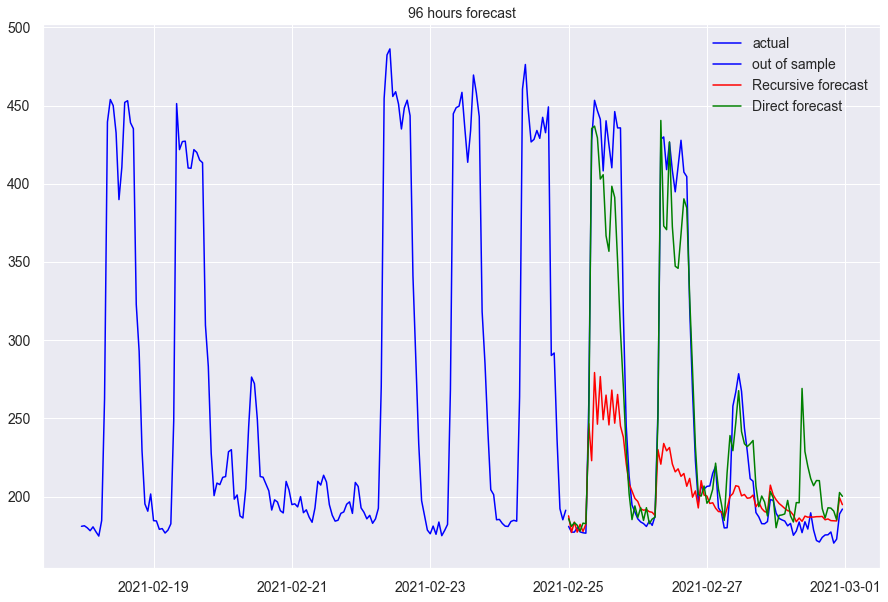

In [49]:
# Render the actual and forecast data

y = fcast_trf.inverse(index=y.index, values=y.values)
rec_fcast = fcast_trf.inverse(index=rec_fcast.index, values=rec_fcast.values)
dir_fcast = fcast_trf.inverse(index=dir_fcast.index, values=dir_fcast.values)

# plot resulting forecast
start_date = y.index[-1] - pd.Timedelta(days=7)
in_sample = y[y.index >= start_date]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(in_sample, color="blue", label="actual")

ax.plot(f_target, color="blue", label="out of sample")

ax.plot(rec_fcast, color="red", label="Recursive forecast")
ax.plot(dir_fcast, color="green", label="Direct forecast")
ax.set_title(f"{FCAST_STEPS} hours forecast")
ax.legend()
plt.show()

In [50]:
# forecasting scores

rec_fcast_score = mape(f_target.values, rec_fcast.values)
print('Recursive forecast MAPE is {:.2f}%'.format(mape(f_target.values, rec_fcast.values)))
dir_fcast_score = mape(f_target.values, dir_fcast.values)
print('Direct forecast MAPE is {:.2f}%'.format(mape(f_target.values, dir_fcast.values)))

# save results for later comparison
forecasting_results["xgb_recursive"] = {
    "fcast": rec_fcast,
    "explained_variance_score": explained_variance_score(f_target.values, rec_fcast.values),
    "mape": rec_fcast_score
}

# save results for later comparison
forecasting_results["xgb_direct"] = {
    "fcast": dir_fcast,
    "explained_variance_score":explained_variance_score(f_target.values, dir_fcast.values),
    "mape": dir_fcast_score
}

Recursive forecast MAPE is 14.83%
Direct forecast MAPE is 7.65%


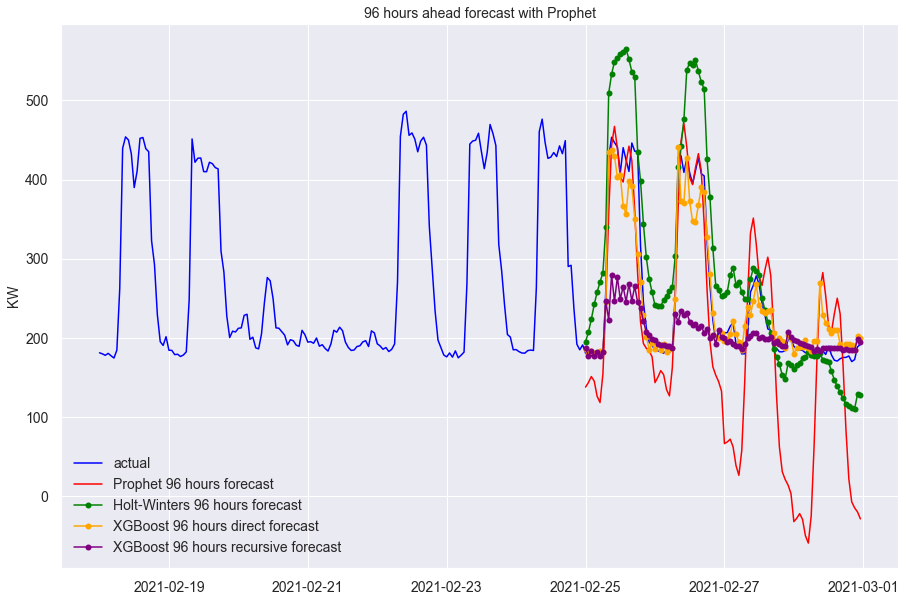

In [51]:
# Render the actual and forecast data, to compare Prophet, Holt-Winters, XGBoost Direct and Recursive strategy

prophet = forecasting_results["prophet"]["fcast"]
holt_winters = forecasting_results["holt_winters"]["fcast"]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
start_date = t_target.index[-1] - pd.Timedelta(days=7)
ax.plot(c_target[c_target.index > start_date], color="blue", label="actual")
ax.set(ylabel="KW")
ax.plot(prophet[prophet_fcast.index >= f_target.index[0]], 
         color="red", 
         label=f"Prophet {FCAST_STEPS} hours forecast")
ax.set_title(f"{FCAST_STEPS} hours ahead forecast with Prophet")
ax.plot(
    holt_winters[holt_winters.index >= t_target.index[-1]],
    color="green",
    label=f"Holt-Winters {FCAST_STEPS} hours forecast",
    marker="o",
)

ax.plot(
    dir_fcast,
    color="orange",
    label=f"XGBoost {FCAST_STEPS} hours direct forecast",
    marker="o",
)

ax.plot(
    rec_fcast,
    color="purple",
    label=f"XGBoost {FCAST_STEPS} hours recursive forecast",
    marker="o",
)

ax.legend()
plt.show()


## LSTM 

Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture, used in the field of deep learning. A LSTM has a similar control flow as a recurrent neural network. It processes data passing on information as it propagates forward. The differences are the operations within the LSTM’s cells.


![LSTM](https://miro.medium.com/max/2400/1*0f8r3Vd-i4ueYND1CUrhMA.png)

In [52]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [53]:
df = c_data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10080 entries, 2020-01-06 00:00:00 to 2021-02-28 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10080 non-null  object 
 1   power                   10080 non-null  float64
 2   temperature             10080 non-null  float64
 3   public_holiday          10080 non-null  int64  
 4   week_days               10080 non-null  int64  
 5   working_day             10080 non-null  int64  
 6   covid_phases            10080 non-null  int64  
 7   primary_school_holiday  10080 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 966.8+ KB


In [54]:
# Hardcode all variables

batch_size_exp = 1
epoch_exp = 50
neurons_exp = 15
predict_values_exp = 96
lag_exp=336

In [55]:
# frame a sequence as a supervised learning problem

def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    print(df.head())
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


In [56]:
# fit an LSTM network to training data

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam') 
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model
    print(model.summary)

In [57]:
# make a one-step forecast

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [58]:
'''Drop all other features '''
df = df.loc[:, ['power']]

df.tail()

power
localtime                      
2021-02-28 19:00:00  177.352589
2021-02-28 20:00:00  170.256785
2021-02-28 21:00:00  172.781440
2021-02-28 22:00:00  188.832738
2021-02-28 23:00:00  191.998854

In [59]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values


                       0
0  [-0.6572023000000229]
1    [4.993704200000025]
2    [1.338583199999988]
3   [-0.634558300000009]
4   [-5.247342500000002]


In [60]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [61]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
9983/9983 [==============================] - 34s 3ms/step - loss: 0.0445
Epoch 1/1
9983/9983 [==============================] - 31s 3ms/step - loss: 0.0351
Epoch 1/1
9983/9983 [==============================] - 32s 3ms/step - loss: 0.0335
Epoch 1/1
9983/9983 [==============================] - 33s 3ms/step - loss: 0.0322
Epoch 1/1
9983/9983 [==============================] - 32s 3ms/step - loss: 0.0314
Epoch 1/1
9983/9983 [==============================] - 31s 3ms/step - loss: 0.0308
Epoch 1/1
9983/9983 [==============================] - 31s 3ms/step - loss: 0.0301
Epoch 1/1
9983/9983 [==============================] - 35s 3ms/step - loss: 0.0298
Epoch 1/1
9983/9983 [==============================] - 29s 3ms/step - loss: 0.0292
Epoch 1/1
9983/9983 [==============================] - 29s 3ms/step - loss: 0.0286
Epoch 1/1
9983/9983 [==============================] - 29s 3ms/step - loss: 0.0281
Epoch 1/1
9983/9983 [==============================] - 32s 3ms/step - loss: 0.0278
Epoc

In [62]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=188.821549, Expected=191.265010
Hour=2, Predicted=179.839907, Expected=180.917742
Hour=3, Predicted=174.751876, Expected=177.289810
Hour=4, Predicted=178.238853, Expected=177.240594
Hour=5, Predicted=178.101799, Expected=180.119350
Hour=6, Predicted=176.229382, Expected=177.386631
Hour=7, Predicted=180.551894, Expected=176.861738
Hour=8, Predicted=241.854936, Expected=176.594288
Hour=9, Predicted=407.843226, Expected=259.509289
Hour=10, Predicted=430.665276, Expected=427.806508
Hour=11, Predicted=441.497400, Expected=453.358232
Hour=12, Predicted=446.299051, Expected=446.699097
Hour=13, Predicted=428.663502, Expected=441.251217
Hour=14, Predicted=401.123733, Expected=408.239297
Hour=15, Predicted=446.050302, Expected=440.279310
Hour=16, Predicted=428.387597, Expected=424.790236
Hour=17, Predicted=404.821453, Expected=410.240082
Hour=18, Predicted=422.907498, Expected=446.171063
Hour=19, Predicted=374.499012, Expected=435.733554
Hour=20, Predicted=392.686512, Expected=

In [63]:
# get the dates to forecast
last_date = df.index[-predict_values_exp] # + pd.Timedelta(hours=1)
fcast_range = pd.date_range(last_date, periods=predict_values_exp, freq="1H")
fcast_data = pd.Series(index=fcast_range, data=predictions_plot)
expected_data = pd.Series(index=fcast_range, data=expectations_plot)

In [64]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 15)                   21120     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    16        
Total params: 21,136
Trainable params: 21,136
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Calculate the model MAPE

expectations = np.array(expectations)
predictions = np.array(predictions)
print('LSTM model MAPE is {:.2f}%'.format(mape(expectations,predictions )))

# save results for later comparison
forecasting_results["lstm"] = {
    "fcast": fcast_data,
    "model": lstm_model,
    "explained_variance_score":explained_variance_score(expectations,predictions),
    "mape": mape(expectations,predictions)
}


LSTM model MAPE is 5.29%


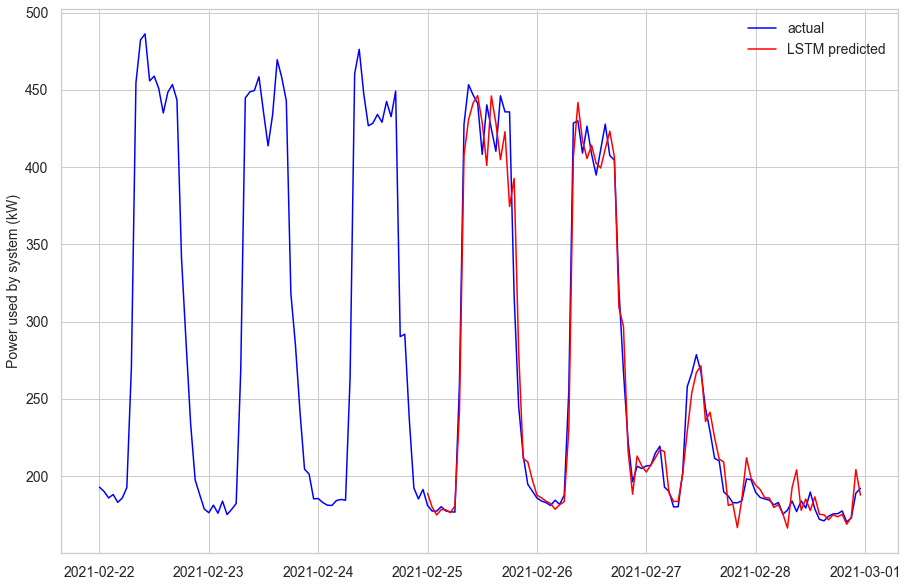

In [66]:
# line plot of observed vs predicted

sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(df[df.index > start_date], color="blue", label="actual")
pyplot.plot(fcast_data, color="red", label="LSTM predicted")
pyplot.legend(loc='upper right')
# pyplot.xlabel("Date Time")
pyplot.ylabel("Power used by system (kW)")
pyplot.show()

To re-run the train data, and explore the MAPE

In [67]:

# walk-forward validation on the train data to get mape
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1

    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(train_scaled):
        if i+1 > lag_exp+1:
            train_scaled[i+1] = test_pred
        else:
            train_scaled[i+1] = np.concatenate((test_pred, train_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    expected = raw_values[i+predict_values_exp]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# get the dates to forecast
start_date = df.index[0] # + pd.Timedelta(hours=1)
fcast_range = pd.date_range(start_date, periods=len(train_scaled), freq="1H")
fcast_data = pd.Series(index=fcast_range, data=predictions_plot)
expected_data = pd.Series(index=fcast_range, data=expectations_plot)

expectations = np.array(expectations)
predictions = np.array(predictions)
print('LSTM model MAPE for training data is {:.2f}%'.format(mape(expectations,predictions )))

# save results for later comparison
forecasting_results["lstm"]["train_mape"] = mape(expectations,predictions)


Hour=1, Predicted=176.792730, Expected=175.731497
Hour=2, Predicted=154.397588, Expected=155.403564
Hour=3, Predicted=150.999691, Expected=152.449627
Hour=4, Predicted=152.322254, Expected=153.957531
Hour=5, Predicted=151.354553, Expected=153.027455
Hour=6, Predicted=148.953887, Expected=150.617621
Hour=7, Predicted=151.184035, Expected=152.815231
Hour=8, Predicted=216.896387, Expected=218.533160
Hour=9, Predicted=763.843150, Expected=765.487785
Hour=10, Predicted=686.919585, Expected=688.559607
Hour=11, Predicted=670.976251, Expected=672.567894
Hour=12, Predicted=677.730290, Expected=679.275440
Hour=13, Predicted=660.501654, Expected=662.000203
Hour=14, Predicted=658.923535, Expected=660.374651
Hour=15, Predicted=675.494119, Expected=676.872986
Hour=16, Predicted=652.983076, Expected=654.275232
Hour=17, Predicted=662.889930, Expected=664.151510
Hour=18, Predicted=635.106331, Expected=636.344780
Hour=19, Predicted=358.676142, Expected=359.903961
Hour=20, Predicted=299.087868, Expected=

Hour=199, Predicted=148.949502, Expected=150.364656
Hour=200, Predicted=146.473309, Expected=147.894297
Hour=201, Predicted=324.377054, Expected=325.814648
Hour=202, Predicted=363.589905, Expected=365.015373
Hour=203, Predicted=353.862373, Expected=355.305245
Hour=204, Predicted=389.961816, Expected=391.395213
Hour=205, Predicted=395.980441, Expected=397.425698
Hour=206, Predicted=197.012560, Expected=198.452273
Hour=207, Predicted=201.367948, Expected=202.811809
Hour=208, Predicted=187.474854, Expected=188.913396
Hour=209, Predicted=180.669352, Expected=182.081099
Hour=210, Predicted=175.548083, Expected=176.977557
Hour=211, Predicted=165.802295, Expected=167.222344
Hour=212, Predicted=162.443495, Expected=163.888395
Hour=213, Predicted=152.874681, Expected=154.285297
Hour=214, Predicted=153.573317, Expected=154.996159
Hour=215, Predicted=151.122790, Expected=152.535234
Hour=216, Predicted=153.830938, Expected=155.254220
Hour=217, Predicted=151.243394, Expected=152.637820
Hour=218, Pr

Hour=381, Predicted=143.782897, Expected=145.495743
Hour=382, Predicted=141.386685, Expected=143.099314
Hour=383, Predicted=144.117753, Expected=145.826509
Hour=384, Predicted=146.128868, Expected=147.834400
Hour=385, Predicted=147.600620, Expected=149.312892
Hour=386, Predicted=146.378545, Expected=148.098197
Hour=387, Predicted=144.262516, Expected=145.993662
Hour=388, Predicted=141.866878, Expected=143.599911
Hour=389, Predicted=145.004884, Expected=146.739297
Hour=390, Predicted=144.167948, Expected=145.900425
Hour=391, Predicted=144.315496, Expected=146.041714
Hour=392, Predicted=147.941808, Expected=149.668467
Hour=393, Predicted=146.117360, Expected=147.849330
Hour=394, Predicted=144.185288, Expected=145.918072
Hour=395, Predicted=143.936626, Expected=145.672584
Hour=396, Predicted=143.954268, Expected=145.690376
Hour=397, Predicted=145.759159, Expected=147.496414
Hour=398, Predicted=143.806745, Expected=145.540218
Hour=399, Predicted=148.141532, Expected=149.866811
Hour=400, Pr

Hour=602, Predicted=151.637911, Expected=153.460565
Hour=603, Predicted=144.813712, Expected=146.638294
Hour=604, Predicted=144.762837, Expected=146.593212
Hour=605, Predicted=139.815865, Expected=141.646896
Hour=606, Predicted=144.629657, Expected=146.460838
Hour=607, Predicted=170.794101, Expected=172.626138
Hour=608, Predicted=221.992536, Expected=223.823617
Hour=609, Predicted=710.160298, Expected=711.990539
Hour=610, Predicted=685.601308, Expected=687.432007
Hour=611, Predicted=697.052275, Expected=698.883339
Hour=612, Predicted=677.979362, Expected=679.810776
Hour=613, Predicted=683.371322, Expected=685.200616
Hour=614, Predicted=660.376781, Expected=662.206183
Hour=615, Predicted=703.436279, Expected=705.264168
Hour=616, Predicted=693.372739, Expected=695.197769
Hour=617, Predicted=683.757646, Expected=685.579502
Hour=618, Predicted=663.977976, Expected=665.796258
Hour=619, Predicted=420.533369, Expected=422.350961
Hour=620, Predicted=281.984930, Expected=283.806071
Hour=621, Pr

Hour=807, Predicted=679.303457, Expected=681.166736
Hour=808, Predicted=663.362930, Expected=665.225793
Hour=809, Predicted=667.070714, Expected=668.932139
Hour=810, Predicted=671.129226, Expected=672.990369
Hour=811, Predicted=503.616416, Expected=505.476893
Hour=812, Predicted=266.878624, Expected=268.739792
Hour=813, Predicted=213.327114, Expected=215.187425
Hour=814, Predicted=170.589861, Expected=172.450422
Hour=815, Predicted=155.186827, Expected=157.046782
Hour=816, Predicted=147.668726, Expected=149.528822
Hour=817, Predicted=148.308831, Expected=150.168079
Hour=818, Predicted=141.438271, Expected=143.298233
Hour=819, Predicted=146.785670, Expected=148.646788
Hour=820, Predicted=145.986923, Expected=147.850094
Hour=821, Predicted=142.393952, Expected=144.257696
Hour=822, Predicted=139.453147, Expected=141.317697
Hour=823, Predicted=165.310729, Expected=167.175212
Hour=824, Predicted=225.642437, Expected=227.507810
Hour=825, Predicted=667.611100, Expected=669.477146
Hour=826, Pr

Hour=988, Predicted=174.705989, Expected=176.582350
Hour=989, Predicted=174.275510, Expected=176.152394
Hour=990, Predicted=171.999977, Expected=173.877185
Hour=991, Predicted=154.232339, Expected=156.109747
Hour=992, Predicted=202.071806, Expected=203.949505
Hour=993, Predicted=831.135328, Expected=833.013384
Hour=994, Predicted=702.935307, Expected=704.813687
Hour=995, Predicted=661.770190, Expected=663.648537
Hour=996, Predicted=673.714137, Expected=675.592392
Hour=997, Predicted=660.721359, Expected=662.599531
Hour=998, Predicted=615.693990, Expected=617.572021
Hour=999, Predicted=651.135835, Expected=653.013384
Hour=1000, Predicted=667.583231, Expected=669.460348
Hour=1001, Predicted=649.640062, Expected=651.516680
Hour=1002, Predicted=651.445662, Expected=653.322048
Hour=1003, Predicted=502.049234, Expected=503.925453
Hour=1004, Predicted=255.843024, Expected=257.719326
Hour=1005, Predicted=207.811782, Expected=209.687735
Hour=1006, Predicted=179.079041, Expected=180.954853
Hour=

Hour=1197, Predicted=215.979901, Expected=217.861655
Hour=1198, Predicted=173.017960, Expected=174.899697
Hour=1199, Predicted=176.886260, Expected=178.767956
Hour=1200, Predicted=185.382008, Expected=187.263804
Hour=1201, Predicted=173.839526, Expected=175.721430
Hour=1202, Predicted=167.515868, Expected=169.397988
Hour=1203, Predicted=172.820285, Expected=174.702613
Hour=1204, Predicted=174.106246, Expected=175.988848
Hour=1205, Predicted=163.714408, Expected=165.597176
Hour=1206, Predicted=164.358875, Expected=166.241718
Hour=1207, Predicted=141.506456, Expected=143.389291
Hour=1208, Predicted=145.943511, Expected=147.826346
Hour=1209, Predicted=200.158015, Expected=202.040875
Hour=1210, Predicted=217.397395, Expected=219.280271
Hour=1211, Predicted=203.216513, Expected=205.099373
Hour=1212, Predicted=214.490146, Expected=216.372973
Hour=1213, Predicted=214.712863, Expected=216.595598
Hour=1214, Predicted=188.366116, Expected=190.248752
Hour=1215, Predicted=155.717341, Expected=157.

Hour=1430, Predicted=722.344897, Expected=724.229669
Hour=1431, Predicted=696.694443, Expected=698.579190
Hour=1432, Predicted=727.627135, Expected=729.511849
Hour=1433, Predicted=713.414637, Expected=715.299309
Hour=1434, Predicted=689.433202, Expected=691.317841
Hour=1435, Predicted=526.235618, Expected=528.120215
Hour=1436, Predicted=247.138647, Expected=249.023235
Hour=1437, Predicted=209.697357, Expected=211.581920
Hour=1438, Predicted=179.938776, Expected=181.823315
Hour=1439, Predicted=170.583619, Expected=172.468133
Hour=1440, Predicted=158.825546, Expected=160.710068
Hour=1441, Predicted=151.142878, Expected=153.027417
Hour=1442, Predicted=147.447547, Expected=149.332119
Hour=1443, Predicted=148.492794, Expected=150.377416
Hour=1444, Predicted=146.996294, Expected=148.880965
Hour=1445, Predicted=146.393711, Expected=148.278424
Hour=1446, Predicted=148.927971, Expected=150.812725
Hour=1447, Predicted=160.092161, Expected=161.976949
Hour=1448, Predicted=215.513332, Expected=217.

Hour=1614, Predicted=140.291457, Expected=142.176827
Hour=1615, Predicted=161.342252, Expected=163.227638
Hour=1616, Predicted=204.321695, Expected=206.207098
Hour=1617, Predicted=800.135180, Expected=802.020599
Hour=1618, Predicted=695.196709, Expected=697.082154
Hour=1619, Predicted=666.309417, Expected=668.194870
Hour=1620, Predicted=684.416279, Expected=686.301740
Hour=1621, Predicted=639.518036, Expected=641.403481
Hour=1622, Predicted=626.028352, Expected=627.913788
Hour=1623, Predicted=670.708487, Expected=672.593898
Hour=1624, Predicted=654.578499, Expected=656.463893
Hour=1625, Predicted=664.505690, Expected=666.391060
Hour=1626, Predicted=660.359805, Expected=662.245158
Hour=1627, Predicted=528.525370, Expected=530.410698
Hour=1628, Predicted=268.298803, Expected=270.184123
Hour=1629, Predicted=238.067918, Expected=239.953222
Hour=1630, Predicted=204.288840, Expected=206.174135
Hour=1631, Predicted=212.327086, Expected=214.212364
Hour=1632, Predicted=186.251098, Expected=188.

Hour=1835, Predicted=658.740370, Expected=660.626072
Hour=1836, Predicted=656.547642, Expected=658.433336
Hour=1837, Predicted=625.062813, Expected=626.948507
Hour=1838, Predicted=616.657609, Expected=618.543294
Hour=1839, Predicted=658.202435, Expected=660.088112
Hour=1840, Predicted=657.414958, Expected=659.300619
Hour=1841, Predicted=679.241690, Expected=681.127342
Hour=1842, Predicted=625.122432, Expected=627.008084
Hour=1843, Predicted=478.511922, Expected=480.397566
Hour=1844, Predicted=240.502068, Expected=242.387704
Hour=1845, Predicted=207.409727, Expected=209.295363
Hour=1846, Predicted=182.499216, Expected=184.384852
Hour=1847, Predicted=199.904876, Expected=201.790512
Hour=1848, Predicted=186.021957, Expected=187.907593
Hour=1849, Predicted=147.885949, Expected=149.771593
Hour=1850, Predicted=145.333030, Expected=147.218682
Hour=1851, Predicted=142.282937, Expected=144.168598
Hour=1852, Predicted=144.075207, Expected=145.960876
Hour=1853, Predicted=143.157637, Expected=145.

Hour=2059, Predicted=197.954434, Expected=199.840195
Hour=2060, Predicted=197.954434, Expected=199.840195
Hour=2061, Predicted=146.225182, Expected=148.110942
Hour=2062, Predicted=146.225182, Expected=148.110942
Hour=2063, Predicted=175.201369, Expected=177.087121
Hour=2064, Predicted=174.296914, Expected=176.182675
Hour=2065, Predicted=173.192615, Expected=175.078376
Hour=2066, Predicted=167.789993, Expected=169.675754
Hour=2067, Predicted=183.471353, Expected=185.357113
Hour=2068, Predicted=179.761814, Expected=181.647583
Hour=2069, Predicted=169.581794, Expected=171.467563
Hour=2070, Predicted=170.819423, Expected=172.705200
Hour=2071, Predicted=145.289803, Expected=147.175580
Hour=2072, Predicted=137.894170, Expected=139.779955
Hour=2073, Predicted=143.835887, Expected=145.721672
Hour=2074, Predicted=151.000729, Expected=152.886515
Hour=2075, Predicted=149.010201, Expected=150.895986
Hour=2076, Predicted=144.725248, Expected=146.611033
Hour=2077, Predicted=148.387649, Expected=150.

Hour=2235, Predicted=185.170979, Expected=187.056781
Hour=2236, Predicted=185.538609, Expected=187.424411
Hour=2237, Predicted=168.057945, Expected=169.943747
Hour=2238, Predicted=168.692451, Expected=170.578253
Hour=2239, Predicted=145.826321, Expected=147.712131
Hour=2240, Predicted=143.549728, Expected=145.435539
Hour=2241, Predicted=143.700897, Expected=145.586707
Hour=2242, Predicted=144.183511, Expected=146.069321
Hour=2243, Predicted=145.662755, Expected=147.548565
Hour=2244, Predicted=141.686418, Expected=143.572237
Hour=2245, Predicted=147.402216, Expected=149.288027
Hour=2246, Predicted=143.798440, Expected=145.684250
Hour=2247, Predicted=144.917446, Expected=146.803256
Hour=2248, Predicted=143.738796, Expected=145.624607
Hour=2249, Predicted=148.476047, Expected=150.361857
Hour=2250, Predicted=146.442718, Expected=148.328528
Hour=2251, Predicted=145.254840, Expected=147.140642
Hour=2252, Predicted=152.717609, Expected=154.603411
Hour=2253, Predicted=149.528993, Expected=151.

Hour=2422, Predicted=150.888104, Expected=152.773923
Hour=2423, Predicted=193.204077, Expected=195.089896
Hour=2424, Predicted=195.697627, Expected=197.583437
Hour=2425, Predicted=144.728912, Expected=146.614731
Hour=2426, Predicted=150.136315, Expected=152.022134
Hour=2427, Predicted=147.441454, Expected=149.327273
Hour=2428, Predicted=145.974457, Expected=147.860275
Hour=2429, Predicted=148.343535, Expected=150.229353
Hour=2430, Predicted=151.416763, Expected=153.302582
Hour=2431, Predicted=147.002287, Expected=148.888106
Hour=2432, Predicted=166.592058, Expected=168.477876
Hour=2433, Predicted=287.921761, Expected=289.807580
Hour=2434, Predicted=320.145574, Expected=322.031392
Hour=2435, Predicted=328.792842, Expected=330.678660
Hour=2436, Predicted=337.522903, Expected=339.408722
Hour=2437, Predicted=310.406635, Expected=312.292462
Hour=2438, Predicted=295.626903, Expected=297.512722
Hour=2439, Predicted=563.691032, Expected=565.576850
Hour=2440, Predicted=553.573152, Expected=555.

Hour=2614, Predicted=454.776749, Expected=456.662567
Hour=2615, Predicted=454.776740, Expected=456.662567
Hour=2616, Predicted=454.776749, Expected=456.662567
Hour=2617, Predicted=454.776740, Expected=456.662567
Hour=2618, Predicted=454.776749, Expected=456.662567
Hour=2619, Predicted=454.776740, Expected=456.662567
Hour=2620, Predicted=454.776749, Expected=456.662567
Hour=2621, Predicted=454.776740, Expected=456.662567
Hour=2622, Predicted=454.776740, Expected=456.662567
Hour=2623, Predicted=454.776740, Expected=456.662567
Hour=2624, Predicted=454.776740, Expected=456.662567
Hour=2625, Predicted=454.776740, Expected=456.662567
Hour=2626, Predicted=454.776740, Expected=456.662567
Hour=2627, Predicted=454.776740, Expected=456.662567
Hour=2628, Predicted=454.776740, Expected=456.662567
Hour=2629, Predicted=454.776740, Expected=456.662567
Hour=2630, Predicted=454.776740, Expected=456.662567
Hour=2631, Predicted=454.776740, Expected=456.662567
Hour=2632, Predicted=454.776740, Expected=456.

Hour=2784, Predicted=139.969813, Expected=141.855640
Hour=2785, Predicted=137.010954, Expected=138.896781
Hour=2786, Predicted=138.355785, Expected=140.241612
Hour=2787, Predicted=135.437988, Expected=137.323815
Hour=2788, Predicted=139.079948, Expected=140.965775
Hour=2789, Predicted=132.591602, Expected=134.477429
Hour=2790, Predicted=138.436626, Expected=140.322453
Hour=2791, Predicted=140.397391, Expected=142.283218
Hour=2792, Predicted=150.239273, Expected=152.125100
Hour=2793, Predicted=261.099865, Expected=262.985692
Hour=2794, Predicted=255.701475, Expected=257.587302
Hour=2795, Predicted=255.255518, Expected=257.141345
Hour=2796, Predicted=259.163348, Expected=261.049175
Hour=2797, Predicted=265.662448, Expected=267.548275
Hour=2798, Predicted=268.446235, Expected=270.332062
Hour=2799, Predicted=274.287711, Expected=276.173538
Hour=2800, Predicted=270.240363, Expected=272.126190
Hour=2801, Predicted=261.620916, Expected=263.506742
Hour=2802, Predicted=247.230865, Expected=249.

Hour=2961, Predicted=265.073175, Expected=266.959002
Hour=2962, Predicted=275.001276, Expected=276.887103
Hour=2963, Predicted=277.104499, Expected=278.990326
Hour=2964, Predicted=281.025226, Expected=282.911053
Hour=2965, Predicted=287.832038, Expected=289.717865
Hour=2966, Predicted=289.846446, Expected=291.732273
Hour=2967, Predicted=289.038300, Expected=290.924126
Hour=2968, Predicted=291.558498, Expected=293.444324
Hour=2969, Predicted=271.846091, Expected=273.731918
Hour=2970, Predicted=248.640817, Expected=250.526644
Hour=2971, Predicted=177.597582, Expected=179.483409
Hour=2972, Predicted=174.793122, Expected=176.678949
Hour=2973, Predicted=168.547841, Expected=170.433668
Hour=2974, Predicted=149.548555, Expected=151.434382
Hour=2975, Predicted=147.140704, Expected=149.026531
Hour=2976, Predicted=144.326399, Expected=146.212226
Hour=2977, Predicted=145.554196, Expected=147.440023
Hour=2978, Predicted=144.904231, Expected=146.790058
Hour=2979, Predicted=146.817524, Expected=148.

Hour=3162, Predicted=460.950221, Expected=462.836048
Hour=3163, Predicted=176.193730, Expected=178.079557
Hour=3164, Predicted=172.558897, Expected=174.444724
Hour=3165, Predicted=166.307210, Expected=168.193037
Hour=3166, Predicted=148.469504, Expected=150.355331
Hour=3167, Predicted=142.062764, Expected=143.948591
Hour=3168, Predicted=140.841731, Expected=142.727558
Hour=3169, Predicted=140.312713, Expected=142.198540
Hour=3170, Predicted=140.470856, Expected=142.356683
Hour=3171, Predicted=139.820276, Expected=141.706103
Hour=3172, Predicted=141.448526, Expected=143.334353
Hour=3173, Predicted=138.389057, Expected=140.274884
Hour=3174, Predicted=143.211194, Expected=145.097021
Hour=3175, Predicted=147.120160, Expected=149.005987
Hour=3176, Predicted=151.934257, Expected=153.820084
Hour=3177, Predicted=561.247192, Expected=563.133019
Hour=3178, Predicted=487.490394, Expected=489.376221
Hour=3179, Predicted=461.916328, Expected=463.802154
Hour=3180, Predicted=465.160526, Expected=467.

Hour=3317, Predicted=144.175658, Expected=146.061485
Hour=3318, Predicted=144.595703, Expected=146.481530
Hour=3319, Predicted=143.155758, Expected=145.041585
Hour=3320, Predicted=148.283066, Expected=150.168893
Hour=3321, Predicted=505.538710, Expected=507.424537
Hour=3322, Predicted=677.369825, Expected=679.255652
Hour=3323, Predicted=628.246009, Expected=630.131836
Hour=3324, Predicted=626.875465, Expected=628.761291
Hour=3325, Predicted=602.622738, Expected=604.508565
Hour=3326, Predicted=591.432563, Expected=593.318390
Hour=3327, Predicted=591.993888, Expected=593.879715
Hour=3328, Predicted=484.444444, Expected=486.330271
Hour=3329, Predicted=454.310427, Expected=456.196254
Hour=3330, Predicted=518.392818, Expected=520.278645
Hour=3331, Predicted=336.182046, Expected=338.067873
Hour=3332, Predicted=179.802928, Expected=181.688755
Hour=3333, Predicted=164.335290, Expected=166.221117
Hour=3334, Predicted=142.386584, Expected=144.272411
Hour=3335, Predicted=136.987693, Expected=138.

Hour=3500, Predicted=186.112794, Expected=187.998621
Hour=3501, Predicted=178.315537, Expected=180.201364
Hour=3502, Predicted=149.398517, Expected=151.284344
Hour=3503, Predicted=141.630092, Expected=143.515919
Hour=3504, Predicted=138.927955, Expected=140.813782
Hour=3505, Predicted=140.429683, Expected=142.315510
Hour=3506, Predicted=143.778385, Expected=145.664212
Hour=3507, Predicted=138.096020, Expected=139.981847
Hour=3508, Predicted=149.278795, Expected=151.164622
Hour=3509, Predicted=133.840321, Expected=135.726148
Hour=3510, Predicted=137.639836, Expected=139.525663
Hour=3511, Predicted=143.708228, Expected=145.594055
Hour=3512, Predicted=157.680080, Expected=159.565907
Hour=3513, Predicted=672.704826, Expected=674.590653
Hour=3514, Predicted=578.393302, Expected=580.279129
Hour=3515, Predicted=570.185218, Expected=572.071045
Hour=3516, Predicted=561.236296, Expected=563.122123
Hour=3517, Predicted=567.802327, Expected=569.688154
Hour=3518, Predicted=564.821601, Expected=566.

Hour=3697, Predicted=141.462993, Expected=143.348820
Hour=3698, Predicted=142.893208, Expected=144.779035
Hour=3699, Predicted=145.234033, Expected=147.119859
Hour=3700, Predicted=145.563158, Expected=147.448985
Hour=3701, Predicted=143.178516, Expected=145.064343
Hour=3702, Predicted=143.914103, Expected=145.799930
Hour=3703, Predicted=144.531752, Expected=146.417579
Hour=3704, Predicted=160.064863, Expected=161.950690
Hour=3705, Predicted=599.065738, Expected=600.951565
Hour=3706, Predicted=559.842923, Expected=561.728750
Hour=3707, Predicted=547.774736, Expected=549.660563
Hour=3708, Predicted=508.529163, Expected=510.414989
Hour=3709, Predicted=525.045966, Expected=526.931793
Hour=3710, Predicted=530.287600, Expected=532.173427
Hour=3711, Predicted=521.645966, Expected=523.531793
Hour=3712, Predicted=536.757396, Expected=538.643223
Hour=3713, Predicted=536.757396, Expected=538.643223
Hour=3714, Predicted=481.303817, Expected=483.189644
Hour=3715, Predicted=184.452442, Expected=186.

Hour=3884, Predicted=179.453664, Expected=181.339491
Hour=3885, Predicted=161.786027, Expected=163.671854
Hour=3886, Predicted=144.722293, Expected=146.608120
Hour=3887, Predicted=141.613008, Expected=143.498835
Hour=3888, Predicted=149.700336, Expected=151.586163
Hour=3889, Predicted=146.990539, Expected=148.876366
Hour=3890, Predicted=149.873254, Expected=151.759081
Hour=3891, Predicted=149.952521, Expected=151.838348
Hour=3892, Predicted=152.050561, Expected=153.936388
Hour=3893, Predicted=137.404986, Expected=139.290813
Hour=3894, Predicted=143.358995, Expected=145.244822
Hour=3895, Predicted=134.820136, Expected=136.705963
Hour=3896, Predicted=126.090802, Expected=127.976629
Hour=3897, Predicted=189.214717, Expected=191.100544
Hour=3898, Predicted=194.084542, Expected=195.970369
Hour=3899, Predicted=213.868082, Expected=215.753909
Hour=3900, Predicted=200.364537, Expected=202.250364
Hour=3901, Predicted=183.260360, Expected=185.146187
Hour=3902, Predicted=151.366359, Expected=153.

Hour=4111, Predicted=141.618462, Expected=143.504289
Hour=4112, Predicted=165.525821, Expected=167.411648
Hour=4113, Predicted=685.086911, Expected=686.972738
Hour=4114, Predicted=648.353515, Expected=650.239342
Hour=4115, Predicted=630.671409, Expected=632.557236
Hour=4116, Predicted=616.410422, Expected=618.296249
Hour=4117, Predicted=593.489020, Expected=595.374847
Hour=4118, Predicted=571.430410, Expected=573.316237
Hour=4119, Predicted=602.077491, Expected=603.963318
Hour=4120, Predicted=566.841003, Expected=568.726830
Hour=4121, Predicted=574.965505, Expected=576.851332
Hour=4122, Predicted=551.939264, Expected=553.825091
Hour=4123, Predicted=208.904103, Expected=210.789930
Hour=4124, Predicted=201.763005, Expected=203.648832
Hour=4125, Predicted=170.835617, Expected=172.721444
Hour=4126, Predicted=149.700060, Expected=151.585887
Hour=4127, Predicted=137.950301, Expected=139.836128
Hour=4128, Predicted=138.761645, Expected=140.647472
Hour=4129, Predicted=135.026179, Expected=136.

Hour=4287, Predicted=601.483741, Expected=603.369568
Hour=4288, Predicted=579.385841, Expected=581.271668
Hour=4289, Predicted=786.858756, Expected=788.744583
Hour=4290, Predicted=579.584466, Expected=581.470293
Hour=4291, Predicted=204.726959, Expected=206.612786
Hour=4292, Predicted=191.839702, Expected=193.725529
Hour=4293, Predicted=174.421368, Expected=176.307195
Hour=4294, Predicted=154.008252, Expected=155.894079
Hour=4295, Predicted=141.035677, Expected=142.921504
Hour=4296, Predicted=139.342393, Expected=141.228220
Hour=4297, Predicted=140.480392, Expected=142.366219
Hour=4298, Predicted=142.221599, Expected=144.107426
Hour=4299, Predicted=139.557467, Expected=141.443294
Hour=4300, Predicted=136.805627, Expected=138.691454
Hour=4301, Predicted=140.947183, Expected=142.833010
Hour=4302, Predicted=140.591392, Expected=142.477219
Hour=4303, Predicted=140.505857, Expected=142.391684
Hour=4304, Predicted=154.414087, Expected=156.299914
Hour=4305, Predicted=697.483543, Expected=699.

Hour=4462, Predicted=144.846434, Expected=146.732261
Hour=4463, Predicted=134.266803, Expected=136.152630
Hour=4464, Predicted=137.100050, Expected=138.985877
Hour=4465, Predicted=135.313144, Expected=137.198971
Hour=4466, Predicted=136.080564, Expected=137.966391
Hour=4467, Predicted=131.481929, Expected=133.367756
Hour=4468, Predicted=133.830976, Expected=135.716803
Hour=4469, Predicted=131.025804, Expected=132.911631
Hour=4470, Predicted=140.057117, Expected=141.942944
Hour=4471, Predicted=137.176904, Expected=139.062731
Hour=4472, Predicted=166.055247, Expected=167.941074
Hour=4473, Predicted=697.427362, Expected=699.313189
Hour=4474, Predicted=535.542647, Expected=537.428474
Hour=4475, Predicted=562.021896, Expected=563.907722
Hour=4476, Predicted=569.979923, Expected=571.865750
Hour=4477, Predicted=536.050466, Expected=537.936293
Hour=4478, Predicted=530.840263, Expected=532.726089
Hour=4479, Predicted=511.576885, Expected=513.462712
Hour=4480, Predicted=523.418237, Expected=525.

Hour=4631, Predicted=143.641978, Expected=145.527805
Hour=4632, Predicted=145.671594, Expected=147.557421
Hour=4633, Predicted=144.233907, Expected=146.119734
Hour=4634, Predicted=140.609098, Expected=142.494925
Hour=4635, Predicted=143.486352, Expected=145.372179
Hour=4636, Predicted=141.699269, Expected=143.585096
Hour=4637, Predicted=139.180610, Expected=141.066437
Hour=4638, Predicted=144.999396, Expected=146.885223
Hour=4639, Predicted=147.992525, Expected=149.878352
Hour=4640, Predicted=172.881328, Expected=174.767155
Hour=4641, Predicted=739.711053, Expected=741.596880
Hour=4642, Predicted=610.144345, Expected=612.030172
Hour=4643, Predicted=582.525828, Expected=584.411655
Hour=4644, Predicted=613.083147, Expected=614.968974
Hour=4645, Predicted=613.083147, Expected=614.968974
Hour=4646, Predicted=613.083147, Expected=614.968974
Hour=4647, Predicted=613.083147, Expected=614.968974
Hour=4648, Predicted=613.083147, Expected=614.968974
Hour=4649, Predicted=613.083147, Expected=614.

Hour=4816, Predicted=558.052432, Expected=559.938259
Hour=4817, Predicted=522.043861, Expected=523.929688
Hour=4818, Predicted=503.229259, Expected=505.115086
Hour=4819, Predicted=231.402042, Expected=233.287869
Hour=4820, Predicted=203.974156, Expected=205.859983
Hour=4821, Predicted=169.986844, Expected=171.872671
Hour=4822, Predicted=160.591187, Expected=162.477014
Hour=4823, Predicted=152.942117, Expected=154.827944
Hour=4824, Predicted=155.480070, Expected=157.365897
Hour=4825, Predicted=151.103231, Expected=152.989058
Hour=4826, Predicted=148.668822, Expected=150.554649
Hour=4827, Predicted=148.769401, Expected=150.655228
Hour=4828, Predicted=150.461439, Expected=152.347266
Hour=4829, Predicted=154.788941, Expected=156.674768
Hour=4830, Predicted=149.763210, Expected=151.649037
Hour=4831, Predicted=147.406667, Expected=149.292494
Hour=4832, Predicted=184.674165, Expected=186.559991
Hour=4833, Predicted=644.983365, Expected=646.869192
Hour=4834, Predicted=525.362800, Expected=527.

Hour=4978, Predicted=588.911089, Expected=590.796916
Hour=4979, Predicted=583.783946, Expected=585.669773
Hour=4980, Predicted=562.254423, Expected=564.140250
Hour=4981, Predicted=521.116553, Expected=523.002380
Hour=4982, Predicted=517.705103, Expected=519.590930
Hour=4983, Predicted=545.483846, Expected=547.369673
Hour=4984, Predicted=552.915481, Expected=554.801308
Hour=4985, Predicted=544.969550, Expected=546.855377
Hour=4986, Predicted=514.205814, Expected=516.091641
Hour=4987, Predicted=216.520059, Expected=218.405886
Hour=4988, Predicted=203.259891, Expected=205.145718
Hour=4989, Predicted=186.737968, Expected=188.623795
Hour=4990, Predicted=150.365253, Expected=152.251080
Hour=4991, Predicted=148.160668, Expected=150.046495
Hour=4992, Predicted=133.491352, Expected=135.377179
Hour=4993, Predicted=136.508417, Expected=138.394243
Hour=4994, Predicted=138.986696, Expected=140.872523
Hour=4995, Predicted=128.660764, Expected=130.546591
Hour=4996, Predicted=136.275977, Expected=138.

Hour=5171, Predicted=615.799160, Expected=617.684987
Hour=5172, Predicted=614.874709, Expected=616.760536
Hour=5173, Predicted=608.665822, Expected=610.551649
Hour=5174, Predicted=611.162077, Expected=613.047904
Hour=5175, Predicted=613.785346, Expected=615.671173
Hour=5176, Predicted=577.166428, Expected=579.052255
Hour=5177, Predicted=577.040588, Expected=578.926414
Hour=5178, Predicted=553.328467, Expected=555.214294
Hour=5179, Predicted=216.275907, Expected=218.161734
Hour=5180, Predicted=196.138776, Expected=198.024603
Hour=5181, Predicted=192.596313, Expected=194.482140
Hour=5182, Predicted=155.982921, Expected=157.868748
Hour=5183, Predicted=150.688701, Expected=152.574528
Hour=5184, Predicted=149.875369, Expected=151.761196
Hour=5185, Predicted=145.150131, Expected=147.035958
Hour=5186, Predicted=148.751409, Expected=150.637236
Hour=5187, Predicted=146.946786, Expected=148.832613
Hour=5188, Predicted=148.136994, Expected=150.022821
Hour=5189, Predicted=146.722068, Expected=148.

Hour=5383, Predicted=141.226323, Expected=143.112150
Hour=5384, Predicted=171.585077, Expected=173.470904
Hour=5385, Predicted=693.152174, Expected=695.038000
Hour=5386, Predicted=589.017633, Expected=590.903460
Hour=5387, Predicted=555.247916, Expected=557.133743
Hour=5388, Predicted=554.961719, Expected=556.847546
Hour=5389, Predicted=551.721473, Expected=553.607300
Hour=5390, Predicted=546.073157, Expected=547.958984
Hour=5391, Predicted=545.096213, Expected=546.982040
Hour=5392, Predicted=531.757522, Expected=533.643349
Hour=5393, Predicted=534.795545, Expected=536.681372
Hour=5394, Predicted=531.910641, Expected=533.796468
Hour=5395, Predicted=209.126151, Expected=211.011978
Hour=5396, Predicted=200.950165, Expected=202.835992
Hour=5397, Predicted=167.498803, Expected=169.384630
Hour=5398, Predicted=140.856530, Expected=142.742357
Hour=5399, Predicted=137.793947, Expected=139.679774
Hour=5400, Predicted=148.943107, Expected=150.828934
Hour=5401, Predicted=147.530725, Expected=149.

Hour=5558, Predicted=536.261500, Expected=538.147327
Hour=5559, Predicted=537.120460, Expected=539.006287
Hour=5560, Predicted=517.673433, Expected=519.559260
Hour=5561, Predicted=544.186313, Expected=546.072140
Hour=5562, Predicted=516.868056, Expected=518.753883
Hour=5563, Predicted=220.143601, Expected=222.029428
Hour=5564, Predicted=198.303252, Expected=200.189079
Hour=5565, Predicted=172.369679, Expected=174.255506
Hour=5566, Predicted=151.795698, Expected=153.681525
Hour=5567, Predicted=143.054330, Expected=144.940157
Hour=5568, Predicted=150.199357, Expected=152.085184
Hour=5569, Predicted=150.865611, Expected=152.751438
Hour=5570, Predicted=140.437283, Expected=142.323110
Hour=5571, Predicted=152.733885, Expected=154.619712
Hour=5572, Predicted=155.840835, Expected=157.726662
Hour=5573, Predicted=146.082725, Expected=147.968552
Hour=5574, Predicted=145.317226, Expected=147.203053
Hour=5575, Predicted=136.268672, Expected=138.154499
Hour=5576, Predicted=136.600443, Expected=138.

Hour=5726, Predicted=512.957286, Expected=514.843113
Hour=5727, Predicted=503.893201, Expected=505.779028
Hour=5728, Predicted=504.810722, Expected=506.696549
Hour=5729, Predicted=530.974391, Expected=532.860218
Hour=5730, Predicted=508.673460, Expected=510.559287
Hour=5731, Predicted=214.191651, Expected=216.077478
Hour=5732, Predicted=174.902915, Expected=176.788742
Hour=5733, Predicted=158.483849, Expected=160.369676
Hour=5734, Predicted=138.929089, Expected=140.814916
Hour=5735, Predicted=136.070462, Expected=137.956289
Hour=5736, Predicted=145.884149, Expected=147.769976
Hour=5737, Predicted=153.059882, Expected=154.945709
Hour=5738, Predicted=143.635947, Expected=145.521774
Hour=5739, Predicted=147.217157, Expected=149.102983
Hour=5740, Predicted=151.878618, Expected=153.764445
Hour=5741, Predicted=138.052625, Expected=139.938452
Hour=5742, Predicted=138.732462, Expected=140.618289
Hour=5743, Predicted=134.339444, Expected=136.225271
Hour=5744, Predicted=135.632390, Expected=137.

Hour=5930, Predicted=174.402020, Expected=176.287847
Hour=5931, Predicted=178.458785, Expected=180.344612
Hour=5932, Predicted=177.444781, Expected=179.330608
Hour=5933, Predicted=174.113696, Expected=175.999523
Hour=5934, Predicted=172.531198, Expected=174.417025
Hour=5935, Predicted=171.366420, Expected=173.252247
Hour=5936, Predicted=174.729832, Expected=176.615659
Hour=5937, Predicted=177.888570, Expected=179.774397
Hour=5938, Predicted=340.439142, Expected=342.324969
Hour=5939, Predicted=292.138413, Expected=294.024240
Hour=5940, Predicted=298.778988, Expected=300.664815
Hour=5941, Predicted=306.661498, Expected=308.547325
Hour=5942, Predicted=189.449994, Expected=191.335821
Hour=5943, Predicted=172.406109, Expected=174.291936
Hour=5944, Predicted=170.392961, Expected=172.278788
Hour=5945, Predicted=175.620854, Expected=177.506681
Hour=5946, Predicted=173.821975, Expected=175.707802
Hour=5947, Predicted=176.588148, Expected=178.473975
Hour=5948, Predicted=174.615543, Expected=176.

Hour=6091, Predicted=178.139314, Expected=180.025141
Hour=6092, Predicted=175.896351, Expected=177.782178
Hour=6093, Predicted=172.183611, Expected=174.069438
Hour=6094, Predicted=171.534637, Expected=173.420464
Hour=6095, Predicted=196.203877, Expected=198.089704
Hour=6096, Predicted=194.761212, Expected=196.647039
Hour=6097, Predicted=181.974425, Expected=183.860252
Hour=6098, Predicted=182.426131, Expected=184.311958
Hour=6099, Predicted=180.805691, Expected=182.691518
Hour=6100, Predicted=180.885732, Expected=182.771558
Hour=6101, Predicted=178.860389, Expected=180.746216
Hour=6102, Predicted=181.878205, Expected=183.764032
Hour=6103, Predicted=169.831748, Expected=171.717575
Hour=6104, Predicted=168.908808, Expected=170.794635
Hour=6105, Predicted=166.212075, Expected=168.097902
Hour=6106, Predicted=167.361241, Expected=169.247068
Hour=6107, Predicted=168.178593, Expected=170.064420
Hour=6108, Predicted=181.053164, Expected=182.938991
Hour=6109, Predicted=168.692581, Expected=170.

Hour=6282, Predicted=170.951219, Expected=172.837046
Hour=6283, Predicted=171.824328, Expected=173.710155
Hour=6284, Predicted=166.732846, Expected=168.618673
Hour=6285, Predicted=166.103820, Expected=167.989647
Hour=6286, Predicted=168.646293, Expected=170.532120
Hour=6287, Predicted=197.389633, Expected=199.275460
Hour=6288, Predicted=208.136782, Expected=210.022609
Hour=6289, Predicted=172.266321, Expected=174.152148
Hour=6290, Predicted=166.781937, Expected=168.667764
Hour=6291, Predicted=169.814345, Expected=171.700172
Hour=6292, Predicted=166.104120, Expected=167.989947
Hour=6293, Predicted=166.630075, Expected=168.515902
Hour=6294, Predicted=166.469983, Expected=168.355809
Hour=6295, Predicted=169.863042, Expected=171.748869
Hour=6296, Predicted=214.843406, Expected=216.729233
Hour=6297, Predicted=790.684234, Expected=792.570061
Hour=6298, Predicted=708.426795, Expected=710.312622
Hour=6299, Predicted=612.412740, Expected=614.298566
Hour=6300, Predicted=624.371304, Expected=626.

Hour=6514, Predicted=633.289004, Expected=635.174831
Hour=6515, Predicted=633.442288, Expected=635.328115
Hour=6516, Predicted=612.713416, Expected=614.599243
Hour=6517, Predicted=637.603726, Expected=639.489553
Hour=6518, Predicted=611.787975, Expected=613.673802
Hour=6519, Predicted=626.945001, Expected=628.830828
Hour=6520, Predicted=619.431617, Expected=621.317444
Hour=6521, Predicted=633.447232, Expected=635.333059
Hour=6522, Predicted=614.530901, Expected=616.416728
Hour=6523, Predicted=267.974222, Expected=269.860049
Hour=6524, Predicted=254.209231, Expected=256.095058
Hour=6525, Predicted=222.887674, Expected=224.773501
Hour=6526, Predicted=186.114522, Expected=188.000349
Hour=6527, Predicted=180.299494, Expected=182.185321
Hour=6528, Predicted=178.806956, Expected=180.692783
Hour=6529, Predicted=177.715417, Expected=179.601244
Hour=6530, Predicted=171.942653, Expected=173.828480
Hour=6531, Predicted=179.434145, Expected=181.319972
Hour=6532, Predicted=174.684632, Expected=176.

Hour=6706, Predicted=475.024464, Expected=476.910290
Hour=6707, Predicted=452.537830, Expected=454.423656
Hour=6708, Predicted=435.271761, Expected=437.157588
Hour=6709, Predicted=425.226456, Expected=427.112283
Hour=6710, Predicted=437.901081, Expected=439.786908
Hour=6711, Predicted=471.178331, Expected=473.064158
Hour=6712, Predicted=449.860622, Expected=451.746448
Hour=6713, Predicted=464.565559, Expected=466.451386
Hour=6714, Predicted=447.989186, Expected=449.875013
Hour=6715, Predicted=303.723780, Expected=305.609607
Hour=6716, Predicted=289.209139, Expected=291.094966
Hour=6717, Predicted=213.845435, Expected=215.731262
Hour=6718, Predicted=190.173860, Expected=192.059687
Hour=6719, Predicted=185.687101, Expected=187.572928
Hour=6720, Predicted=192.386767, Expected=194.272594
Hour=6721, Predicted=183.015337, Expected=184.901164
Hour=6722, Predicted=189.226605, Expected=191.112432
Hour=6723, Predicted=180.698358, Expected=182.584185
Hour=6724, Predicted=171.062192, Expected=172.

Hour=6898, Predicted=451.516831, Expected=453.402658
Hour=6899, Predicted=429.847467, Expected=431.733294
Hour=6900, Predicted=425.184833, Expected=427.070660
Hour=6901, Predicted=460.548213, Expected=462.434040
Hour=6902, Predicted=448.943754, Expected=450.829581
Hour=6903, Predicted=430.723172, Expected=432.608999
Hour=6904, Predicted=436.613722, Expected=438.499549
Hour=6905, Predicted=439.291965, Expected=441.177792
Hour=6906, Predicted=408.939658, Expected=410.825485
Hour=6907, Predicted=320.235598, Expected=322.121425
Hour=6908, Predicted=275.188327, Expected=277.074154
Hour=6909, Predicted=228.425950, Expected=230.311777
Hour=6910, Predicted=199.713966, Expected=201.599793
Hour=6911, Predicted=222.867011, Expected=224.752838
Hour=6912, Predicted=235.797649, Expected=237.683475
Hour=6913, Predicted=216.724557, Expected=218.610384
Hour=6914, Predicted=209.397793, Expected=211.283620
Hour=6915, Predicted=229.615231, Expected=231.501058
Hour=6916, Predicted=231.684082, Expected=233.

Hour=7129, Predicted=188.824763, Expected=190.710590
Hour=7130, Predicted=180.665958, Expected=182.551785
Hour=7131, Predicted=178.587871, Expected=180.473698
Hour=7132, Predicted=180.137907, Expected=182.023734
Hour=7133, Predicted=176.716704, Expected=178.602531
Hour=7134, Predicted=181.981910, Expected=183.867737
Hour=7135, Predicted=174.392078, Expected=176.277905
Hour=7136, Predicted=273.886788, Expected=275.772615
Hour=7137, Predicted=482.435020, Expected=484.320847
Hour=7138, Predicted=498.593199, Expected=500.479026
Hour=7139, Predicted=469.869935, Expected=471.755762
Hour=7140, Predicted=488.642960, Expected=490.528787
Hour=7141, Predicted=470.031201, Expected=471.917028
Hour=7142, Predicted=470.267672, Expected=472.153499
Hour=7143, Predicted=483.093465, Expected=484.979292
Hour=7144, Predicted=467.892842, Expected=469.778669
Hour=7145, Predicted=441.364068, Expected=443.249895
Hour=7146, Predicted=433.179999, Expected=435.065826
Hour=7147, Predicted=318.456863, Expected=320.

Hour=7325, Predicted=176.296401, Expected=178.182228
Hour=7326, Predicted=176.269809, Expected=178.155636
Hour=7327, Predicted=183.357362, Expected=185.243189
Hour=7328, Predicted=239.253257, Expected=241.139084
Hour=7329, Predicted=439.094909, Expected=440.980736
Hour=7330, Predicted=437.795549, Expected=439.681376
Hour=7331, Predicted=436.331005, Expected=438.216832
Hour=7332, Predicted=457.687039, Expected=459.572866
Hour=7333, Predicted=425.936787, Expected=427.822614
Hour=7334, Predicted=424.313415, Expected=426.199242
Hour=7335, Predicted=439.739153, Expected=441.624980
Hour=7336, Predicted=440.110455, Expected=441.996282
Hour=7337, Predicted=430.829108, Expected=432.714935
Hour=7338, Predicted=423.454990, Expected=425.340817
Hour=7339, Predicted=313.782364, Expected=315.668191
Hour=7340, Predicted=249.784553, Expected=251.670380
Hour=7341, Predicted=222.335748, Expected=224.221575
Hour=7342, Predicted=191.237146, Expected=193.122973
Hour=7343, Predicted=180.484830, Expected=182.

Hour=7513, Predicted=179.994739, Expected=181.880566
Hour=7514, Predicted=173.691640, Expected=175.577467
Hour=7515, Predicted=170.775111, Expected=172.660938
Hour=7516, Predicted=170.775111, Expected=172.660938
Hour=7517, Predicted=176.064020, Expected=177.949847
Hour=7518, Predicted=181.767011, Expected=183.652838
Hour=7519, Predicted=175.218282, Expected=177.104109
Hour=7520, Predicted=252.293581, Expected=254.179408
Hour=7521, Predicted=455.014250, Expected=456.900077
Hour=7522, Predicted=437.925096, Expected=439.810923
Hour=7523, Predicted=456.354739, Expected=458.240566
Hour=7524, Predicted=463.304923, Expected=465.190750
Hour=7525, Predicted=452.578479, Expected=454.464306
Hour=7526, Predicted=460.063183, Expected=461.949009
Hour=7527, Predicted=460.064714, Expected=461.950541
Hour=7528, Predicted=447.602741, Expected=449.488568
Hour=7529, Predicted=463.873969, Expected=465.759796
Hour=7530, Predicted=450.006335, Expected=451.892162
Hour=7531, Predicted=326.272010, Expected=328.

Hour=7742, Predicted=626.079576, Expected=627.965403
Hour=7743, Predicted=600.826160, Expected=602.711987
Hour=7744, Predicted=607.589428, Expected=609.475255
Hour=7745, Predicted=626.187032, Expected=628.072859
Hour=7746, Predicted=591.383124, Expected=593.268951
Hour=7747, Predicted=285.530189, Expected=287.416016
Hour=7748, Predicted=264.428397, Expected=266.314224
Hour=7749, Predicted=217.311092, Expected=219.196919
Hour=7750, Predicted=179.389444, Expected=181.275271
Hour=7751, Predicted=192.329846, Expected=194.215673
Hour=7752, Predicted=219.440330, Expected=221.326157
Hour=7753, Predicted=207.650319, Expected=209.536146
Hour=7754, Predicted=208.866892, Expected=210.752719
Hour=7755, Predicted=224.114184, Expected=226.000011
Hour=7756, Predicted=226.827579, Expected=228.713406
Hour=7757, Predicted=193.011230, Expected=194.897057
Hour=7758, Predicted=188.266147, Expected=190.151974
Hour=7759, Predicted=169.637546, Expected=171.523373
Hour=7760, Predicted=175.557298, Expected=177.

Hour=7967, Predicted=667.791731, Expected=669.677558
Hour=7968, Predicted=667.791731, Expected=669.677558
Hour=7969, Predicted=667.791731, Expected=669.677558
Hour=7970, Predicted=667.791731, Expected=669.677558
Hour=7971, Predicted=667.791731, Expected=669.677558
Hour=7972, Predicted=667.791731, Expected=669.677558
Hour=7973, Predicted=667.791731, Expected=669.677558
Hour=7974, Predicted=667.791731, Expected=669.677558
Hour=7975, Predicted=667.791731, Expected=669.677558
Hour=7976, Predicted=667.791731, Expected=669.677558
Hour=7977, Predicted=667.791731, Expected=669.677558
Hour=7978, Predicted=667.791731, Expected=669.677558
Hour=7979, Predicted=667.791731, Expected=669.677558
Hour=7980, Predicted=667.791731, Expected=669.677558
Hour=7981, Predicted=667.791731, Expected=669.677558
Hour=7982, Predicted=667.791731, Expected=669.677558
Hour=7983, Predicted=667.791731, Expected=669.677558
Hour=7984, Predicted=667.791731, Expected=669.677558
Hour=7985, Predicted=667.791731, Expected=669.

Hour=8136, Predicted=226.277150, Expected=228.162977
Hour=8137, Predicted=193.710199, Expected=195.596026
Hour=8138, Predicted=187.109217, Expected=188.995044
Hour=8139, Predicted=184.865619, Expected=186.751446
Hour=8140, Predicted=186.144784, Expected=188.030611
Hour=8141, Predicted=185.788550, Expected=187.674377
Hour=8142, Predicted=181.962285, Expected=183.848112
Hour=8143, Predicted=184.781252, Expected=186.667079
Hour=8144, Predicted=264.573759, Expected=266.459586
Hour=8145, Predicted=728.986076, Expected=730.871903
Hour=8146, Predicted=663.797248, Expected=665.683075
Hour=8147, Predicted=674.845049, Expected=676.730876
Hour=8148, Predicted=650.791022, Expected=652.676849
Hour=8149, Predicted=654.310638, Expected=656.196465
Hour=8150, Predicted=649.896812, Expected=651.782638
Hour=8151, Predicted=645.981659, Expected=647.867486
Hour=8152, Predicted=608.383670, Expected=610.269497
Hour=8153, Predicted=601.385429, Expected=603.271256
Hour=8154, Predicted=570.281531, Expected=572.

Hour=8320, Predicted=601.480437, Expected=603.366264
Hour=8321, Predicted=589.540294, Expected=591.426121
Hour=8322, Predicted=579.914451, Expected=581.800278
Hour=8323, Predicted=298.527944, Expected=300.413771
Hour=8324, Predicted=266.824795, Expected=268.710622
Hour=8325, Predicted=221.023465, Expected=222.909292
Hour=8326, Predicted=198.320191, Expected=200.206018
Hour=8327, Predicted=190.184823, Expected=192.070650
Hour=8328, Predicted=188.221666, Expected=190.107493
Hour=8329, Predicted=186.941294, Expected=188.827121
Hour=8330, Predicted=189.778264, Expected=191.664091
Hour=8331, Predicted=186.422745, Expected=188.308572
Hour=8332, Predicted=188.904277, Expected=190.790103
Hour=8333, Predicted=191.781845, Expected=193.667672
Hour=8334, Predicted=187.678724, Expected=189.564551
Hour=8335, Predicted=195.939407, Expected=197.825234
Hour=8336, Predicted=252.262144, Expected=254.147971
Hour=8337, Predicted=756.067735, Expected=757.953562
Hour=8338, Predicted=595.826192, Expected=597.

Hour=8527, Predicted=185.348759, Expected=187.234586
Hour=8528, Predicted=252.665918, Expected=254.551745
Hour=8529, Predicted=777.342593, Expected=779.228420
Hour=8530, Predicted=587.511848, Expected=589.397675
Hour=8531, Predicted=590.736620, Expected=592.622447
Hour=8532, Predicted=590.538415, Expected=592.424242
Hour=8533, Predicted=596.513723, Expected=598.399550
Hour=8534, Predicted=600.281715, Expected=602.167541
Hour=8535, Predicted=585.091010, Expected=586.976837
Hour=8536, Predicted=548.779731, Expected=550.665558
Hour=8537, Predicted=543.046659, Expected=544.932486
Hour=8538, Predicted=534.760592, Expected=536.646419
Hour=8539, Predicted=275.815607, Expected=277.701434
Hour=8540, Predicted=266.172795, Expected=268.058622
Hour=8541, Predicted=219.976993, Expected=221.862820
Hour=8542, Predicted=205.002280, Expected=206.888107
Hour=8543, Predicted=193.142814, Expected=195.028641
Hour=8544, Predicted=193.294112, Expected=195.179939
Hour=8545, Predicted=187.734899, Expected=189.

Hour=8702, Predicted=417.422383, Expected=419.308210
Hour=8703, Predicted=434.267448, Expected=436.153275
Hour=8704, Predicted=409.480079, Expected=411.365906
Hour=8705, Predicted=425.091357, Expected=426.977184
Hour=8706, Predicted=588.875892, Expected=590.761719
Hour=8707, Predicted=315.354892, Expected=317.240719
Hour=8708, Predicted=275.041488, Expected=276.927315
Hour=8709, Predicted=244.560994, Expected=246.446821
Hour=8710, Predicted=206.067440, Expected=207.953267
Hour=8711, Predicted=201.966725, Expected=203.852552
Hour=8712, Predicted=193.616026, Expected=195.501853
Hour=8713, Predicted=186.825692, Expected=188.711519
Hour=8714, Predicted=186.041450, Expected=187.927277
Hour=8715, Predicted=185.569314, Expected=187.455141
Hour=8716, Predicted=185.133065, Expected=187.018892
Hour=8717, Predicted=184.429830, Expected=186.315657
Hour=8718, Predicted=186.642377, Expected=188.528204
Hour=8719, Predicted=189.322829, Expected=191.208655
Hour=8720, Predicted=254.721510, Expected=256.

Hour=8899, Predicted=308.280833, Expected=310.166660
Hour=8900, Predicted=263.901317, Expected=265.787144
Hour=8901, Predicted=223.128364, Expected=225.014191
Hour=8902, Predicted=192.027961, Expected=193.913788
Hour=8903, Predicted=183.587972, Expected=185.473798
Hour=8904, Predicted=181.931310, Expected=183.817137
Hour=8905, Predicted=181.073030, Expected=182.958857
Hour=8906, Predicted=180.756878, Expected=182.642705
Hour=8907, Predicted=181.540193, Expected=183.426020
Hour=8908, Predicted=184.327949, Expected=186.213776
Hour=8909, Predicted=177.128689, Expected=179.014516
Hour=8910, Predicted=175.291179, Expected=177.177006
Hour=8911, Predicted=177.810704, Expected=179.696531
Hour=8912, Predicted=237.849359, Expected=239.735186
Hour=8913, Predicted=382.424649, Expected=384.310476
Hour=8914, Predicted=457.721748, Expected=459.607574
Hour=8915, Predicted=375.616012, Expected=377.501839
Hour=8916, Predicted=404.810475, Expected=406.696302
Hour=8917, Predicted=379.429000, Expected=381.

Hour=9137, Predicted=194.463613, Expected=196.349440
Hour=9138, Predicted=190.606666, Expected=192.492493
Hour=9139, Predicted=190.809442, Expected=192.695269
Hour=9140, Predicted=195.613412, Expected=197.499239
Hour=9141, Predicted=189.324107, Expected=191.209934
Hour=9142, Predicted=191.188706, Expected=193.074533
Hour=9143, Predicted=213.548872, Expected=215.434699
Hour=9144, Predicted=206.911236, Expected=208.797063
Hour=9145, Predicted=184.085484, Expected=185.971311
Hour=9146, Predicted=183.486612, Expected=185.372439
Hour=9147, Predicted=180.027837, Expected=181.913664
Hour=9148, Predicted=183.917978, Expected=185.803805
Hour=9149, Predicted=183.955222, Expected=185.841049
Hour=9150, Predicted=178.976024, Expected=180.861851
Hour=9151, Predicted=190.093092, Expected=191.978919
Hour=9152, Predicted=270.237708, Expected=272.123535
Hour=9153, Predicted=473.047835, Expected=474.933662
Hour=9154, Predicted=476.123467, Expected=478.009294
Hour=9155, Predicted=463.336533, Expected=465.

Hour=9331, Predicted=331.073848, Expected=332.959675
Hour=9332, Predicted=294.838177, Expected=296.724004
Hour=9333, Predicted=238.191272, Expected=240.077099
Hour=9334, Predicted=193.062230, Expected=194.948057
Hour=9335, Predicted=186.888335, Expected=188.774162
Hour=9336, Predicted=182.118091, Expected=184.003918
Hour=9337, Predicted=187.833293, Expected=189.719120
Hour=9338, Predicted=181.683032, Expected=183.568859
Hour=9339, Predicted=179.777039, Expected=181.662866
Hour=9340, Predicted=177.177434, Expected=179.063261
Hour=9341, Predicted=180.157822, Expected=182.043649
Hour=9342, Predicted=184.351480, Expected=186.237307
Hour=9343, Predicted=182.363959, Expected=184.249786
Hour=9344, Predicted=266.229598, Expected=268.115425
Hour=9345, Predicted=434.899207, Expected=436.785034
Hour=9346, Predicted=480.259368, Expected=482.145195
Hour=9347, Predicted=453.269268, Expected=455.155095
Hour=9348, Predicted=430.015571, Expected=431.901398
Hour=9349, Predicted=441.009748, Expected=442.

Hour=9528, Predicted=189.006922, Expected=190.892749
Hour=9529, Predicted=186.158564, Expected=188.044391
Hour=9530, Predicted=184.567620, Expected=186.453447
Hour=9531, Predicted=182.215263, Expected=184.101090
Hour=9532, Predicted=183.720415, Expected=185.606242
Hour=9533, Predicted=182.049654, Expected=183.935481
Hour=9534, Predicted=182.337694, Expected=184.223521
Hour=9535, Predicted=184.214842, Expected=186.100669
Hour=9536, Predicted=265.739119, Expected=267.624946
Hour=9537, Predicted=432.111501, Expected=433.997328
Hour=9538, Predicted=457.273275, Expected=459.159102
Hour=9539, Predicted=438.000468, Expected=439.886295
Hour=9540, Predicted=426.269277, Expected=428.155104
Hour=9541, Predicted=411.150096, Expected=413.035923
Hour=9542, Predicted=431.196834, Expected=433.082661
Hour=9543, Predicted=440.375024, Expected=442.260851
Hour=9544, Predicted=438.915554, Expected=440.801381
Hour=9545, Predicted=435.052029, Expected=436.937856
Hour=9546, Predicted=407.251325, Expected=409.

Hour=9765, Predicted=225.811799, Expected=227.697626
Hour=9766, Predicted=198.718335, Expected=200.604162
Hour=9767, Predicted=206.745830, Expected=208.631657
Hour=9768, Predicted=205.767334, Expected=207.653161
Hour=9769, Predicted=210.406326, Expected=212.292153
Hour=9770, Predicted=210.897810, Expected=212.783637
Hour=9771, Predicted=226.765113, Expected=228.650940
Hour=9772, Predicted=228.112556, Expected=229.998383
Hour=9773, Predicted=196.468637, Expected=198.354464
Hour=9774, Predicted=199.146171, Expected=201.031998
Hour=9775, Predicted=185.728057, Expected=187.613884
Hour=9776, Predicted=184.412412, Expected=186.298239
Hour=9777, Predicted=203.335783, Expected=205.221610
Hour=9778, Predicted=242.769205, Expected=244.655032
Hour=9779, Predicted=274.525257, Expected=276.411084
Hour=9780, Predicted=270.328459, Expected=272.214286
Hour=9781, Predicted=247.735557, Expected=249.621384
Hour=9782, Predicted=210.928369, Expected=212.814196
Hour=9783, Predicted=210.492057, Expected=212.

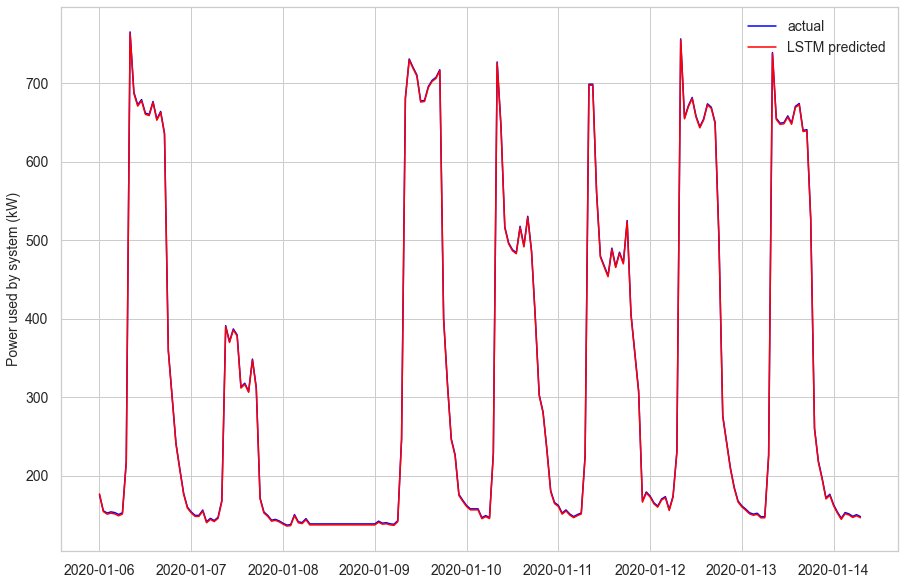

In [68]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(expected_data[:200], color="blue", label="actual")
pyplot.plot(fcast_data[:200], color="red", label="LSTM predicted")
pyplot.legend(loc='upper right')
# pyplot.xlabel("Date Time")
pyplot.ylabel("Power used by system (kW)")
pyplot.show()

### LSTM with features

Let's re-build LSTM model with all features we have in multi-layers LSTM and dropout.

In [69]:
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from keras.layers import Activation
from numpy import concatenate

(9586, 14)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.254247   0.414365        0.0        0.0        1.0        1.0   
2   0.253532   0.398041        0.0        0.0        1.0        1.0   
3   0.258963   0.385485        0.0        0.0        1.0        1.0   
4   0.260419   0.369161        0.0        0.0        1.0        1.0   
5   0.259729   0.359116        0.0        0.0        1.0        1.0   

   var7(t-1)   var1(t)  
1        0.0  0.253532  
2        0.0  0.258963  
3        0.0  0.260419  
4        0.0  0.259729  
5        0.0  0.254022  
(9490, 1, 7) (9490,) (96, 1, 7) (96,)
Train on 9490 samples, validate on 96 samples
Epoch 1/50
9490/9490 [==============================] - 108s 11ms/step - loss: 0.0640 - val_loss: 0.0513
Epoch 2/50
9490/9490 [==============================] - 113s 12ms/step - loss: 0.0520 - val_loss: 0.0187
Epoch 3/50
9490/9490 [==============================] - 109s 12ms/step - loss: 0.0489 - val_loss: 0.0317
Epoch 4/50
94

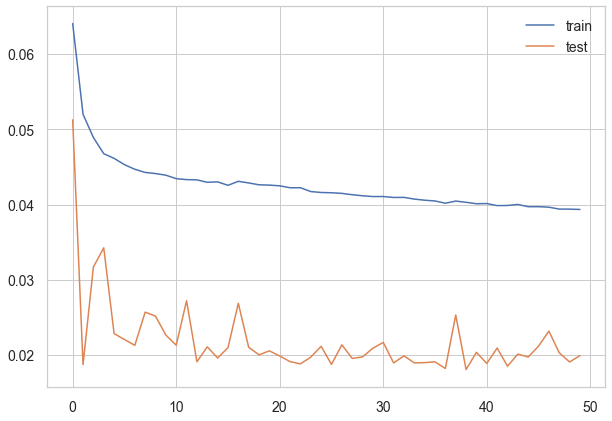

In [70]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = pd.read_csv("data/PMT_22kV_HT_1-energy.csv")
dataset = dataset.set_index('localtime')
del dataset['date']


values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
predict_values_exp = 96
n_train_hours = values.shape[0] - predict_values_exp
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
lstm_f_model = Sequential()
#input layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
lstm_f_model.add(Dropout(0.2))
#LSTM layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_f_model.add(Dropout(0.2))
#output layer
lstm_f_model.add(Dense(1))

lstm_f_model.compile(loss='mae', optimizer='adam')
# fit network
history = lstm_f_model.fit(train_X, train_y, epochs=epoch_exp, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [71]:
# make a prediction
yhat = lstm_f_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [72]:

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 34.602


In [73]:
# get the dates to forecast
last_date = dataset.index[-test.shape[0]] 
fcast_range = pd.date_range(last_date, periods=test.shape[0], freq="1H")
fcast_data = pd.Series(index=fcast_range, data=inv_yhat)
expected_data = pd.Series(index=fcast_range, data=inv_y)
test_score = mape(inv_y, inv_yhat)
print('LSTM with Features model MAPE is {:.2f}%'.format(test_score))

# save results for later comparison
forecasting_results["lstm_features"] = {
    "fcast": fcast_data,
    "model": history,
    "explained_variance_score":explained_variance_score(inv_y, inv_yhat),
    "mape": test_score
}

LSTM with Features model MAPE is 6.65%


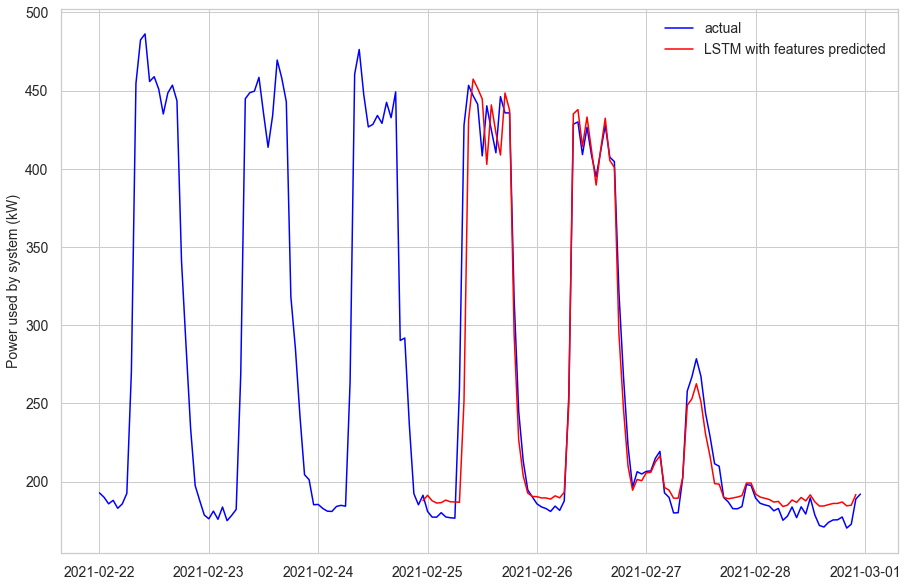

In [74]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(df[df.index > start_date], color="blue", label="actual")
pyplot.plot(fcast_data, color="red", label="LSTM with features predicted")
pyplot.legend(loc='upper right')
pyplot.ylabel("Power used by system (kW)")
pyplot.show()


### LSTM with selected features

Let's try only temperature, working_days, weekdays, which higher correlations found in exploratory data analysis

(9586, 8)
(9490, 1, 4) (9490,) (96, 1, 4) (96,)
Train on 9490 samples, validate on 96 samples
Epoch 1/50
9490/9490 [==============================] - 122s 13ms/step - loss: 0.0610 - val_loss: 0.0322
Epoch 2/50
9490/9490 [==============================] - 119s 13ms/step - loss: 0.0508 - val_loss: 0.0310
Epoch 3/50
9490/9490 [==============================] - 121s 13ms/step - loss: 0.0477 - val_loss: 0.0263
Epoch 4/50
9490/9490 [==============================] - 119s 12ms/step - loss: 0.0460 - val_loss: 0.0249
Epoch 5/50
9490/9490 [==============================] - 122s 13ms/step - loss: 0.0457 - val_loss: 0.0293
Epoch 6/50
9490/9490 [==============================] - 120s 13ms/step - loss: 0.0451 - val_loss: 0.0243
Epoch 7/50
9490/9490 [==============================] - 118s 12ms/step - loss: 0.0448 - val_loss: 0.0193
Epoch 8/50
9490/9490 [==============================] - 124s 13ms/step - loss: 0.0444 - val_loss: 0.0211
Epoch 9/50
9490/9490 [==============================] - 121s 13ms/

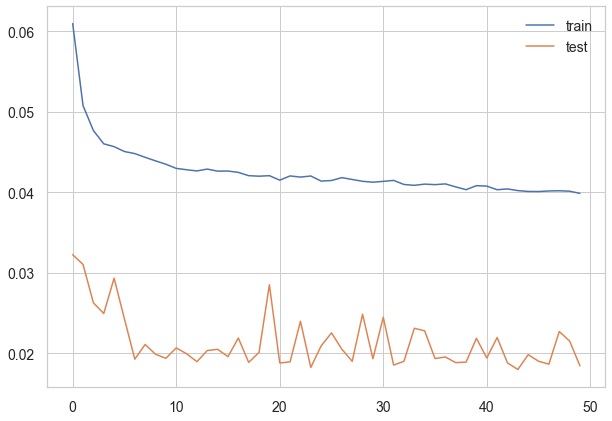

In [75]:
# remove some features to reduce overfitting

# load dataset
dataset = pd.read_csv("data/PMT_22kV_HT_1-energy.csv")
dataset = dataset.set_index('localtime')
del dataset['date']
del dataset['primary_school_holiday']
del dataset['public_holiday']
del dataset['covid_phases']

values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,3] = encoder.fit_transform(values[:,3])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
 
# split into train and test sets
values = reframed.values
# n_train_hours = 365 * 24
predict_values_exp = 96
n_train_hours = values.shape[0] - predict_values_exp
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
lstm_f_model = Sequential()
#input layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
lstm_f_model.add(Dropout(0.2))
#LSTM layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_f_model.add(Dropout(0.2))
#output layer
lstm_f_model.add(Dense(1))

lstm_f_model.compile(loss='mae', optimizer='adam')
# fit network
history = lstm_f_model.fit(train_X, train_y, epochs=epoch_exp, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Test RMSE: 35.288
LSTM with Features model MAPE is 5.78%


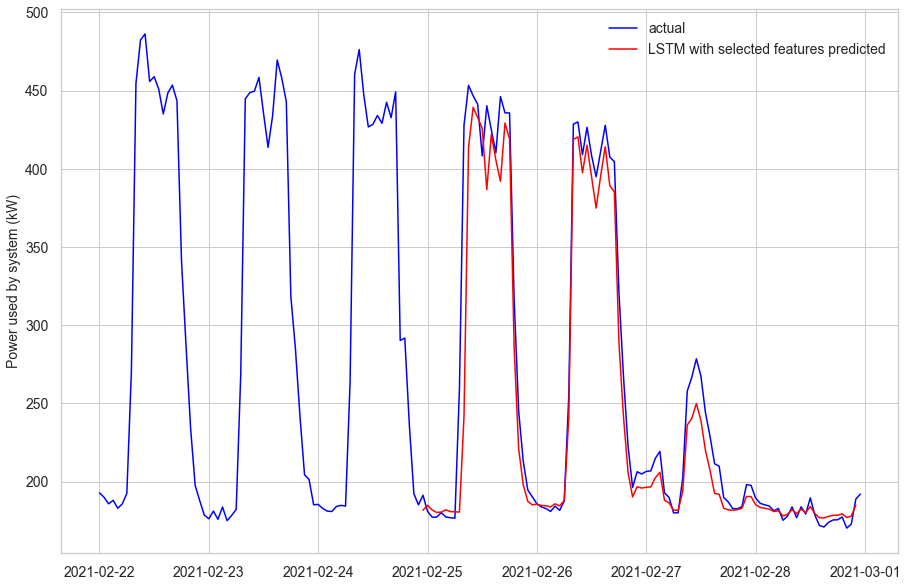

In [76]:
# make a prediction
yhat = lstm_f_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


# get the dates to forecast
last_date = dataset.index[-test.shape[0]] 
fcast_range = pd.date_range(last_date, periods=test.shape[0], freq="1H")
fcast_data = pd.Series(index=fcast_range, data=inv_yhat)
expected_data = pd.Series(index=fcast_range, data=inv_y)
test_score = mape(inv_y, inv_yhat)
print('LSTM with Features model MAPE is {:.2f}%'.format(test_score))

# save results for later comparison
forecasting_results["lstm_features_selected"] = {
    "fcast": fcast_data,
    "model": history,
    "explained_variance_score":explained_variance_score(inv_y, inv_yhat),
    "mape": test_score
}

# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(df[df.index > start_date], color="blue", label="actual")
pyplot.plot(fcast_data, color="red", label="LSTM with selected features predicted")
pyplot.legend(loc='upper right')
pyplot.ylabel("Power used by system (kW)")
pyplot.show()


### LSTM with weather data as feature only

Let's try only temperature as feature

(9587, 2)
(9586, 4)
(9490, 1, 2) (9490,) (96, 1, 2) (96,)
Train on 9490 samples, validate on 96 samples
Epoch 1/50
9490/9490 [==============================] - 115s 12ms/step - loss: 0.0567 - val_loss: 0.0402
Epoch 2/50
9490/9490 [==============================] - 109s 11ms/step - loss: 0.0488 - val_loss: 0.0193
Epoch 3/50
9490/9490 [==============================] - 111s 12ms/step - loss: 0.0462 - val_loss: 0.0207
Epoch 4/50
9490/9490 [==============================] - 109s 12ms/step - loss: 0.0453 - val_loss: 0.0255
Epoch 5/50
9490/9490 [==============================] - 115s 12ms/step - loss: 0.0450 - val_loss: 0.0222
Epoch 6/50
9490/9490 [==============================] - 116s 12ms/step - loss: 0.0442 - val_loss: 0.0282
Epoch 7/50
9490/9490 [==============================] - 172s 18ms/step - loss: 0.0438 - val_loss: 0.0201
Epoch 8/50
9490/9490 [==============================] - 128s 14ms/step - loss: 0.0437 - val_loss: 0.0259
Epoch 9/50
9490/9490 [==============================] - 

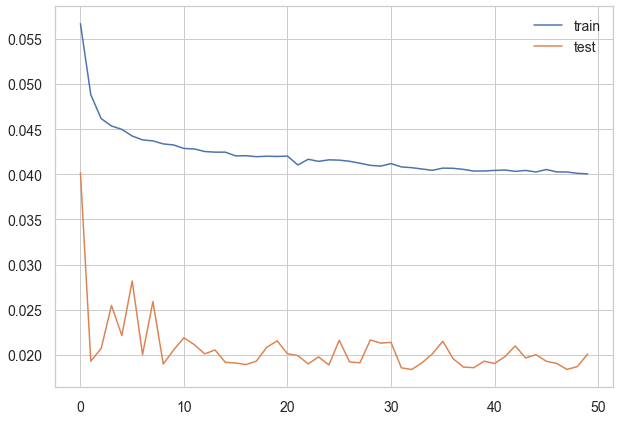

In [77]:
# remove some features to reduce overfitting

# load dataset
dataset = pd.read_csv("data/PMT_22kV_HT_1-energy.csv")
dataset = dataset.set_index('localtime')
del dataset['date']
del dataset['primary_school_holiday']
del dataset['public_holiday']
del dataset['covid_phases']
del dataset['week_days']
del dataset['working_day']

values = dataset.values
# integer encode direction
encoder = LabelEncoder()
print(values.shape)
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
 
# split into train and test sets
values = reframed.values
predict_values_exp = 96
n_train_hours = values.shape[0] - predict_values_exp
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
lstm_f_model = Sequential()
#input layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
lstm_f_model.add(Dropout(0.2))
#LSTM layer
lstm_f_model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_f_model.add(Dropout(0.2))
#output layer
lstm_f_model.add(Dense(1))
lstm_f_model.compile(loss='mae', optimizer='adam')

# fit network
history = lstm_f_model.fit(train_X, train_y, epochs=epoch_exp, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Test RMSE: 35.209
LSTM with Features model MAPE is 6.59%


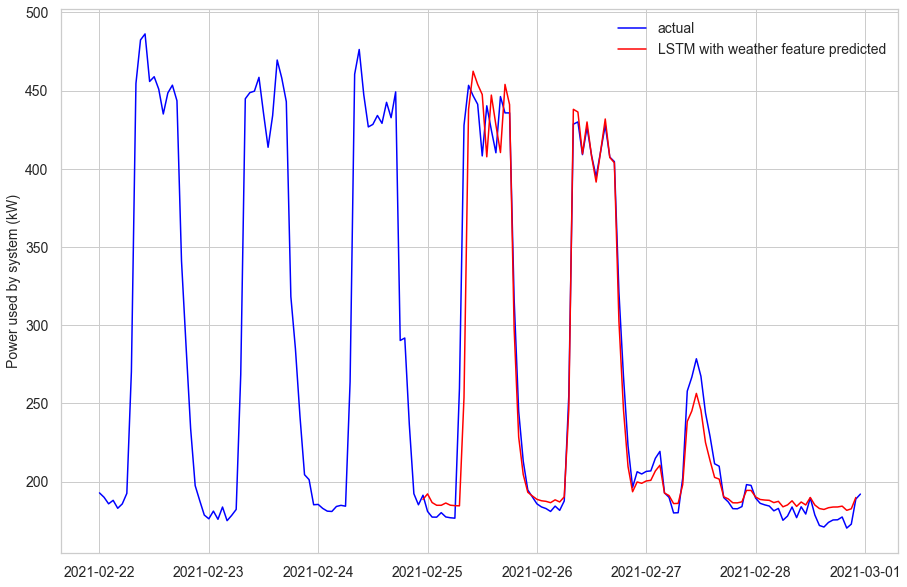

In [78]:
# make a prediction
yhat = lstm_f_model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


# get the dates to forecast
last_date = dataset.index[-test.shape[0]] 
fcast_range = pd.date_range(last_date, periods=test.shape[0], freq="1H")
fcast_data = pd.Series(index=fcast_range, data=inv_yhat)
expected_data = pd.Series(index=fcast_range, data=inv_y)
test_score = mape(inv_y, inv_yhat)
print('LSTM with Features model MAPE is {:.2f}%'.format(test_score))

# save results for later comparison
forecasting_results["lstm_features_weather_only"] = {
    "fcast": fcast_data,
    "model": history,
    "explained_variance_score":explained_variance_score(inv_y, inv_yhat),
    "mape": test_score
}

# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(df[df.index > start_date], color="blue", label="actual")
pyplot.plot(fcast_data, color="red", label="LSTM with weather feature predicted")
pyplot.legend(loc='upper right')
pyplot.ylabel("Power used by system (kW)")
pyplot.show()


## ARIMA Forecast

In [79]:
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

In [80]:
dataset = pd.read_csv("data/PMT_22kV_HT_1-energy.csv")
dataset = dataset.set_index('localtime')
series = dataset['power']

# split into train and test sets
X = series.values

predict_values_exp = 96
n_train_hours = len(X) - predict_values_exp

train, test = X[0:n_train_hours], X[n_train_hours:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
test_len=len(test);
for t in range(test_len):
    model = ARIMA(history, order=(25,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('process %f of %f records, predicted=%f, expected=%f' % (t, test_len, yhat, obs))
# evaluate forecasts

C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 0.000000 of 96.000000 records, predicted=180.475826, expected=191.265010


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 1.000000 of 96.000000 records, predicted=202.287712, expected=180.917742


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 2.000000 of 96.000000 records, predicted=182.604916, expected=177.289810


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 3.000000 of 96.000000 records, predicted=184.940198, expected=177.240594


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 4.000000 of 96.000000 records, predicted=175.684148, expected=180.119350


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 5.000000 of 96.000000 records, predicted=201.859577, expected=177.386631


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 6.000000 of 96.000000 records, predicted=184.614860, expected=176.861738


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 7.000000 of 96.000000 records, predicted=190.557211, expected=176.594288


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 8.000000 of 96.000000 records, predicted=244.935428, expected=259.509289


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 9.000000 of 96.000000 records, predicted=387.694548, expected=427.806508


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 10.000000 of 96.000000 records, predicted=430.303756, expected=453.358232


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 11.000000 of 96.000000 records, predicted=438.551025, expected=446.699097


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 12.000000 of 96.000000 records, predicted=433.067132, expected=441.251217


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 13.000000 of 96.000000 records, predicted=434.535465, expected=408.239297


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 14.000000 of 96.000000 records, predicted=405.577297, expected=440.279310


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 15.000000 of 96.000000 records, predicted=444.922875, expected=424.790236


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 16.000000 of 96.000000 records, predicted=434.809891, expected=410.240082


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 17.000000 of 96.000000 records, predicted=413.499537, expected=446.171063


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 18.000000 of 96.000000 records, predicted=440.644107, expected=435.733554


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 19.000000 of 96.000000 records, predicted=311.762898, expected=316.867113


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 20.000000 of 96.000000 records, predicted=300.713634, expected=244.929689


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 21.000000 of 96.000000 records, predicted=208.223659, expected=213.069845


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 22.000000 of 96.000000 records, predicted=179.595831, expected=194.621116


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 23.000000 of 96.000000 records, predicted=189.094026, expected=190.148836


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 24.000000 of 96.000000 records, predicted=193.800465, expected=185.771833


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 25.000000 of 96.000000 records, predicted=186.914524, expected=183.793429


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 26.000000 of 96.000000 records, predicted=189.710147, expected=182.740258


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 27.000000 of 96.000000 records, predicted=185.609292, expected=180.893017


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 28.000000 of 96.000000 records, predicted=181.228720, expected=184.308733


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 29.000000 of 96.000000 records, predicted=197.976341, expected=181.596341


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 30.000000 of 96.000000 records, predicted=200.344770, expected=187.600332


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 31.000000 of 96.000000 records, predicted=196.901403, expected=255.038480


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 32.000000 of 96.000000 records, predicted=313.616129, expected=428.503018


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 33.000000 of 96.000000 records, predicted=526.566455, expected=429.970970


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 34.000000 of 96.000000 records, predicted=441.965459, expected=409.053863


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 35.000000 of 96.000000 records, predicted=402.669807, expected=426.527130


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 36.000000 of 96.000000 records, predicted=419.917637, expected=408.437931


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 37.000000 of 96.000000 records, predicted=387.101871, expected=394.867289


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 38.000000 of 96.000000 records, predicted=410.132055, expected=411.203999


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 39.000000 of 96.000000 records, predicted=407.064051, expected=427.813641


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 40.000000 of 96.000000 records, predicted=423.298557, expected=407.465257


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 41.000000 of 96.000000 records, predicted=420.889650, expected=404.584829


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 42.000000 of 96.000000 records, predicted=361.827603, expected=321.172299


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 43.000000 of 96.000000 records, predicted=245.749336, expected=267.278800


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 44.000000 of 96.000000 records, predicted=229.066800, expected=222.835187


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 45.000000 of 96.000000 records, predicted=197.137255, expected=196.262670


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 46.000000 of 96.000000 records, predicted=182.315300, expected=206.291105


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 47.000000 of 96.000000 records, predicted=213.672806, expected=204.841075


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 48.000000 of 96.000000 records, predicted=208.071511, expected=206.512719


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 49.000000 of 96.000000 records, predicted=202.446186, expected=206.822088


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 50.000000 of 96.000000 records, predicted=214.449677, expected=214.888082


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 51.000000 of 96.000000 records, predicted=215.614978, expected=219.306734


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 52.000000 of 96.000000 records, predicted=224.265629, expected=192.783232


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 53.000000 of 96.000000 records, predicted=205.176245, expected=189.903524


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 54.000000 of 96.000000 records, predicted=209.842683, expected=179.954341


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 55.000000 of 96.000000 records, predicted=235.213620, expected=180.081770


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 56.000000 of 96.000000 records, predicted=293.103567, expected=202.258658


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 57.000000 of 96.000000 records, predicted=218.394554, expected=257.853049


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 58.000000 of 96.000000 records, predicted=258.197228, expected=266.758301


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 59.000000 of 96.000000 records, predicted=285.922755, expected=278.531082


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 60.000000 of 96.000000 records, predicted=272.831407, expected=267.316357


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 61.000000 of 96.000000 records, predicted=263.986099, expected=243.921274


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 62.000000 of 96.000000 records, predicted=271.971947, expected=228.850396


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 63.000000 of 96.000000 records, predicted=256.657008, expected=211.401021


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 64.000000 of 96.000000 records, predicted=224.393999, expected=209.813197


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 65.000000 of 96.000000 records, predicted=231.066500, expected=189.783947


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 66.000000 of 96.000000 records, predicted=164.790902, expected=186.969220


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 67.000000 of 96.000000 records, predicted=164.297166, expected=182.676521


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 68.000000 of 96.000000 records, predicted=166.284022, expected=182.592070


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 69.000000 of 96.000000 records, predicted=173.465915, expected=184.011730


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 70.000000 of 96.000000 records, predicted=191.988463, expected=198.059202


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 71.000000 of 96.000000 records, predicted=199.508683, expected=197.555261


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 72.000000 of 96.000000 records, predicted=206.432344, expected=189.440023


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 73.000000 of 96.000000 records, predicted=198.067137, expected=186.098984


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 74.000000 of 96.000000 records, predicted=200.174410, expected=185.114766


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 75.000000 of 96.000000 records, predicted=201.342703, expected=184.353934


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 76.000000 of 96.000000 records, predicted=179.567421, expected=181.292477


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 77.000000 of 96.000000 records, predicted=184.634826, expected=182.823020


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 78.000000 of 96.000000 records, predicted=180.151913, expected=175.256456


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 79.000000 of 96.000000 records, predicted=177.317095, expected=177.921106


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 80.000000 of 96.000000 records, predicted=188.309741, expected=183.750852


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 81.000000 of 96.000000 records, predicted=214.173836, expected=176.932285


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 82.000000 of 96.000000 records, predicted=186.299130, expected=183.877117


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 83.000000 of 96.000000 records, predicted=195.242966, expected=179.236180


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 84.000000 of 96.000000 records, predicted=178.162744, expected=189.607989


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 85.000000 of 96.000000 records, predicted=184.066598, expected=178.649439


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 86.000000 of 96.000000 records, predicted=179.195204, expected=171.921557


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 87.000000 of 96.000000 records, predicted=170.047865, expected=170.941098


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 88.000000 of 96.000000 records, predicted=177.867920, expected=173.912129


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 89.000000 of 96.000000 records, predicted=169.241522, expected=175.457517


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 90.000000 of 96.000000 records, predicted=176.281127, expected=175.564006


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 91.000000 of 96.000000 records, predicted=176.689494, expected=177.352589


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 92.000000 of 96.000000 records, predicted=178.409807, expected=170.256785


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 93.000000 of 96.000000 records, predicted=173.616252, expected=172.781440


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 94.000000 of 96.000000 records, predicted=179.938664, expected=188.832738


C:\Users\min.zhang2\.conda\envs\p37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


process 95.000000 of 96.000000 records, predicted=190.477499, expected=191.998854


In [81]:
# Calculate the model MAPE
last_date = series.index[-test.shape[0]] 
fcast_range = pd.date_range(last_date, periods=test.shape[0], freq="1H")
fcast_data = pd.Series(index=fcast_range, data=predictions)
test_data = pd.Series(index=fcast_range, data=test)
test_score = mape(test_data, fcast_data)
print('ARIMA model MAPE is {:.2f}%'.format(test_score))

# save results for later comparison
forecasting_results["arima"] = {
    "fcast": fcast_data,
    "explained_variance_score":explained_variance_score(fcast_data, test_data),
    "mape": test_score
}

ARIMA model MAPE is 7.12%


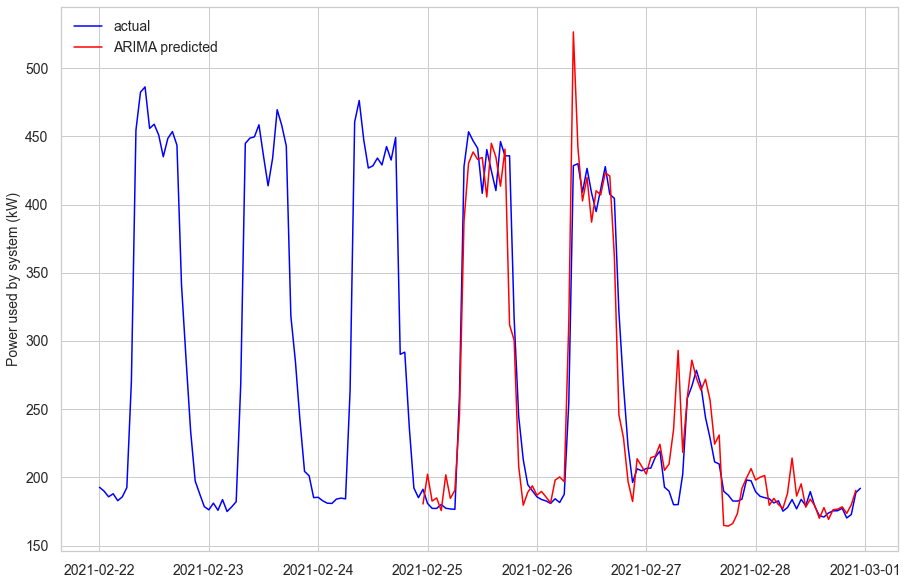

In [82]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(15,10))

start_date = df.index[-1] - pd.Timedelta(days=7)
pyplot.plot(df[df.index > start_date], color="blue", label="actual")
pyplot.plot(fcast_data, color="red", label="ARIMA predicted")

pyplot.legend(loc='upper left')
pyplot.ylabel("Power used by system (kW)")
pyplot.show()

## Draw the graphs

After exploring different kinds of models and methods, let's render some visualization to have a direct view of the model performances and weaknesses from the exercise results.

Exclude SES and Holt which not looks good for the weekend forecasting.

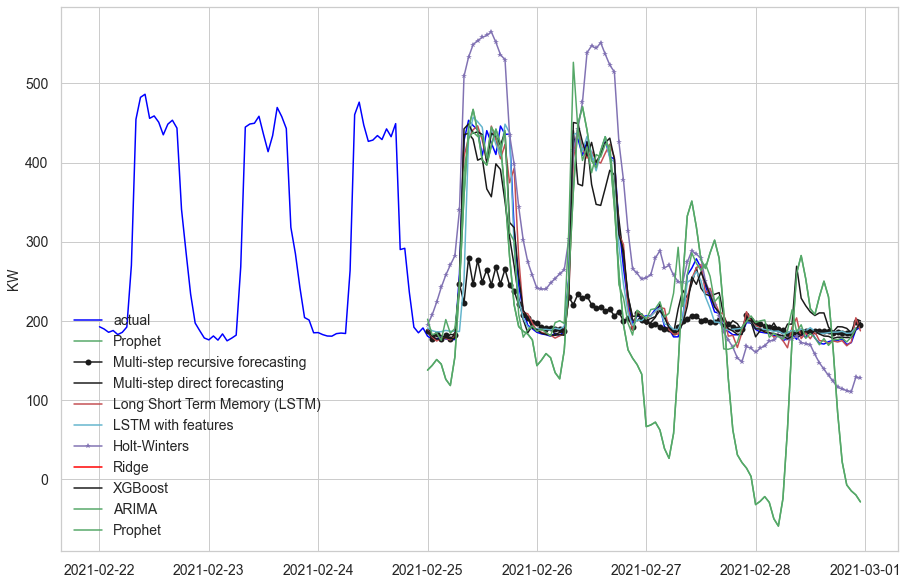

In [83]:
prophet_fcast = forecasting_results["prophet"]["fcast"]
# ses_fcast = forecasting_results["ses"]["fcast"]
# holt_fcast = forecasting_results["holt"]["fcast"]
holt_winters_fcast = forecasting_results["holt_winters"]["fcast"]
ridge_fcast = forecasting_results["ridge"]["fcast"]
xgb_fcast = forecasting_results["xgb"]["fcast"]
xgb_recursive_fcast = forecasting_results["xgb_recursive"]["fcast"]
xgb_direct_fcast = forecasting_results["xgb_direct"]["fcast"]
lstm_fcast = forecasting_results["lstm"]["fcast"]
lstm_features_fcast = forecasting_results["lstm_features"]["fcast"]
arima_fcast = forecasting_results["arima"]["fcast"]

fig, ax = plt.subplots(1, 1, figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)

pyplot.plot(df[df.index > start_date], color="blue", label="actual")
ax.set(ylabel="KW")

ax.plot(prophet[prophet_fcast.index >= f_target.index[0]], 
         color="g", 
         label="Prophet")

ax.plot(xgb_recursive_fcast[xgb_recursive_fcast.index >= f_target.index[0]], 
         color="k", 
         label="Multi-step recursive forecasting" , marker="o")

ax.plot(xgb_direct_fcast[xgb_direct_fcast.index >= f_target.index[0]], 
         color="k", 
         label="Multi-step direct forecasting", marker="x")

ax.plot(lstm_fcast[lstm_fcast.index >= f_target.index[0]], 
         color="r", 
         label="Long Short Term Memory (LSTM)")

ax.plot(lstm_features_fcast[lstm_features_fcast.index >= f_target.index[0]], 
         color="c", 
         label="LSTM with features")

ax.plot(holt_winters_fcast[holt_winters_fcast.index >= f_target.index[0]], 
         color="m", 
         label="Holt-Winters", marker="*")

ax.plot(ridge_fcast[ridge_fcast.index >= f_target.index[0]], 
         color="red", 
         label="Ridge")

ax.plot(xgb_fcast[xgb_fcast.index >= f_target.index[0]], 
         color="k", 
         label="XGBoost")

ax.plot(arima_fcast[arima_fcast.index >= f_target.index[0]], 
         color="g", 
         label="ARIMA")

ax.plot(prophet[prophet_fcast.index >= f_target.index[0]], 
         color="g", 
         label="Prophet")

ax.legend(loc='lower left')
# ax.legend()
plt.show()

Render the graph include all models we had explored

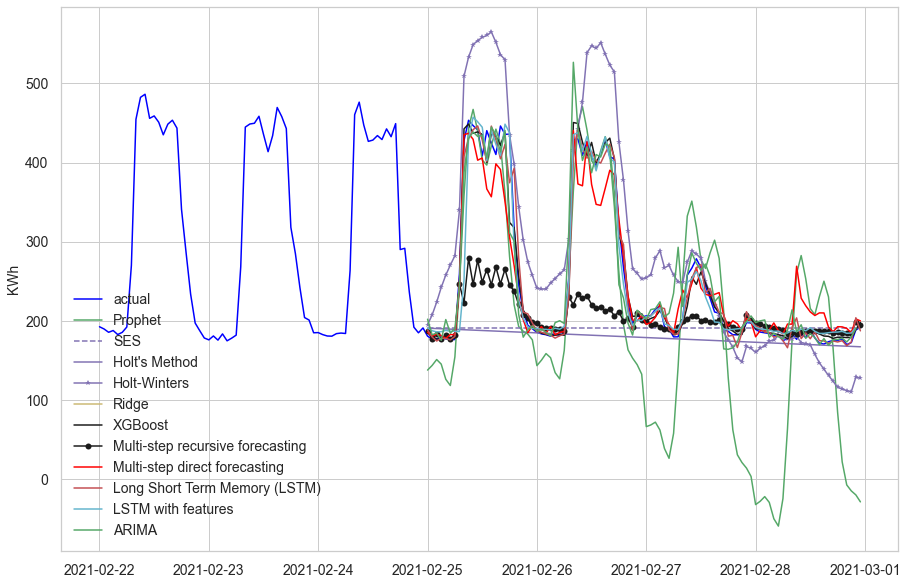

In [85]:
prophet_fcast = forecasting_results["prophet"]["fcast"]
ses_fcast = forecasting_results["ses"]["fcast"]
holt_fcast = forecasting_results["holt"]["fcast"]
holt_winters_fcast = forecasting_results["holt_winters"]["fcast"]
ridge_fcast = forecasting_results["ridge"]["fcast"]
xgb_fcast = forecasting_results["xgb"]["fcast"]
xgb_recursive_fcast = forecasting_results["xgb_recursive"]["fcast"]
xgb_direct_fcast = forecasting_results["xgb_direct"]["fcast"]
lstm_fcast = forecasting_results["lstm"]["fcast"]
lstm_features_fcast = forecasting_results["lstm_features"]["fcast"]
arima_fcast = forecasting_results["arima"]["fcast"]

fig, ax = plt.subplots(1, 1, figsize=(15,10))
start_date = df.index[-1] - pd.Timedelta(days=7)

pyplot.plot(df[df.index > start_date], color="blue", label="actual")
ax.set(ylabel="KWh")

ax.plot(prophet[prophet_fcast.index >= f_target.index[0]], 
         color="g", 
         label="Prophet")

ax.plot(ses_fcast[ses_fcast.index >= f_target.index[0]], 
         color="m", 
         label="SES" , linestyle="--")

ax.plot(holt_fcast[holt_fcast.index >= f_target.index[0]], 
         color="m", 
         label="Holt's Method" , marker="x")

ax.plot(holt_winters_fcast[holt_winters_fcast.index >= f_target.index[0]], 
         color="m", 
         label="Holt-Winters", marker="*")

ax.plot(ridge_fcast[ridge_fcast.index >= f_target.index[0]], 
         color="y", 
         label="Ridge")

ax.plot(xgb_fcast[xgb_fcast.index >= f_target.index[0]], 
         color="k", 
         label="XGBoost")

ax.plot(xgb_recursive_fcast[xgb_recursive_fcast.index >= f_target.index[0]], 
         color="k", 
         label="Multi-step recursive forecasting" , marker="o")

ax.plot(xgb_direct_fcast[xgb_direct_fcast.index >= f_target.index[0]], 
         color="red", 
         label="Multi-step direct forecasting", marker="x")

ax.plot(lstm_fcast[lstm_fcast.index >= f_target.index[0]], 
         color="r", 
         label="Long Short Term Memory (LSTM)")

ax.plot(lstm_features_fcast[lstm_features_fcast.index >= f_target.index[0]], 
         color="c", 
         label="LSTM with features")

ax.plot(arima_fcast[arima_fcast.index >= f_target.index[0]], 
         color="g", 
         label="ARIMA")

ax.legend(loc='lower left')
# ax.legend()
plt.show()

Show the MAPE for all modules in the tabular and graph view for comparison.

mape explained_variance_score
xgb                           3.17459                 0.996664
lstm                         5.286888                 0.912576
lstm_features_selected        5.77632                 0.871365
lstm_features_weather_only   6.592587                 0.864966
lstm_features                6.654682                 0.869752
arima                        7.124836                 0.921961
xgb_direct                   7.645886                 0.906042
xgb_recursive               14.831552                 0.355398
ridge                       18.627721                  0.71908
ses                         19.393833                      0.0
holt                        20.866225                 0.063994
holt_winters                23.018509                 0.649486
prophet                     38.220731                  0.19084

------------- MAPE for all Models: -----------------


mape
xgb                           3.17459
lstm                         5.286888
lstm_features_selected        5.77632
lstm_features_weather_only   6.592587
lstm_features                6.654682
arima                        7.124836
xgb_direct                   7.645886
xgb_recursive               14.831552
ridge                       18.627721
ses                         19.393833
holt                        20.866225
holt_winters                23.018509
prophet                     38.220731

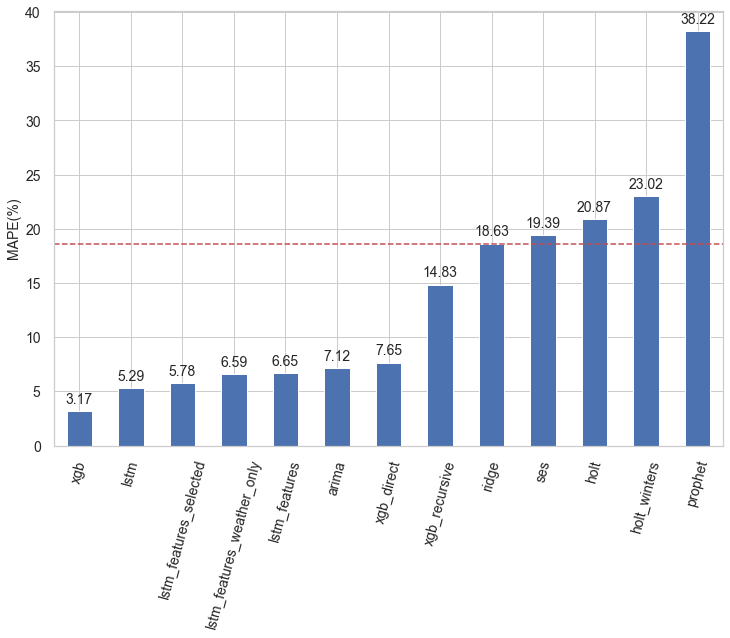

In [86]:
from IPython.display import display

def add_value_labels(ax, spacing=5):
    """
    Refer: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
    Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

forecasting_results_df = DataFrame(forecasting_results).transpose().sort_values(by=['mape'], ascending=True)
display(forecasting_results_df[['mape','explained_variance_score']])
model_mape = forecasting_results_df['mape']
print("------------- MAPE for all Models: -----------------")
display(pd.DataFrame(model_mape))
bars = model_mape.plot.bar(x='models', y='mape', rot=0, figsize=(12,8))
plt.axhline(y=model_mape.ridge, color='r', linestyle='--')
plt.xticks(rotation=75, fontsize=14, horizontalalignment="center")
plt.ylabel('MAPE(%)', fontsize=14)
add_value_labels(bars)
plt.show()

Reference


* https://dzone.com/articles/lessons-learnt-while-solving-time-series-forecasti-1
* https://www.mygreatlearning.com/blog/what-is-ridge-regression/
* https://algorithmia.com/blog/the-importance-of-machine-learning-data
* https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/
* https://medium.datadriveninvestor.com/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1
* https://www.cnblogs.com/harrylyx/p/11852149.html
* https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21
* https://www.youtube.com/watch?v=vTouAvxlphc
* https://github.com/madagra/energy-ts-analysis
